In [1]:
import numpy as np
#import seaborn as sns
#sns.set()
#sns.set(font_scale=1.)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.linalg import lstsq
from scipy.optimize import curve_fit, nnls, minimize
from scipy.signal.windows import blackman
from scipy import fftpack
from scipy import stats
from scipy.signal import find_peaks, hilbert, windows
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d



from itertools import product
from tqdm import tqdm

from quspin.tools.measurements import project_op
from tools import HubbardModel as fhmodel, InitializeArchive
import psutil
from multiprocessing import Pool
import pickle
import h5py

In [3]:
expectations = np.load('zerotrackingfive.npz')

"""show the expectations available here"""
print('expectations available: {}'.format(expectations.files))

"""example for using the analysis code"""
J_field = expectations['current']
J_field_track = expectations['tracking_current']
phi = expectations['phi']
tracking_phi = expectations['tracking_phi']

expectations available: ['H', 'neighbour', 'lhopup', 'lhopdown', 'nup0', 'ndown0', 'D0', 'nup1', 'ndown1', 'D1', 'nup2', 'ndown2', 'D2', 'nup3', 'ndown3', 'D3', 'nup4', 'ndown4', 'D4', 'nup5', 'ndown5', 'D5', 'nup6', 'ndown6', 'D6', 'nup7', 'ndown7', 'D7', 'nup8', 'ndown8', 'D8', 'nup9', 'ndown9', 'D9', 'current', 'phi', 'tracking_current', 'tracking_phi', 'tracking_neighbour']


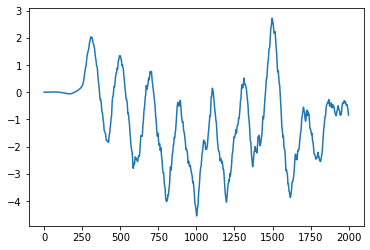

In [4]:
plt.plot(tracking_phi)
plt.show()

In [5]:
def Phi(t, f, s=0, phase=0):
    """
    Transform limited pulse 
    :param t: time
    :param f: frequency, aim for lower values
    :param s: time delay, must be positive
    :param phase: carrier wave phase delay, prefer to change s or t than phase
    :return: Transform limited pulse with enforcement of wave starting at 0
    """
    return np.sin(t - s) ** 2 * np.sin(f * (t - s) + phase) * (t > s) * (t < (s + np.pi)) 

t = np.linspace(0, np.pi, phi.size)

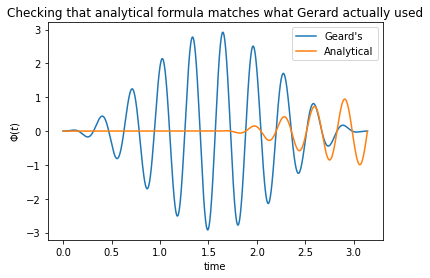

In [6]:
plt.title("Checking that analytical formula matches what Gerard actually used")
plt.plot(t, phi, label='Geard\'s')
plt.plot(t, Phi(t, 20, 0.5 * np.pi), label='Analytical')

plt.legend()
plt.ylabel('$\Phi(t)$')
plt.xlabel('time')
plt.show()

In [6]:
# number of pulses to use
n = 4

def superoscilating_pulse(t, *args):
    
    ampl = args[:n]
    phase = args[n:]
    freq = np.linspace(10, 20, n)
    
    return sum(a * Phi(t, f, s) for a, f, s in zip(ampl, phase, freq))
    

In [7]:
popt, pcov = curve_fit(
    superoscilating_pulse, 
    t, 
    tracking_phi,
    p0=np.random.rand(2 *n),
    max_nfev=10000,
    bounds=(
        np.append(np.zeros(n), t.min() * np.ones(n)),
        np.append(np.inf * np.ones(n), t.max() * np.ones(n)),
    )
)

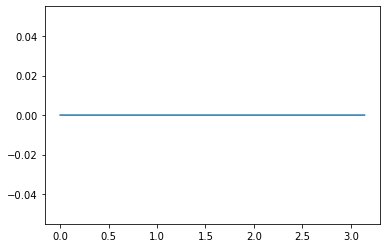

In [8]:
plt.plot(t, superoscilating_pulse(t, *popt))

In [64]:
n = 5

fields = np.array(
    [Phi(t, f, s) for f, s in product(np.linspace(0, 15, n), np.linspace(0, np.pi, 100 * n))]
).T

In [65]:
x = nnls(fields, tracking_phi)[0]

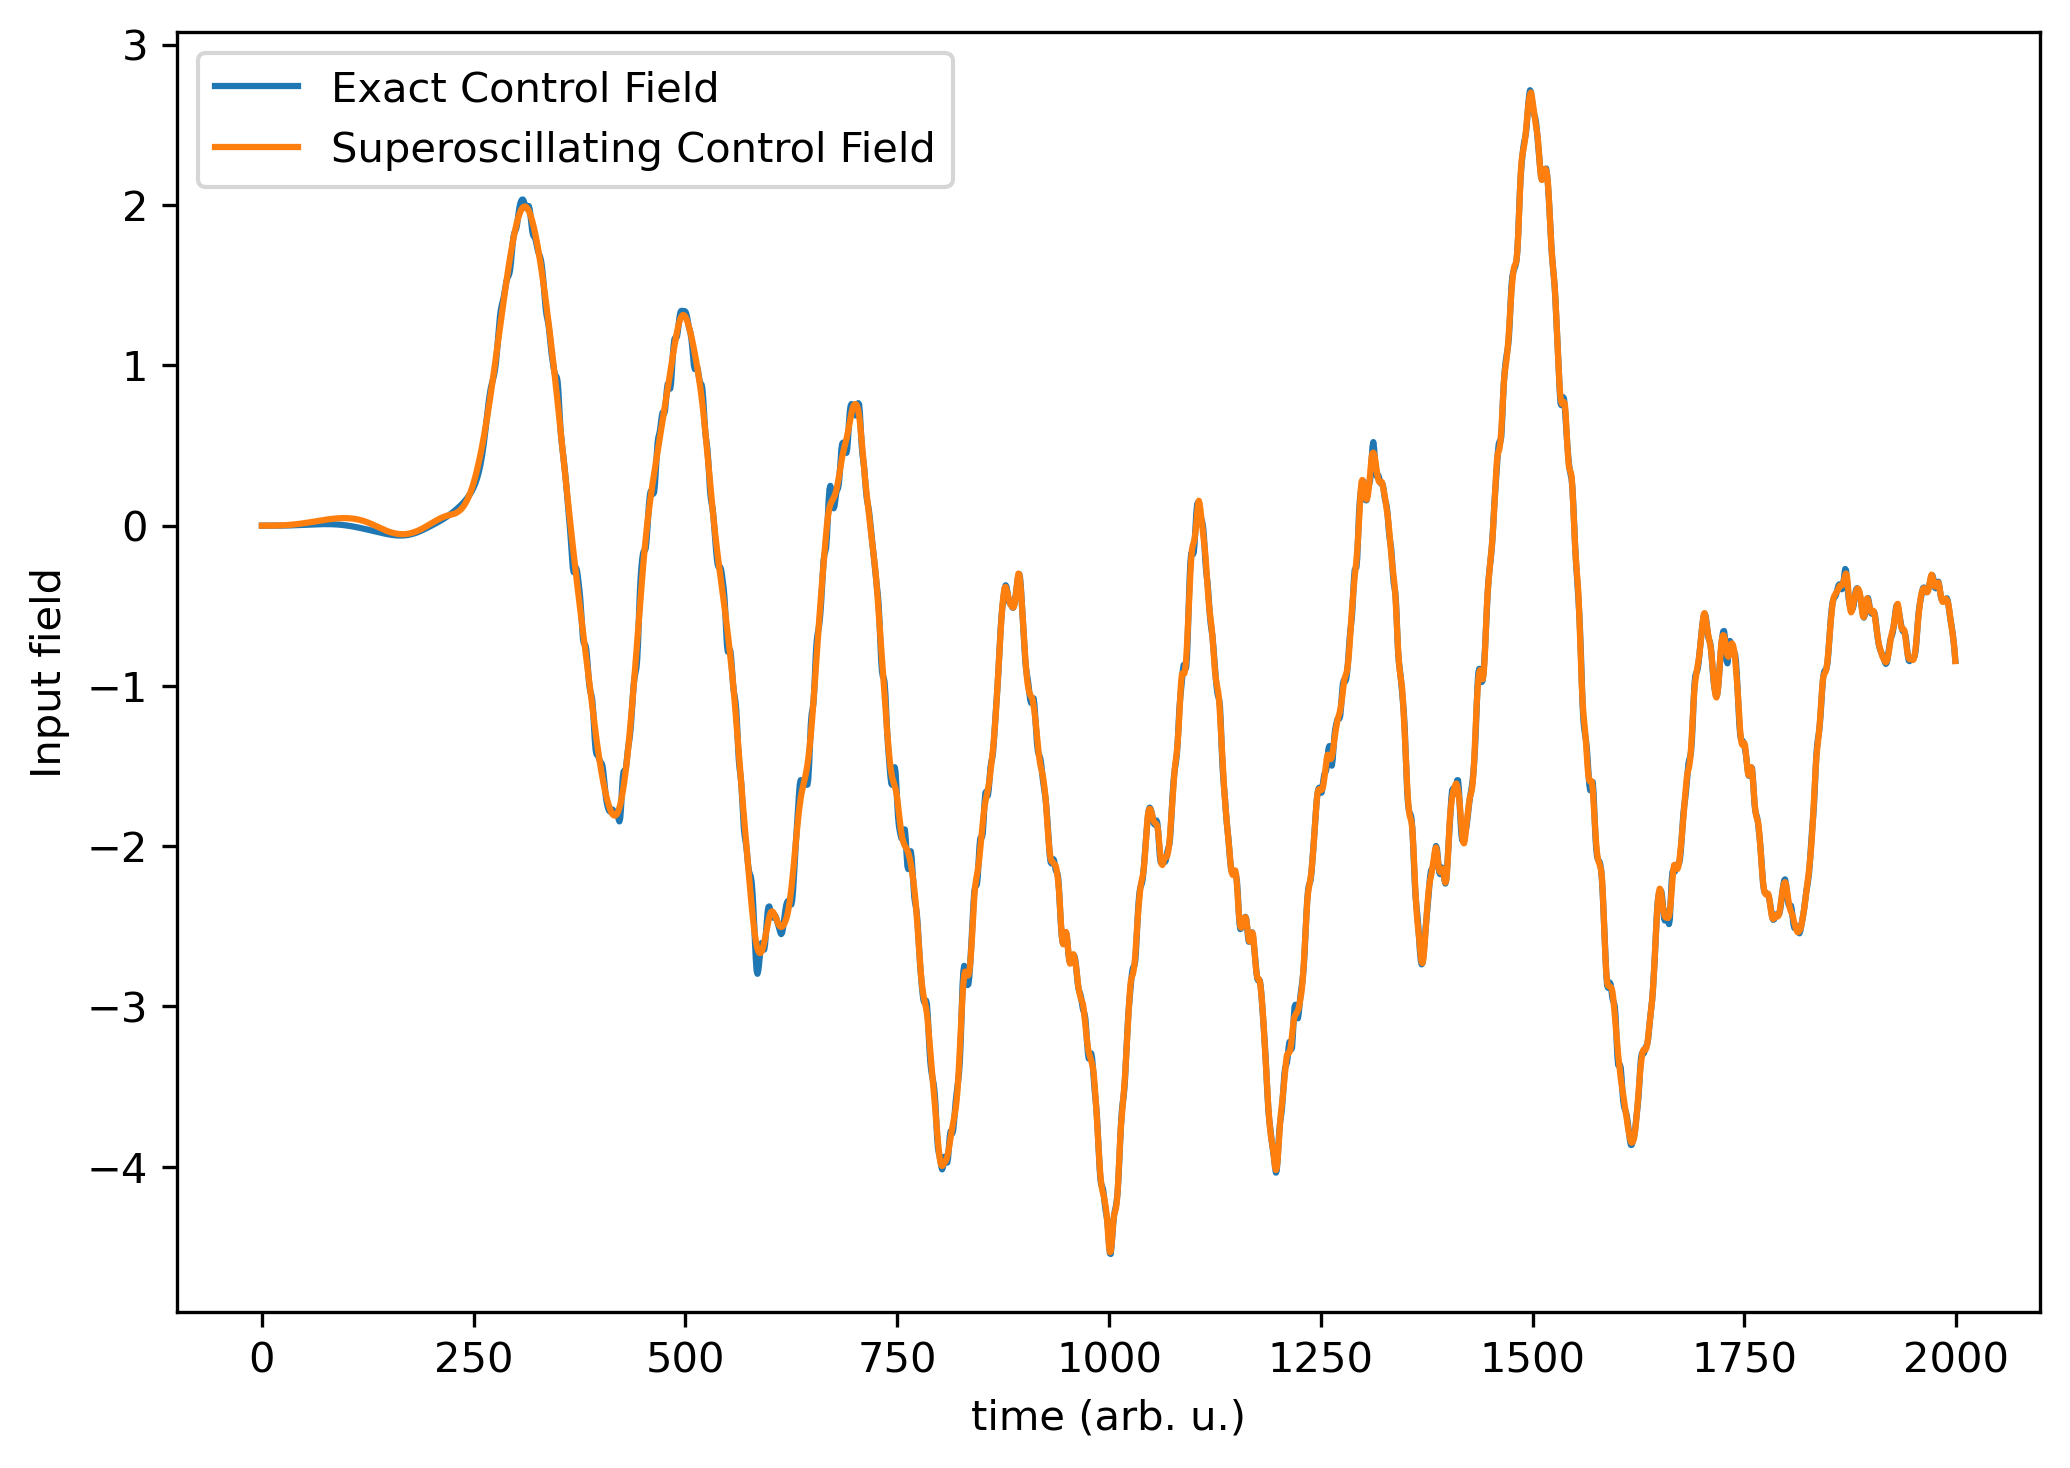

In [66]:
#plt.plot(phi, '--', color='k',label='Transform Limited Field')
plt.figure(figsize=(7, 5), dpi=300)
plt.plot(tracking_phi, label='Exact Control Field')
plt.plot(fields @ x, label='Superoscillating Control Field')

plt.legend()
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./FieldComparrisonPlot.pdf")
plt.show()

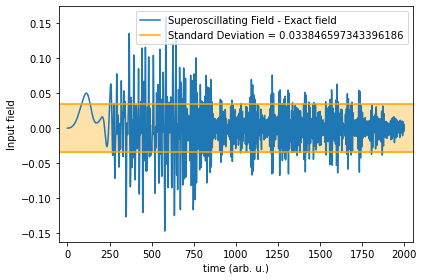

In [67]:
field_diff = (fields @ x)-tracking_phi
avg_diff = sum(field_diff) / len(field_diff)
std_dev_num = []
for n in range(0,len(field_diff)):
    std_dev_num.append((field_diff[n] + avg_diff) ** 2)
std_dev = np.sqrt(sum(std_dev_num)/len(field_diff))

plt.plot(field_diff, label='Superoscillating Field - Exact field')
plt.axhline(y=std_dev, linestyle='-', color='orange', label='Standard Deviation = ' + str(std_dev))
plt.axhline(y=-std_dev, linestyle='-', color='orange')
plt.fill_between([-50,len(field_diff)+50], -std_dev,std_dev,facecolor="orange",
            color='orange',
        alpha=0.333)

plt.legend()
plt.xlim(-50,len(field_diff)+50)
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./DifferencePlot.pdf")
plt.show()

In [68]:
out = './BestFitSCF.npz'
BestFitSCF = fields @ x
np.savez(out, field=BestFitSCF)

(9,)


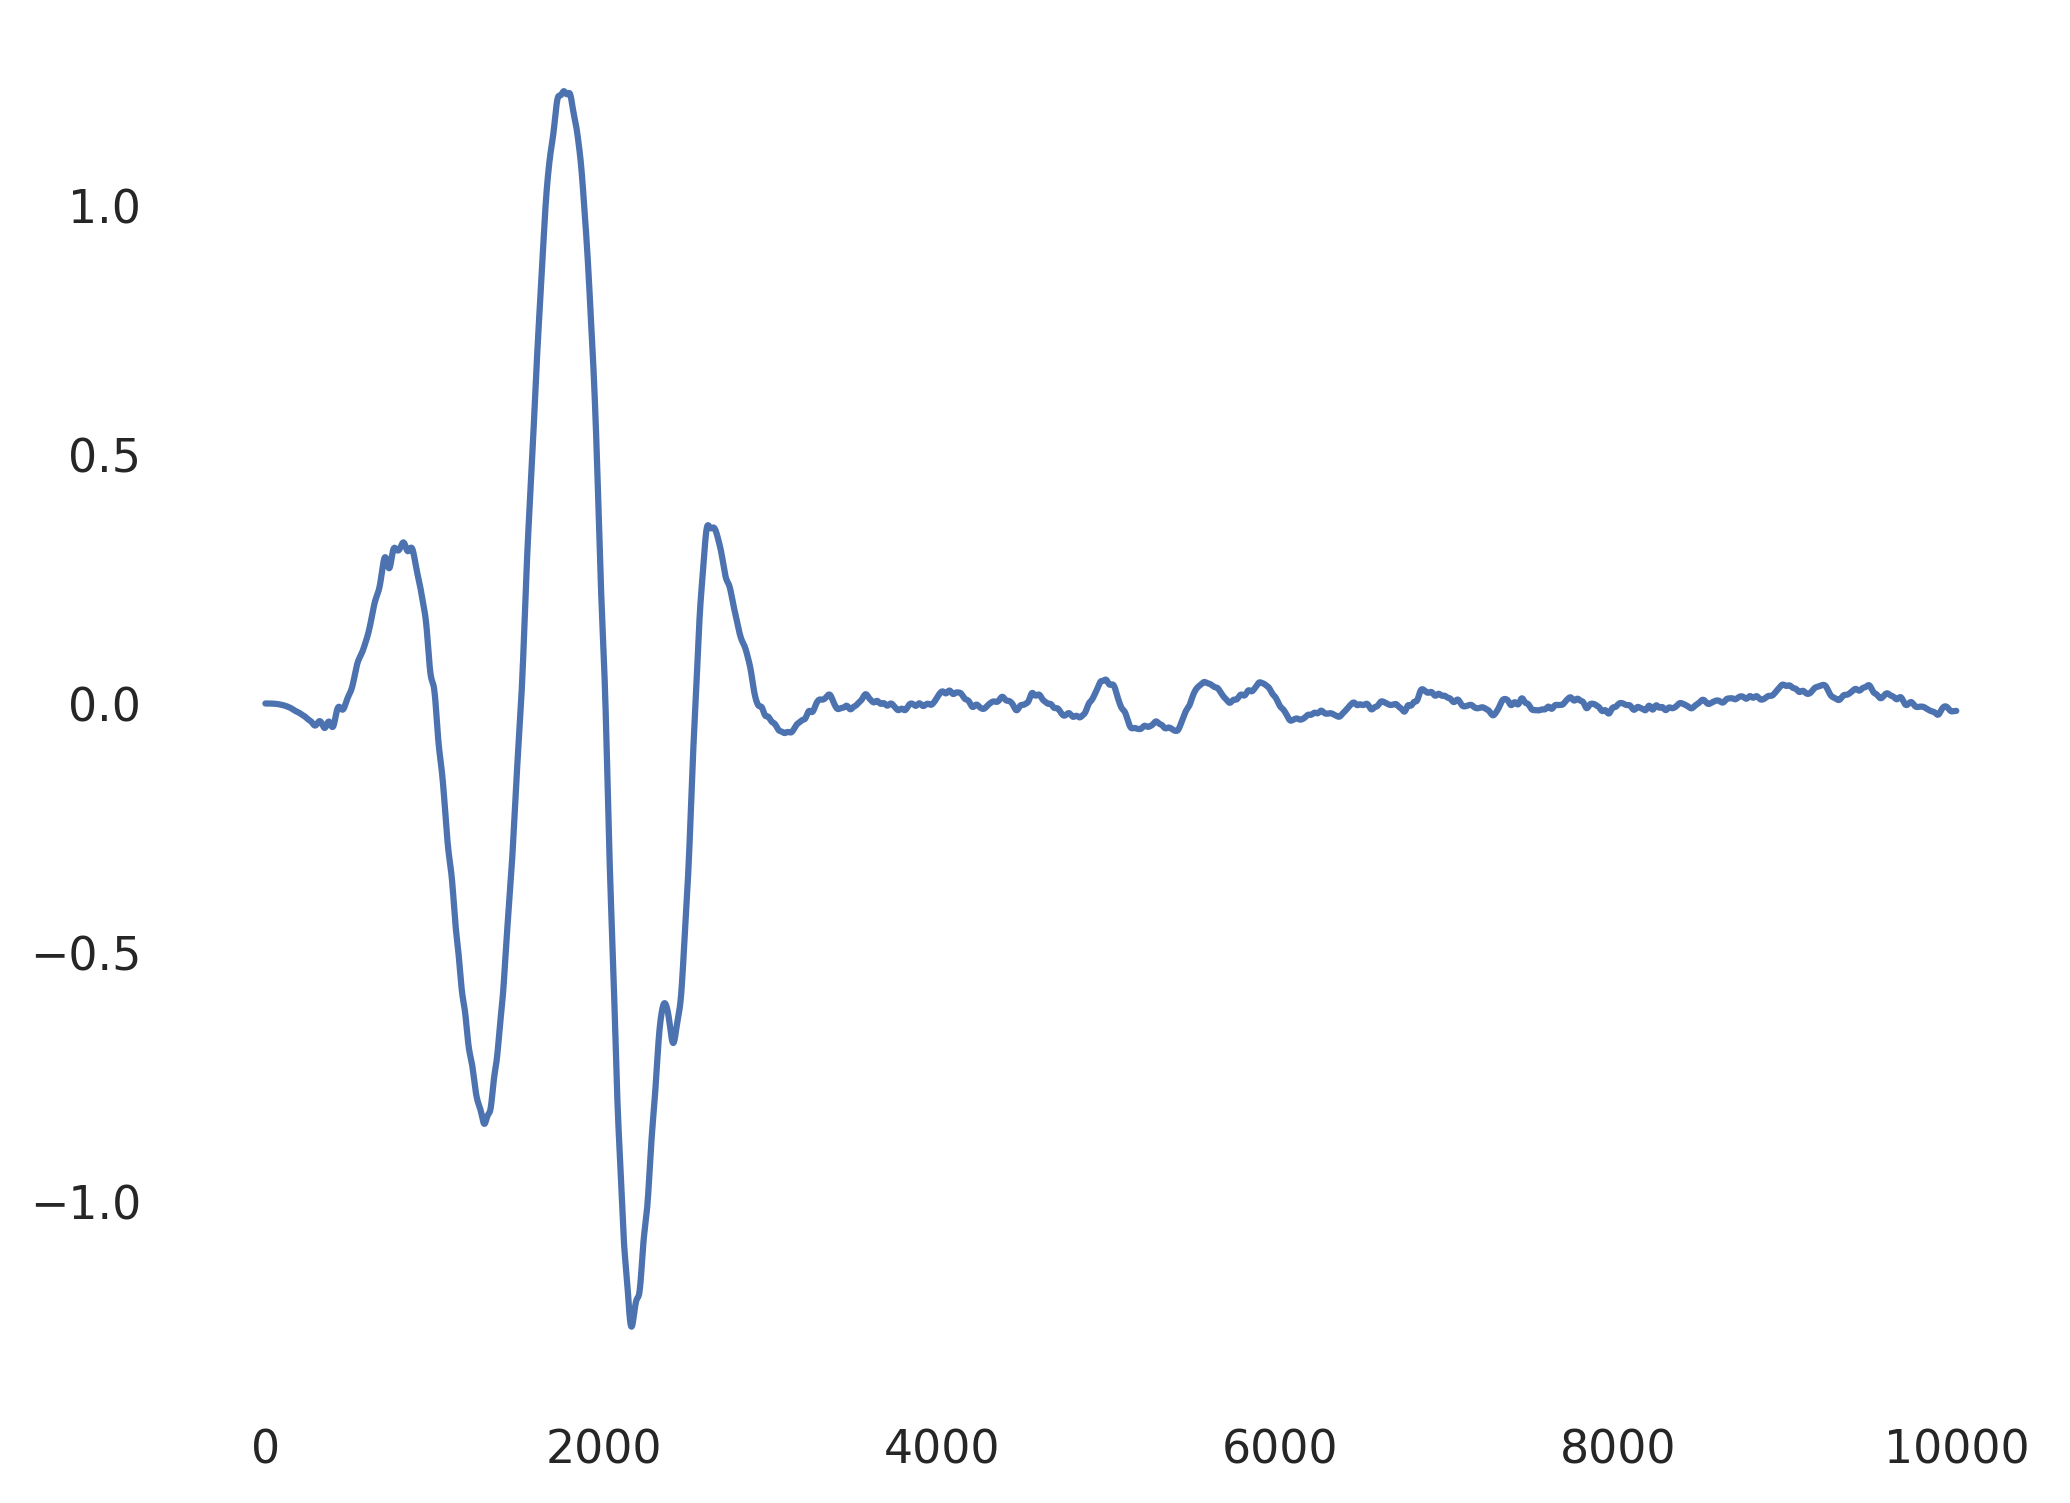

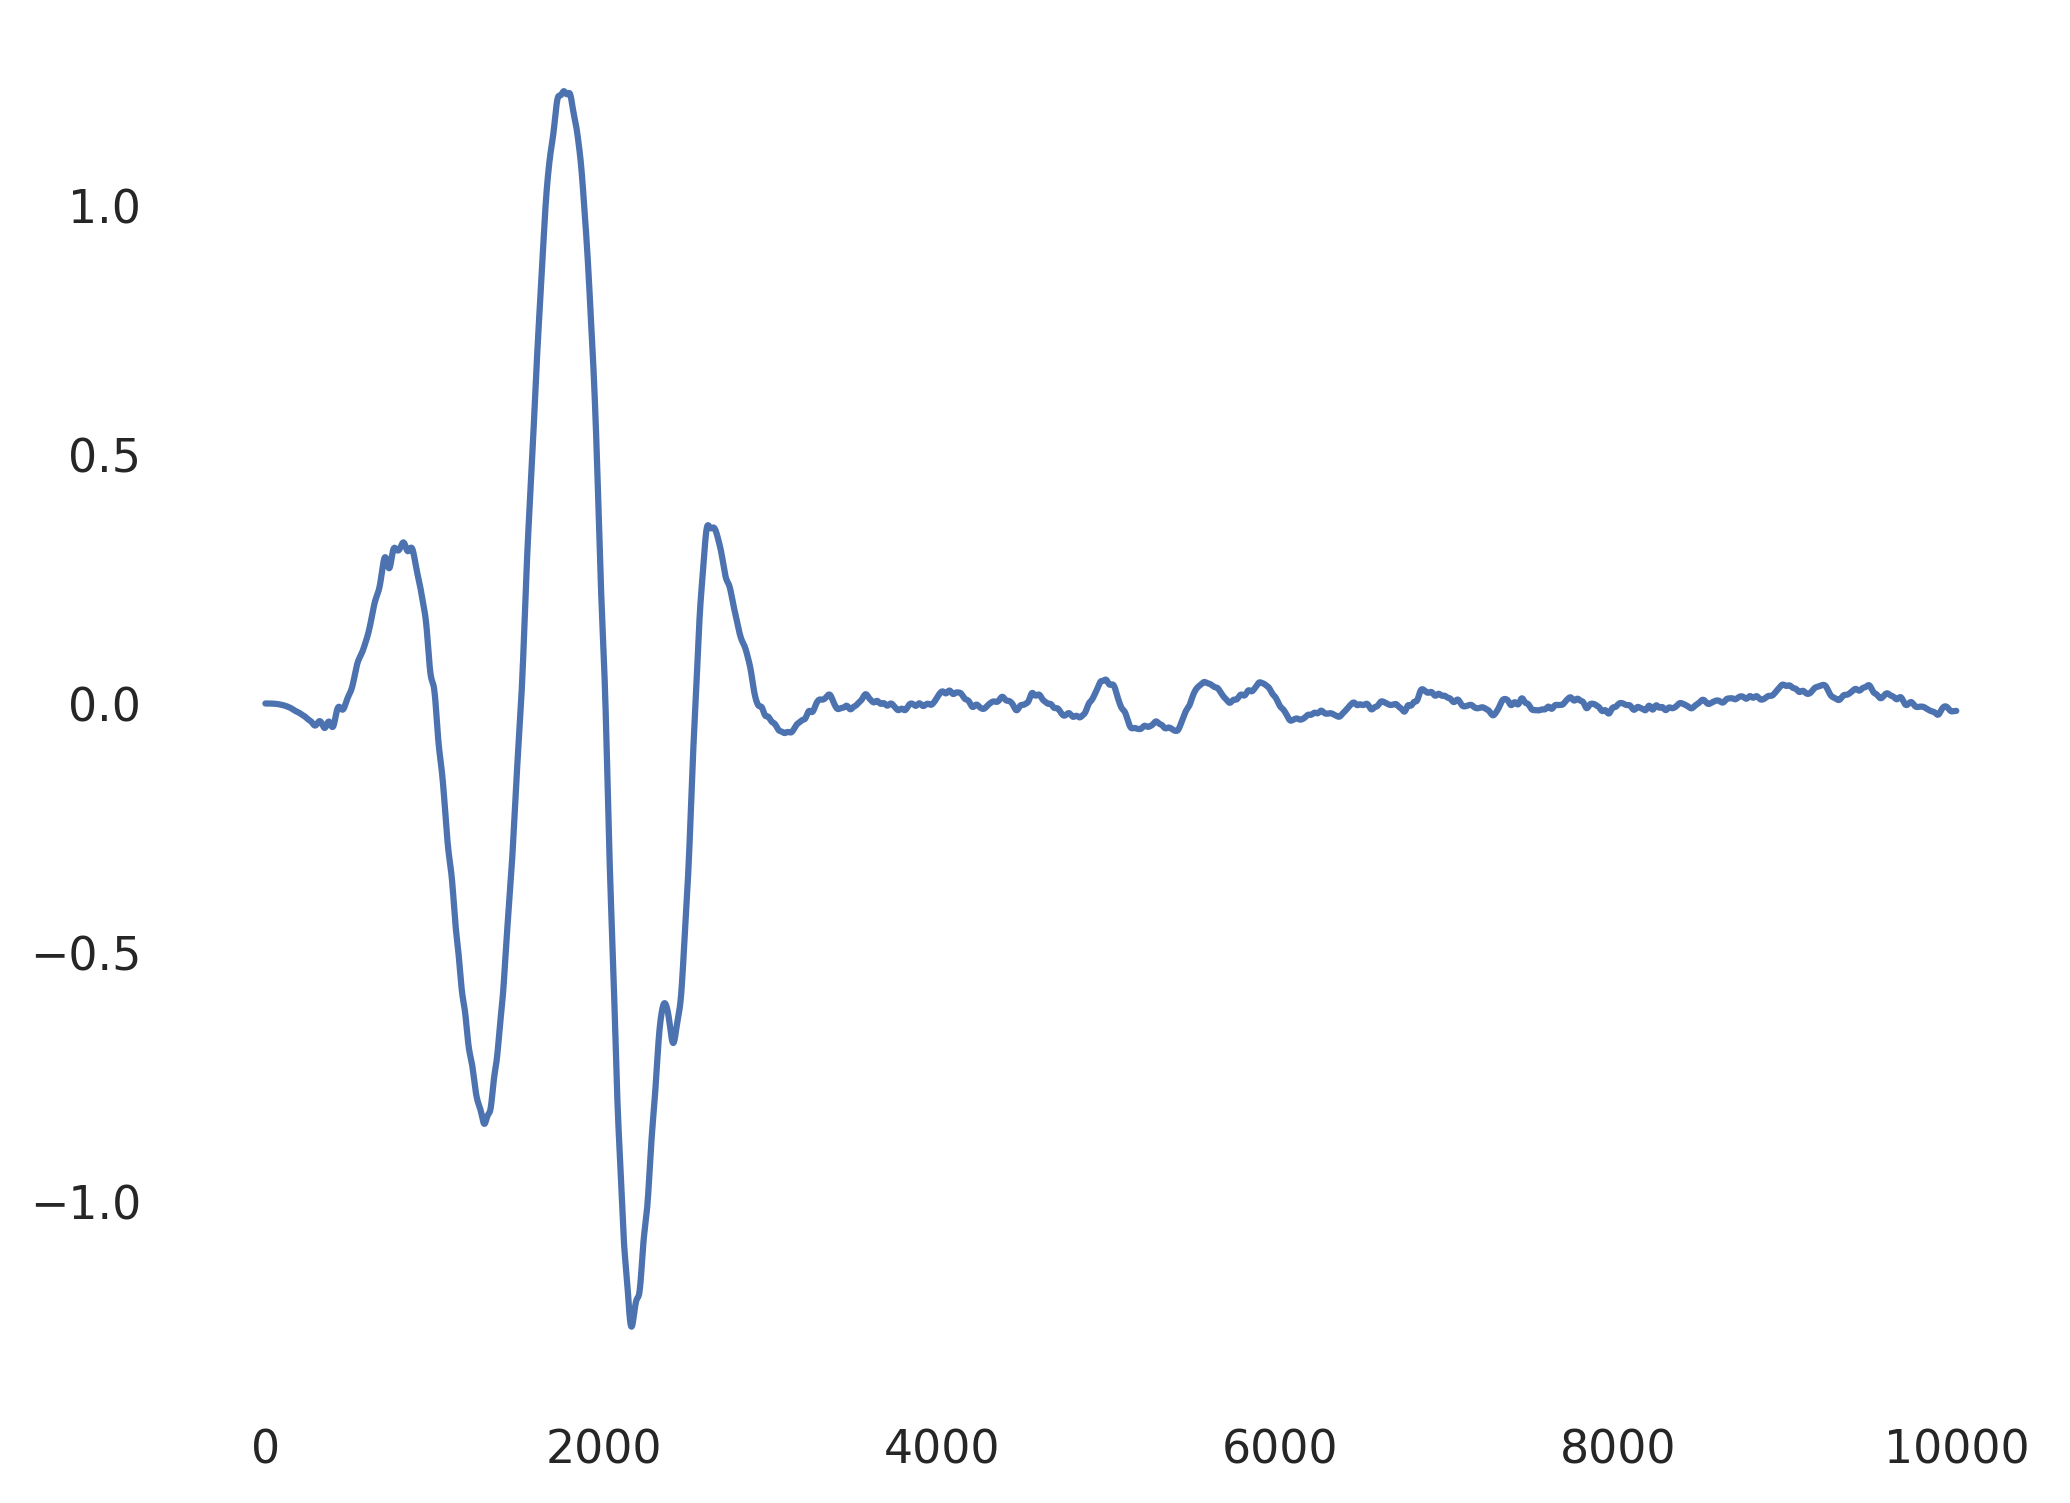

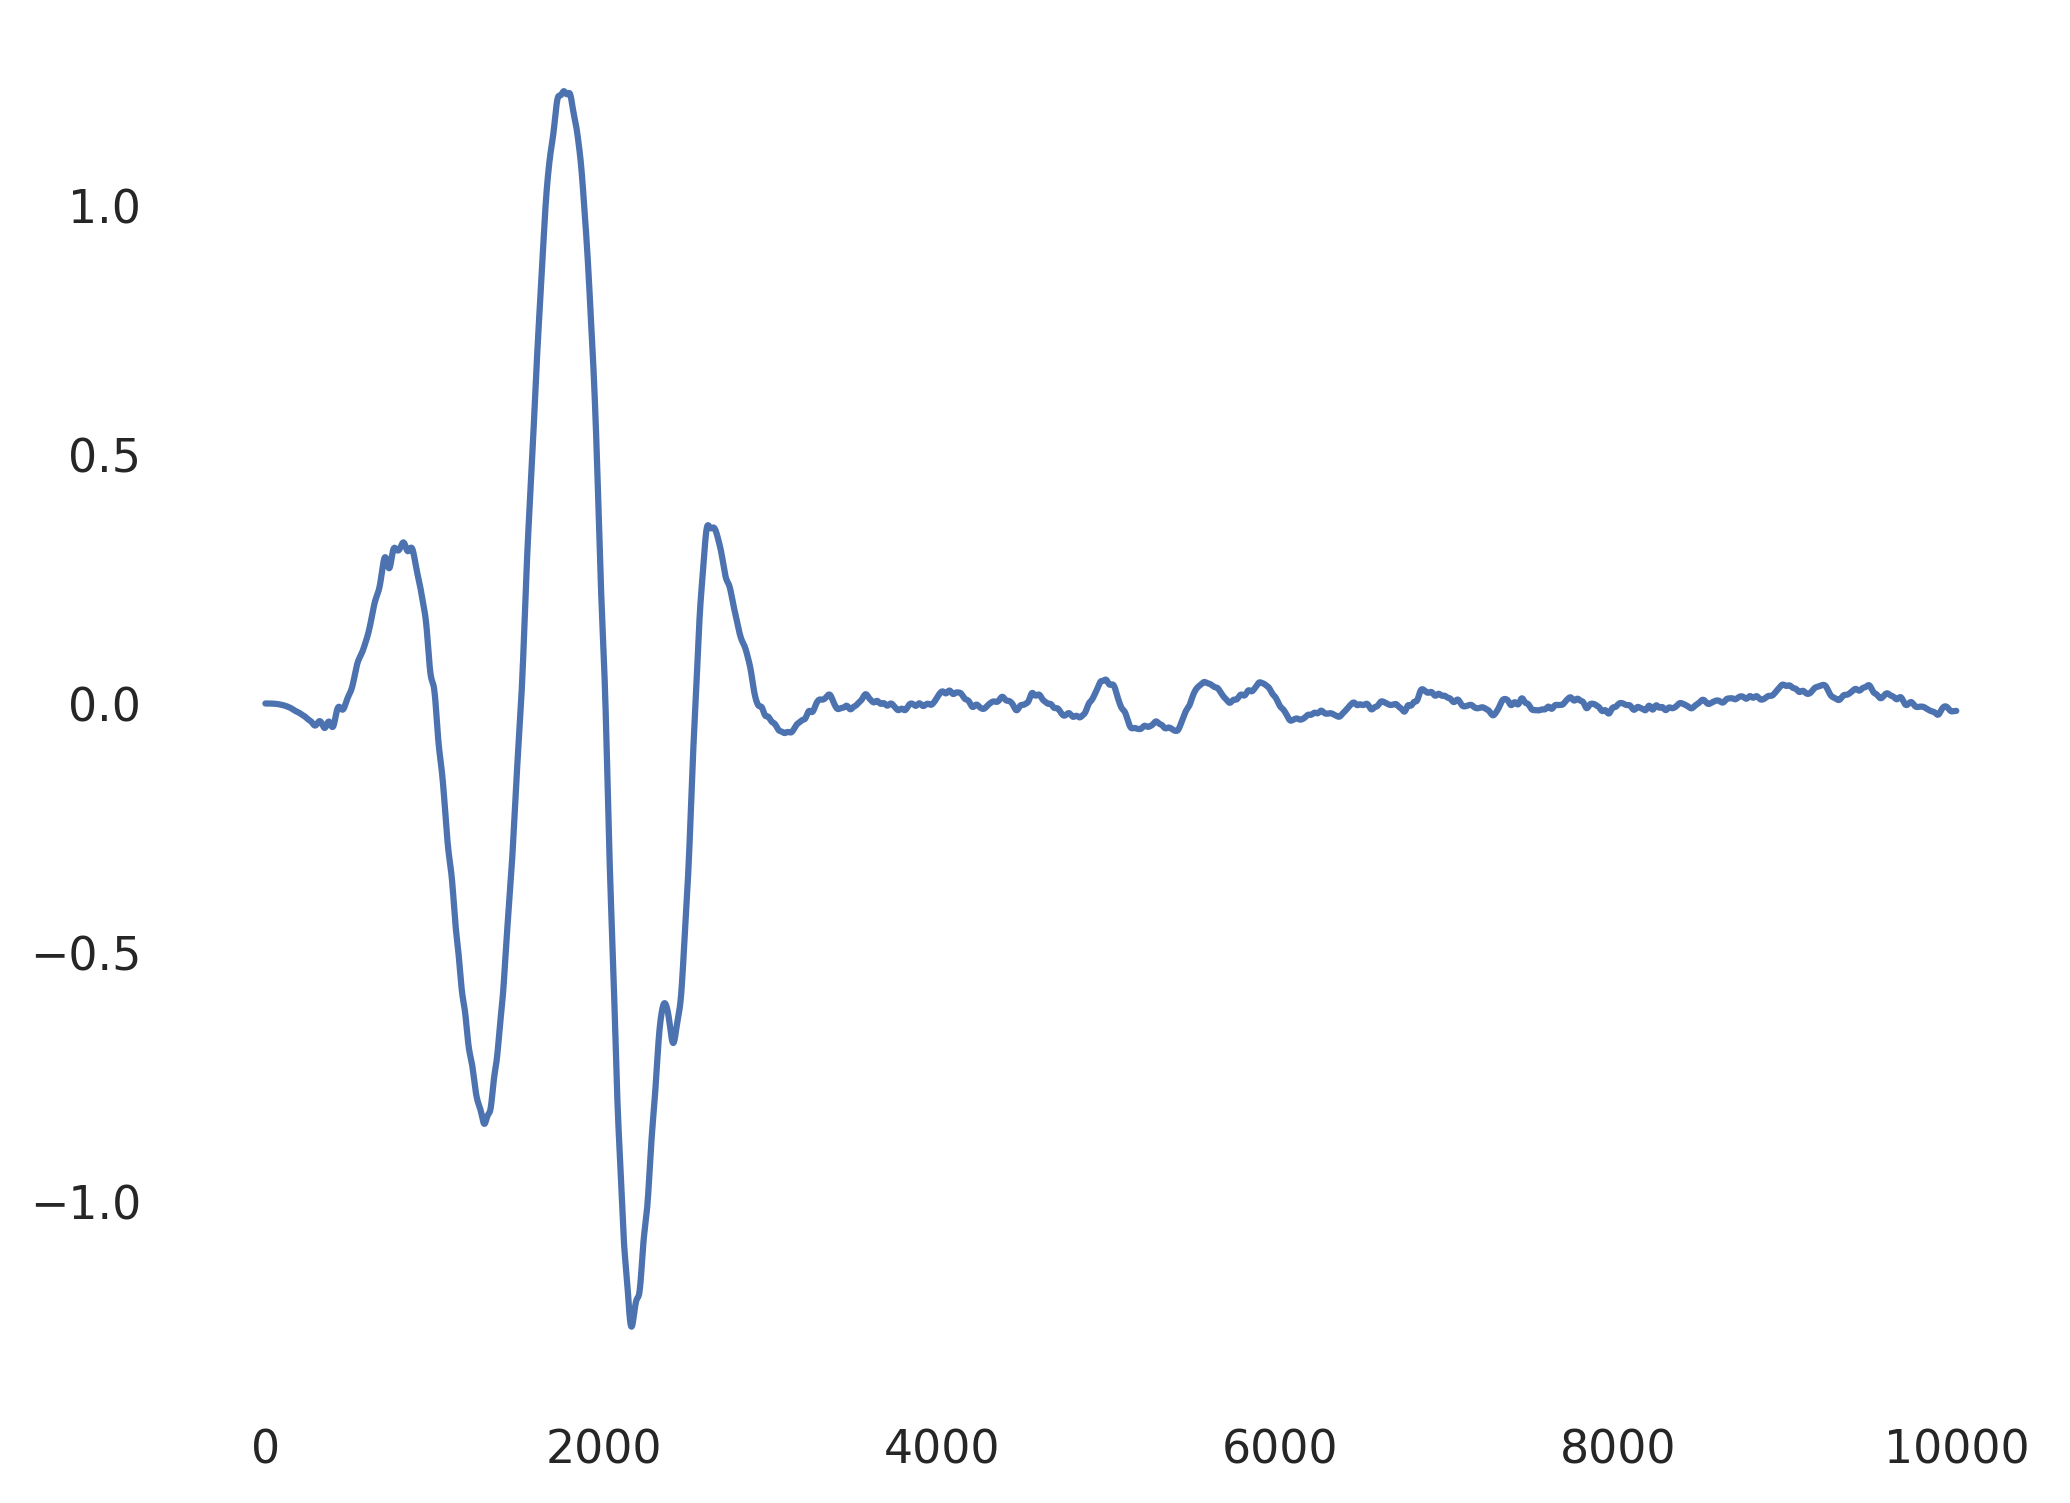

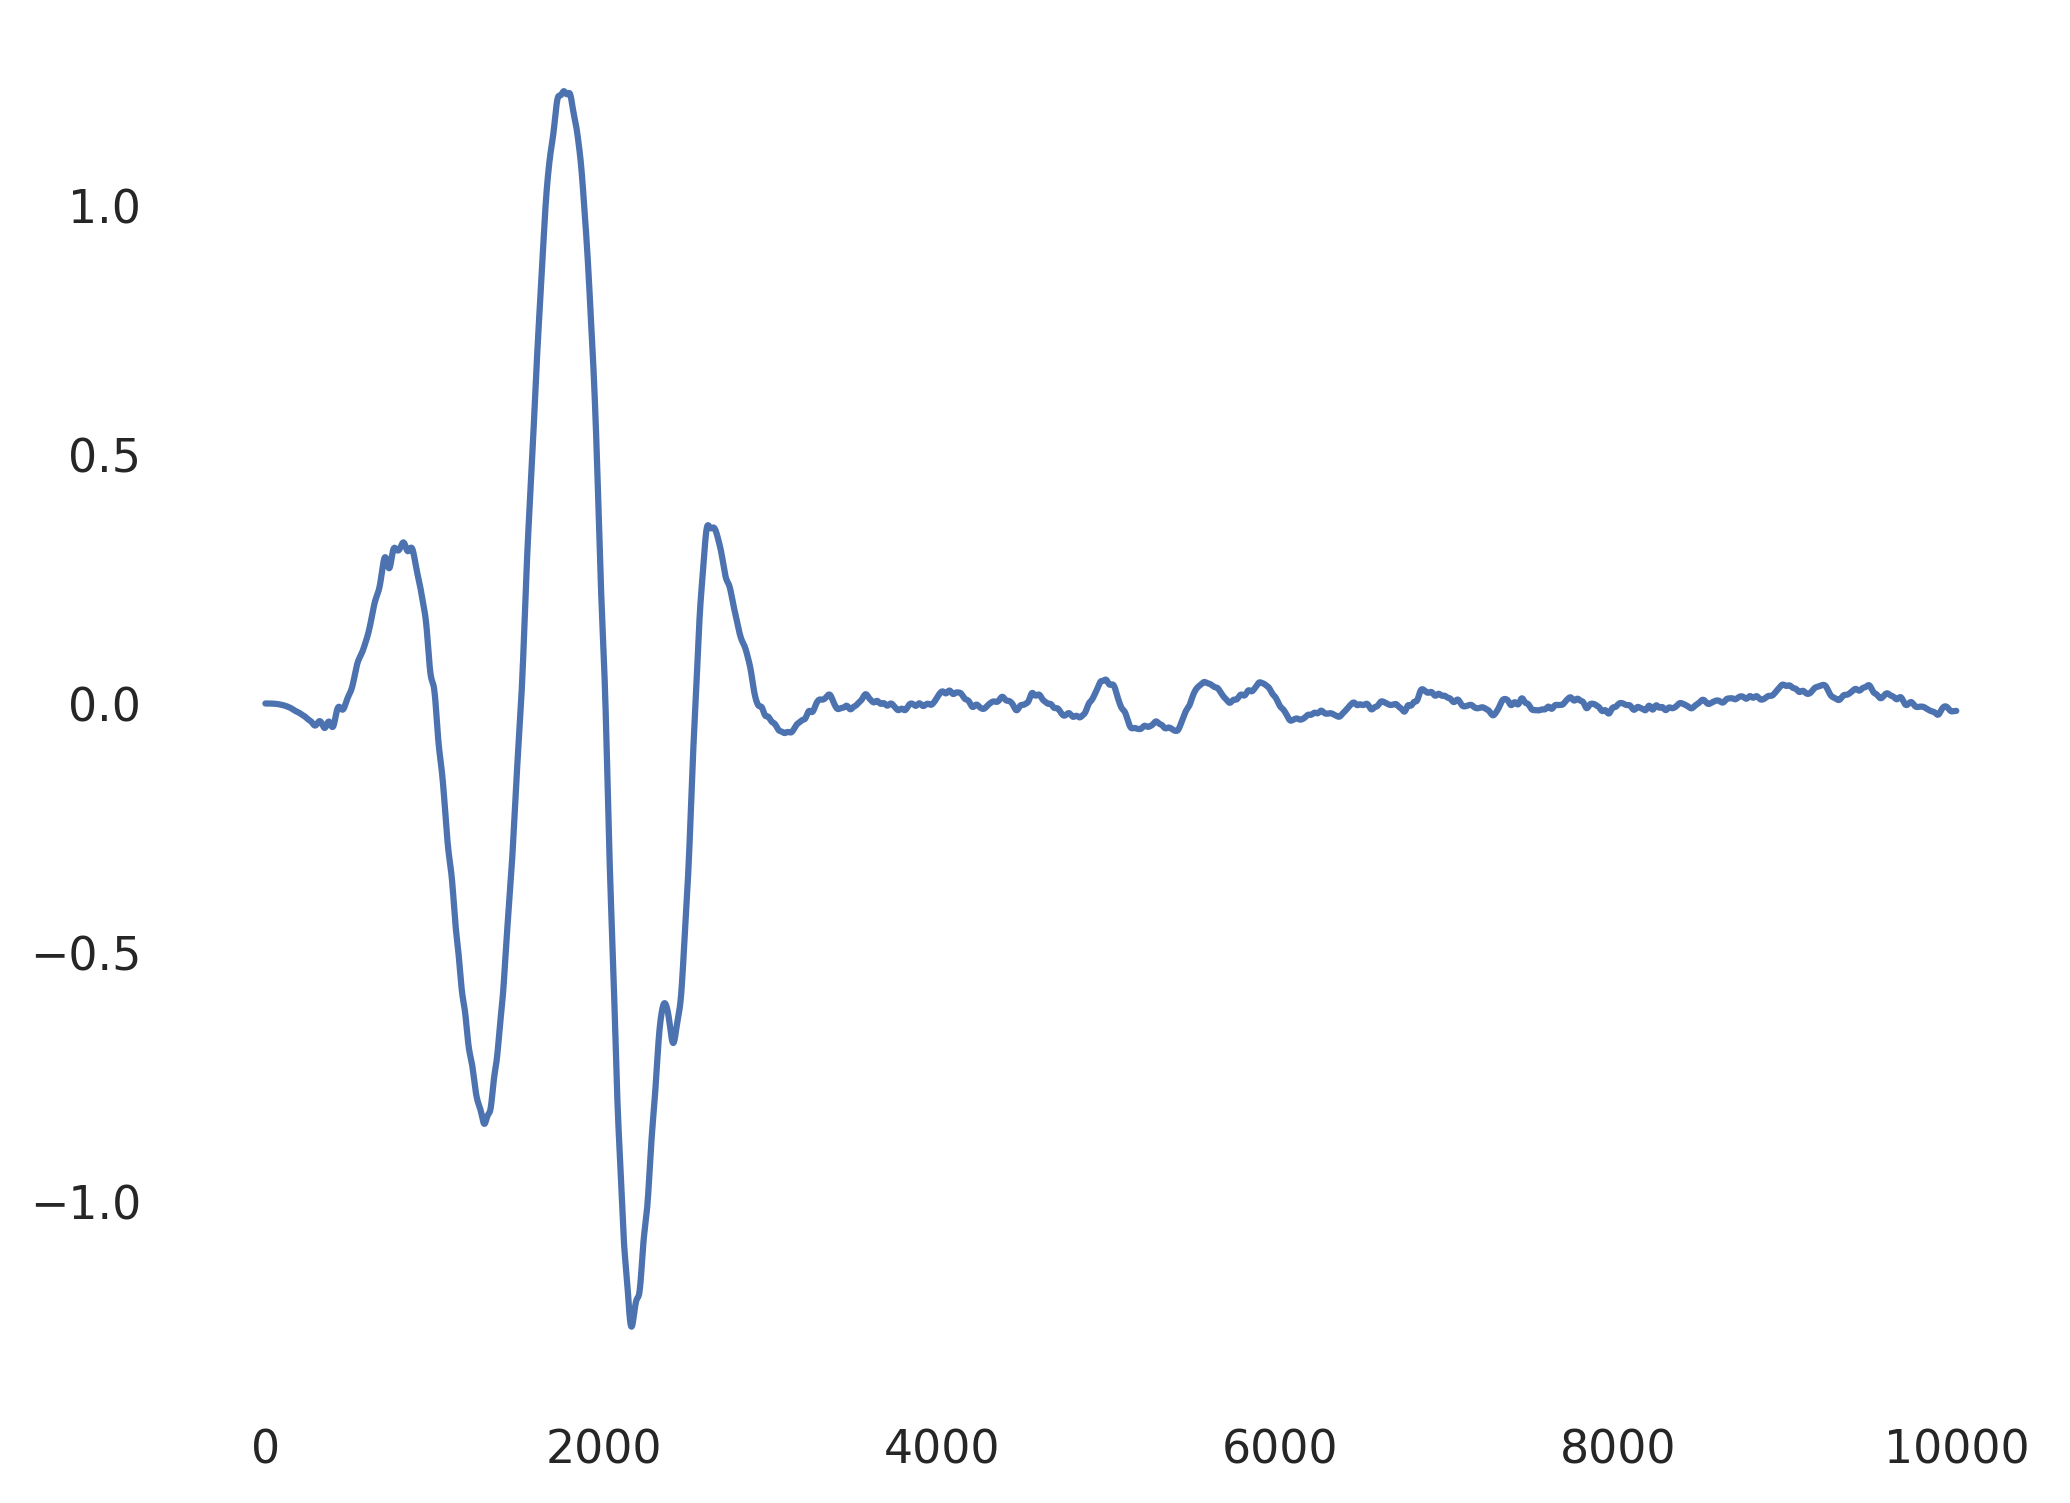

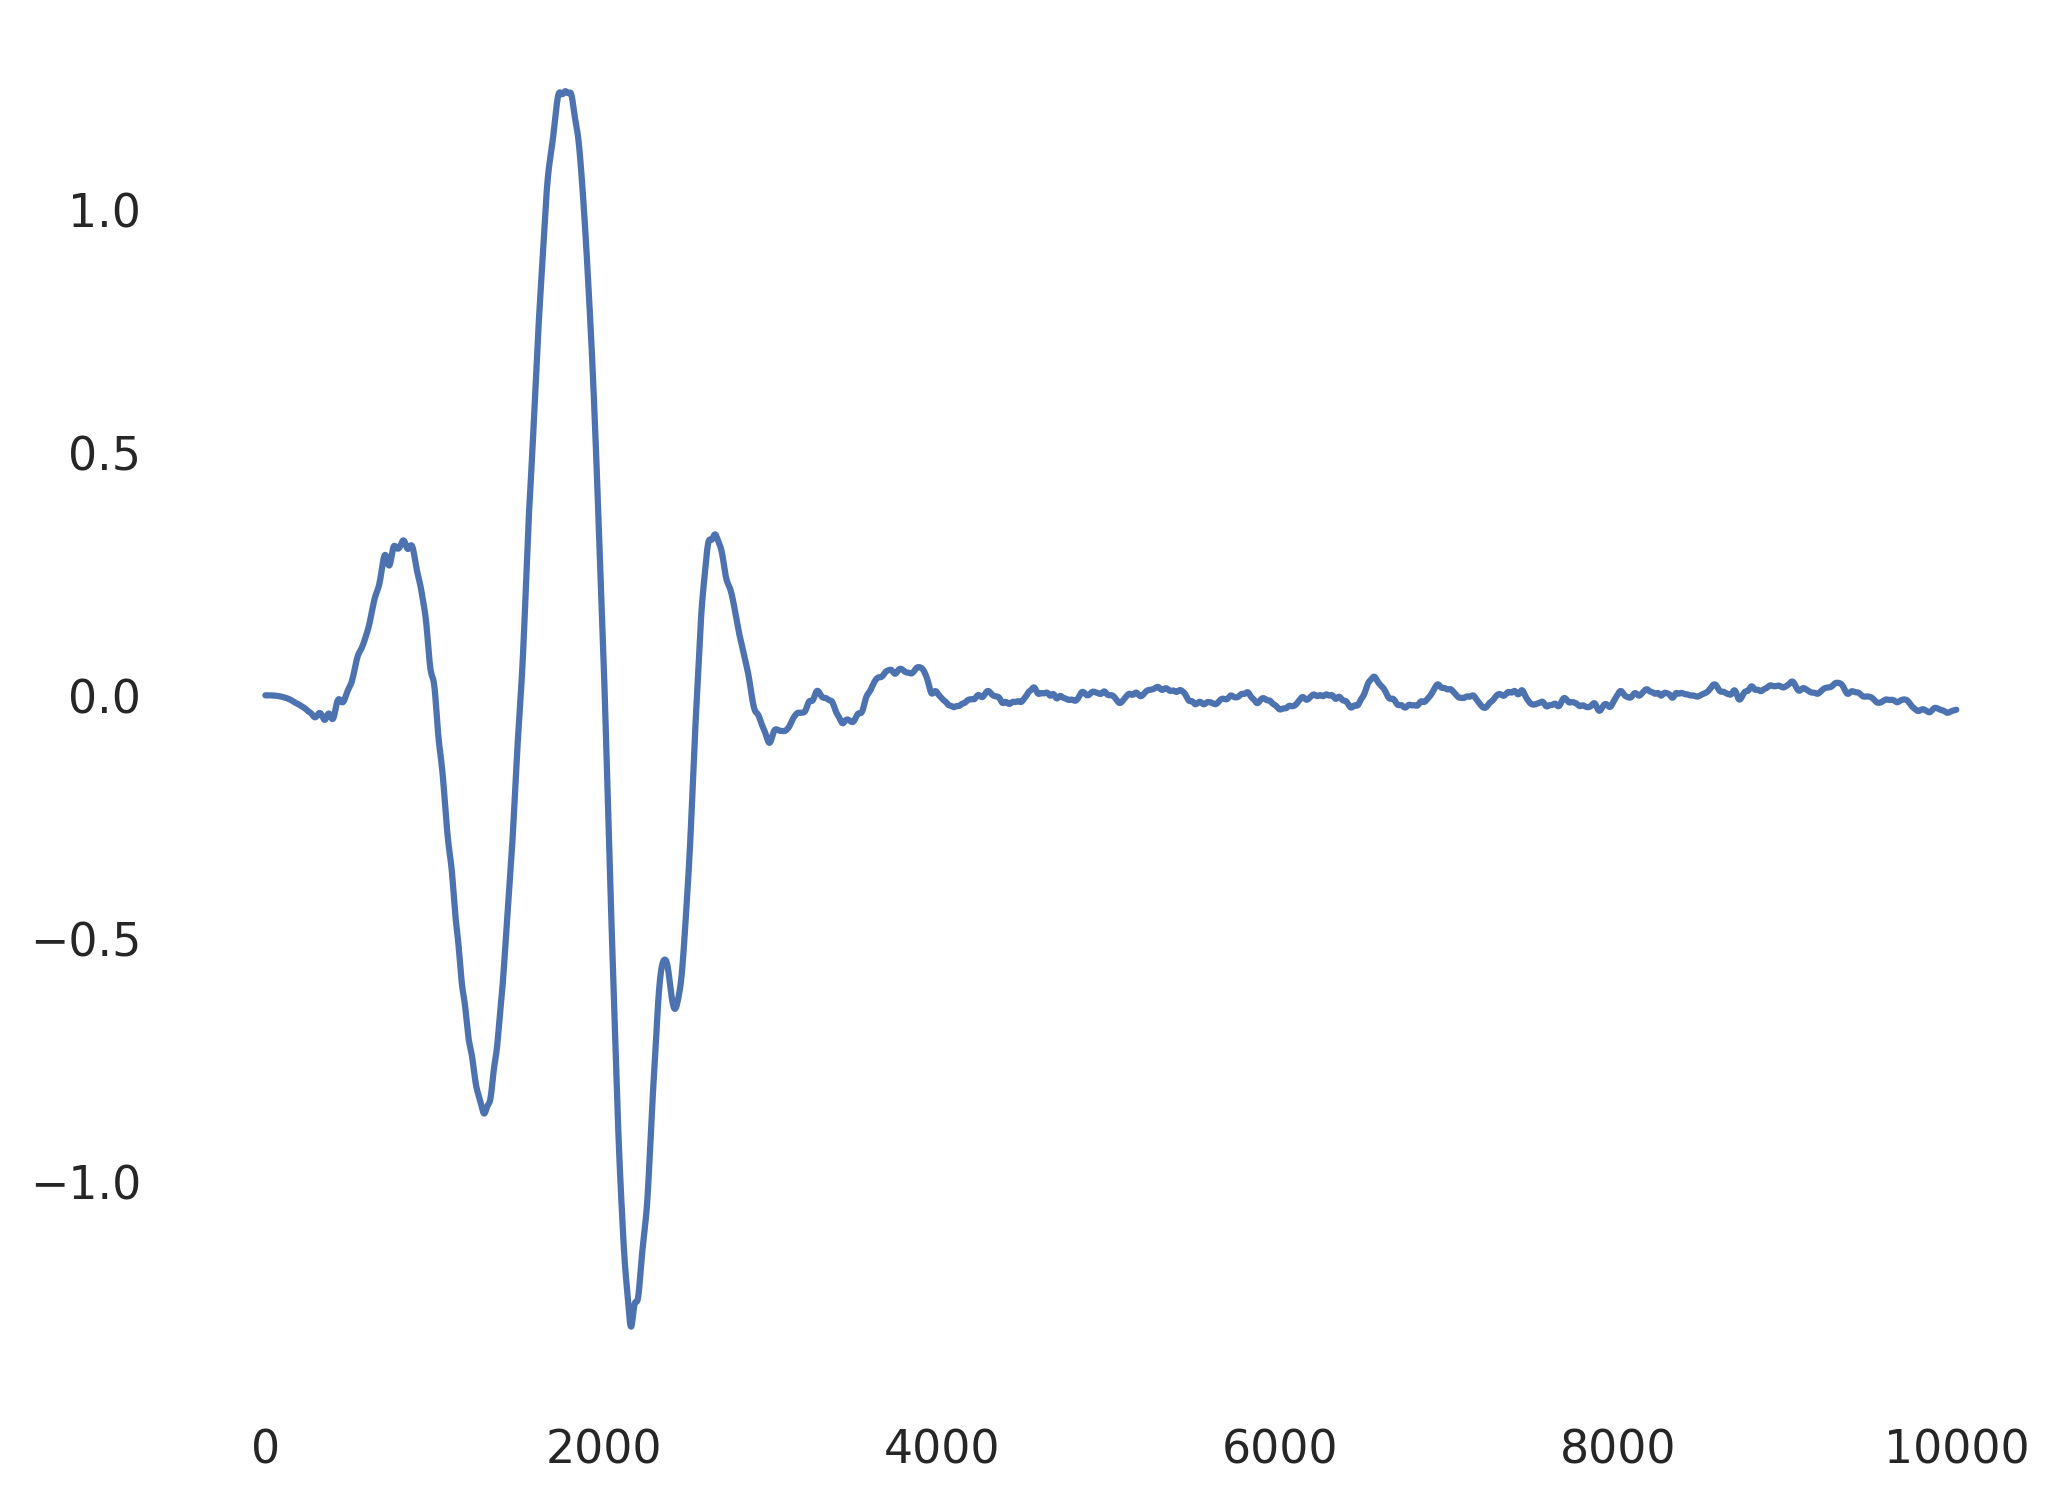

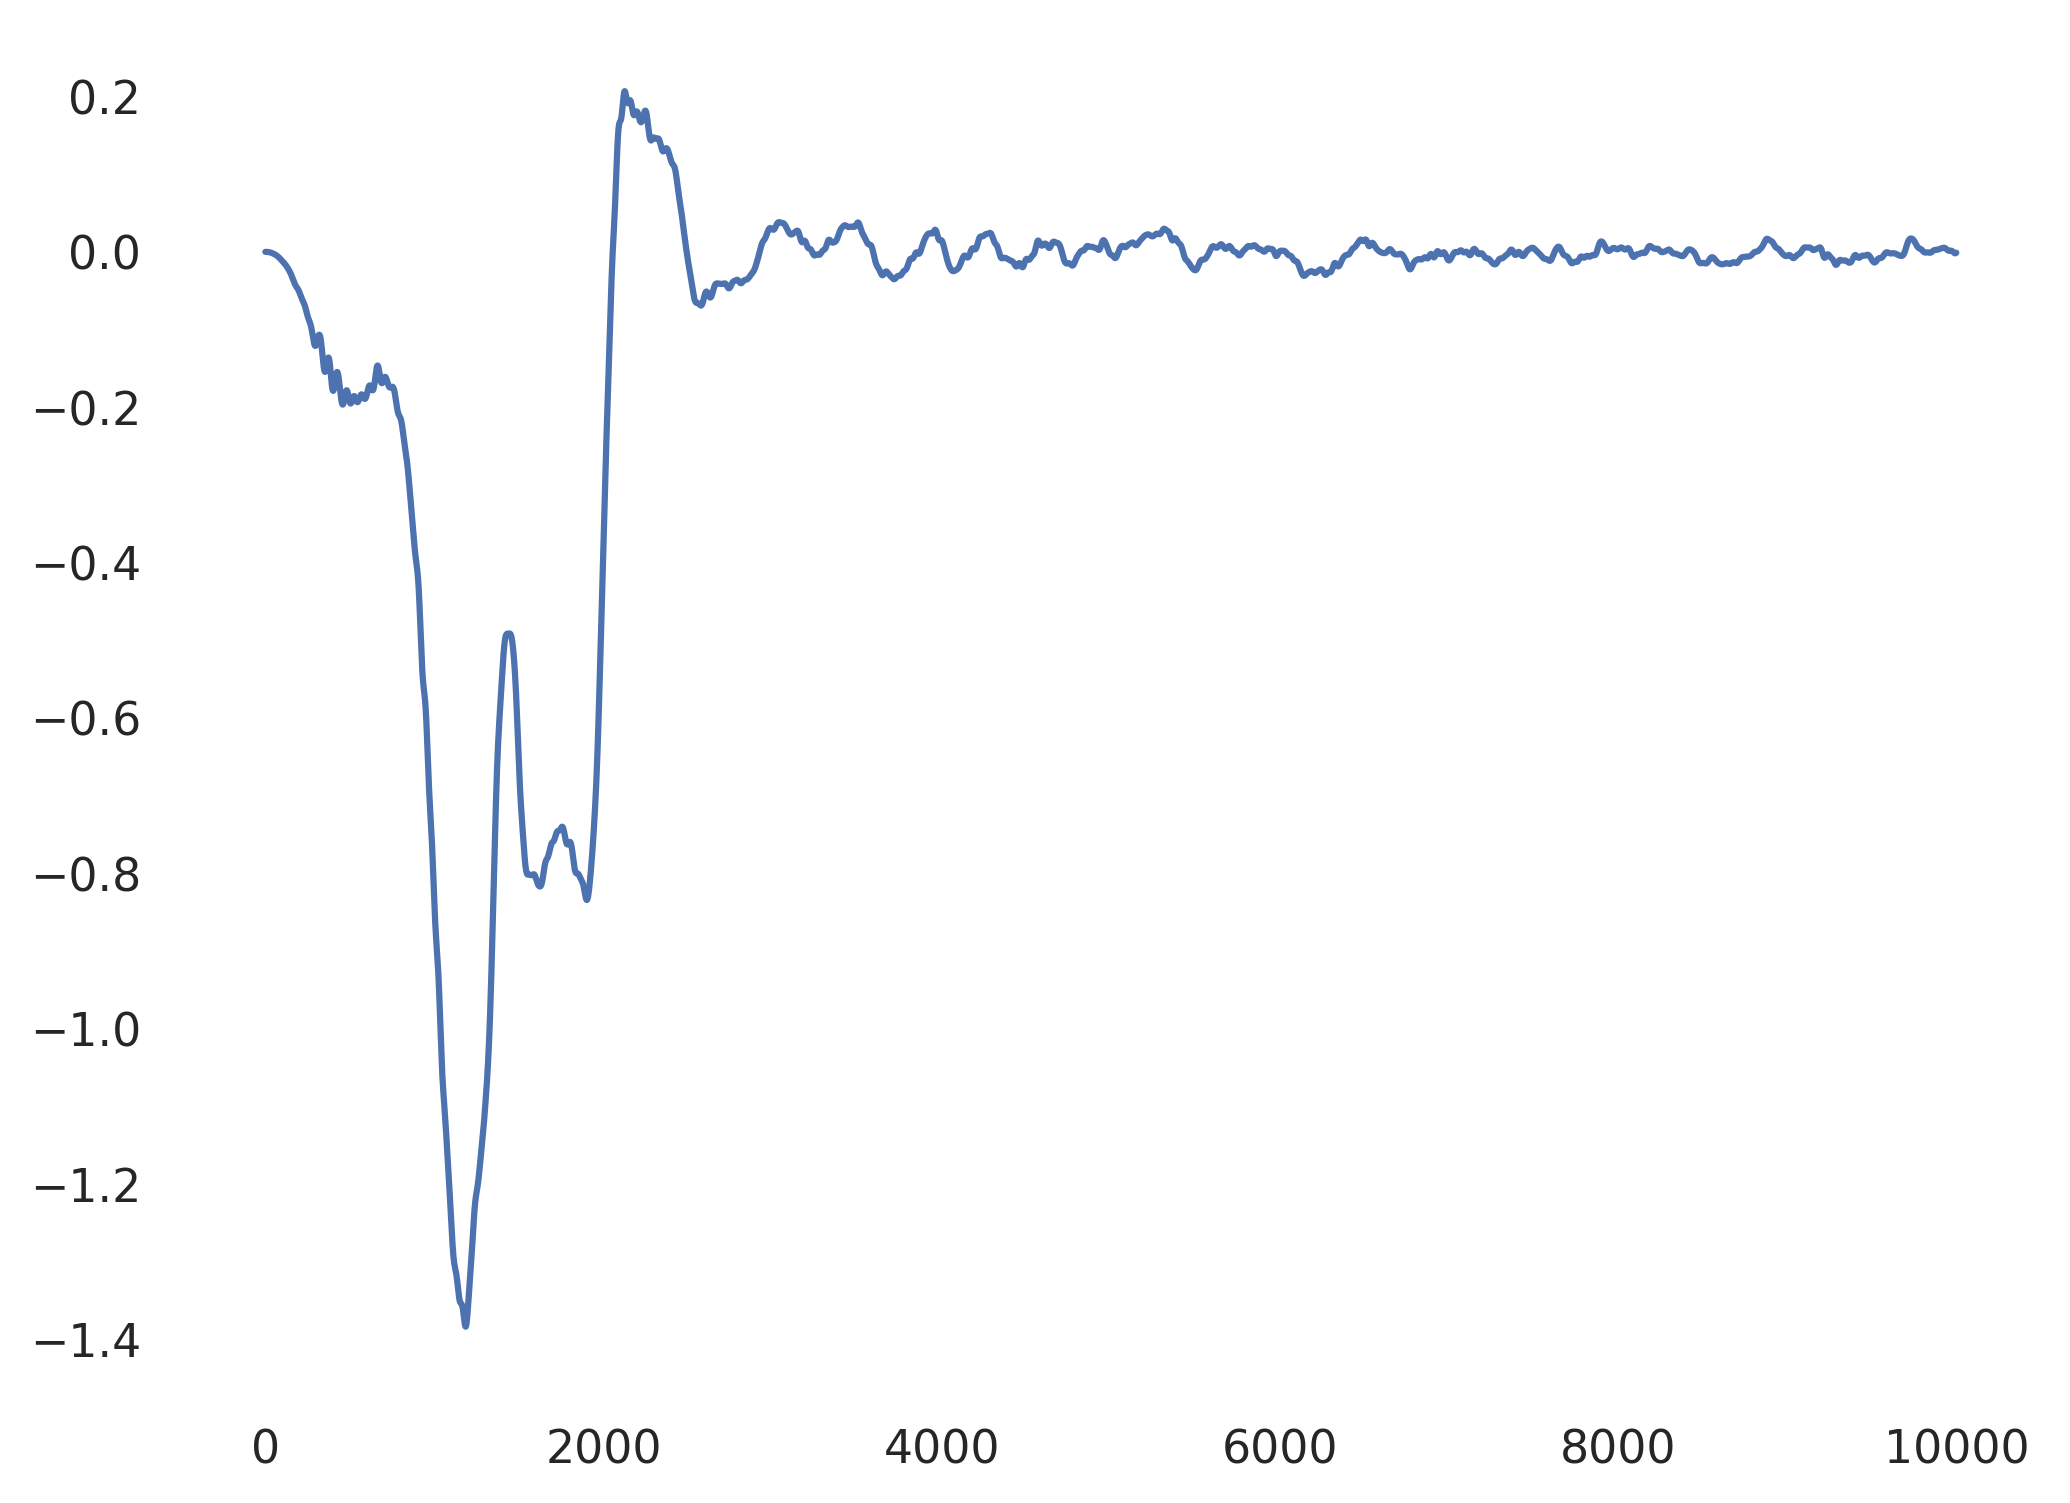

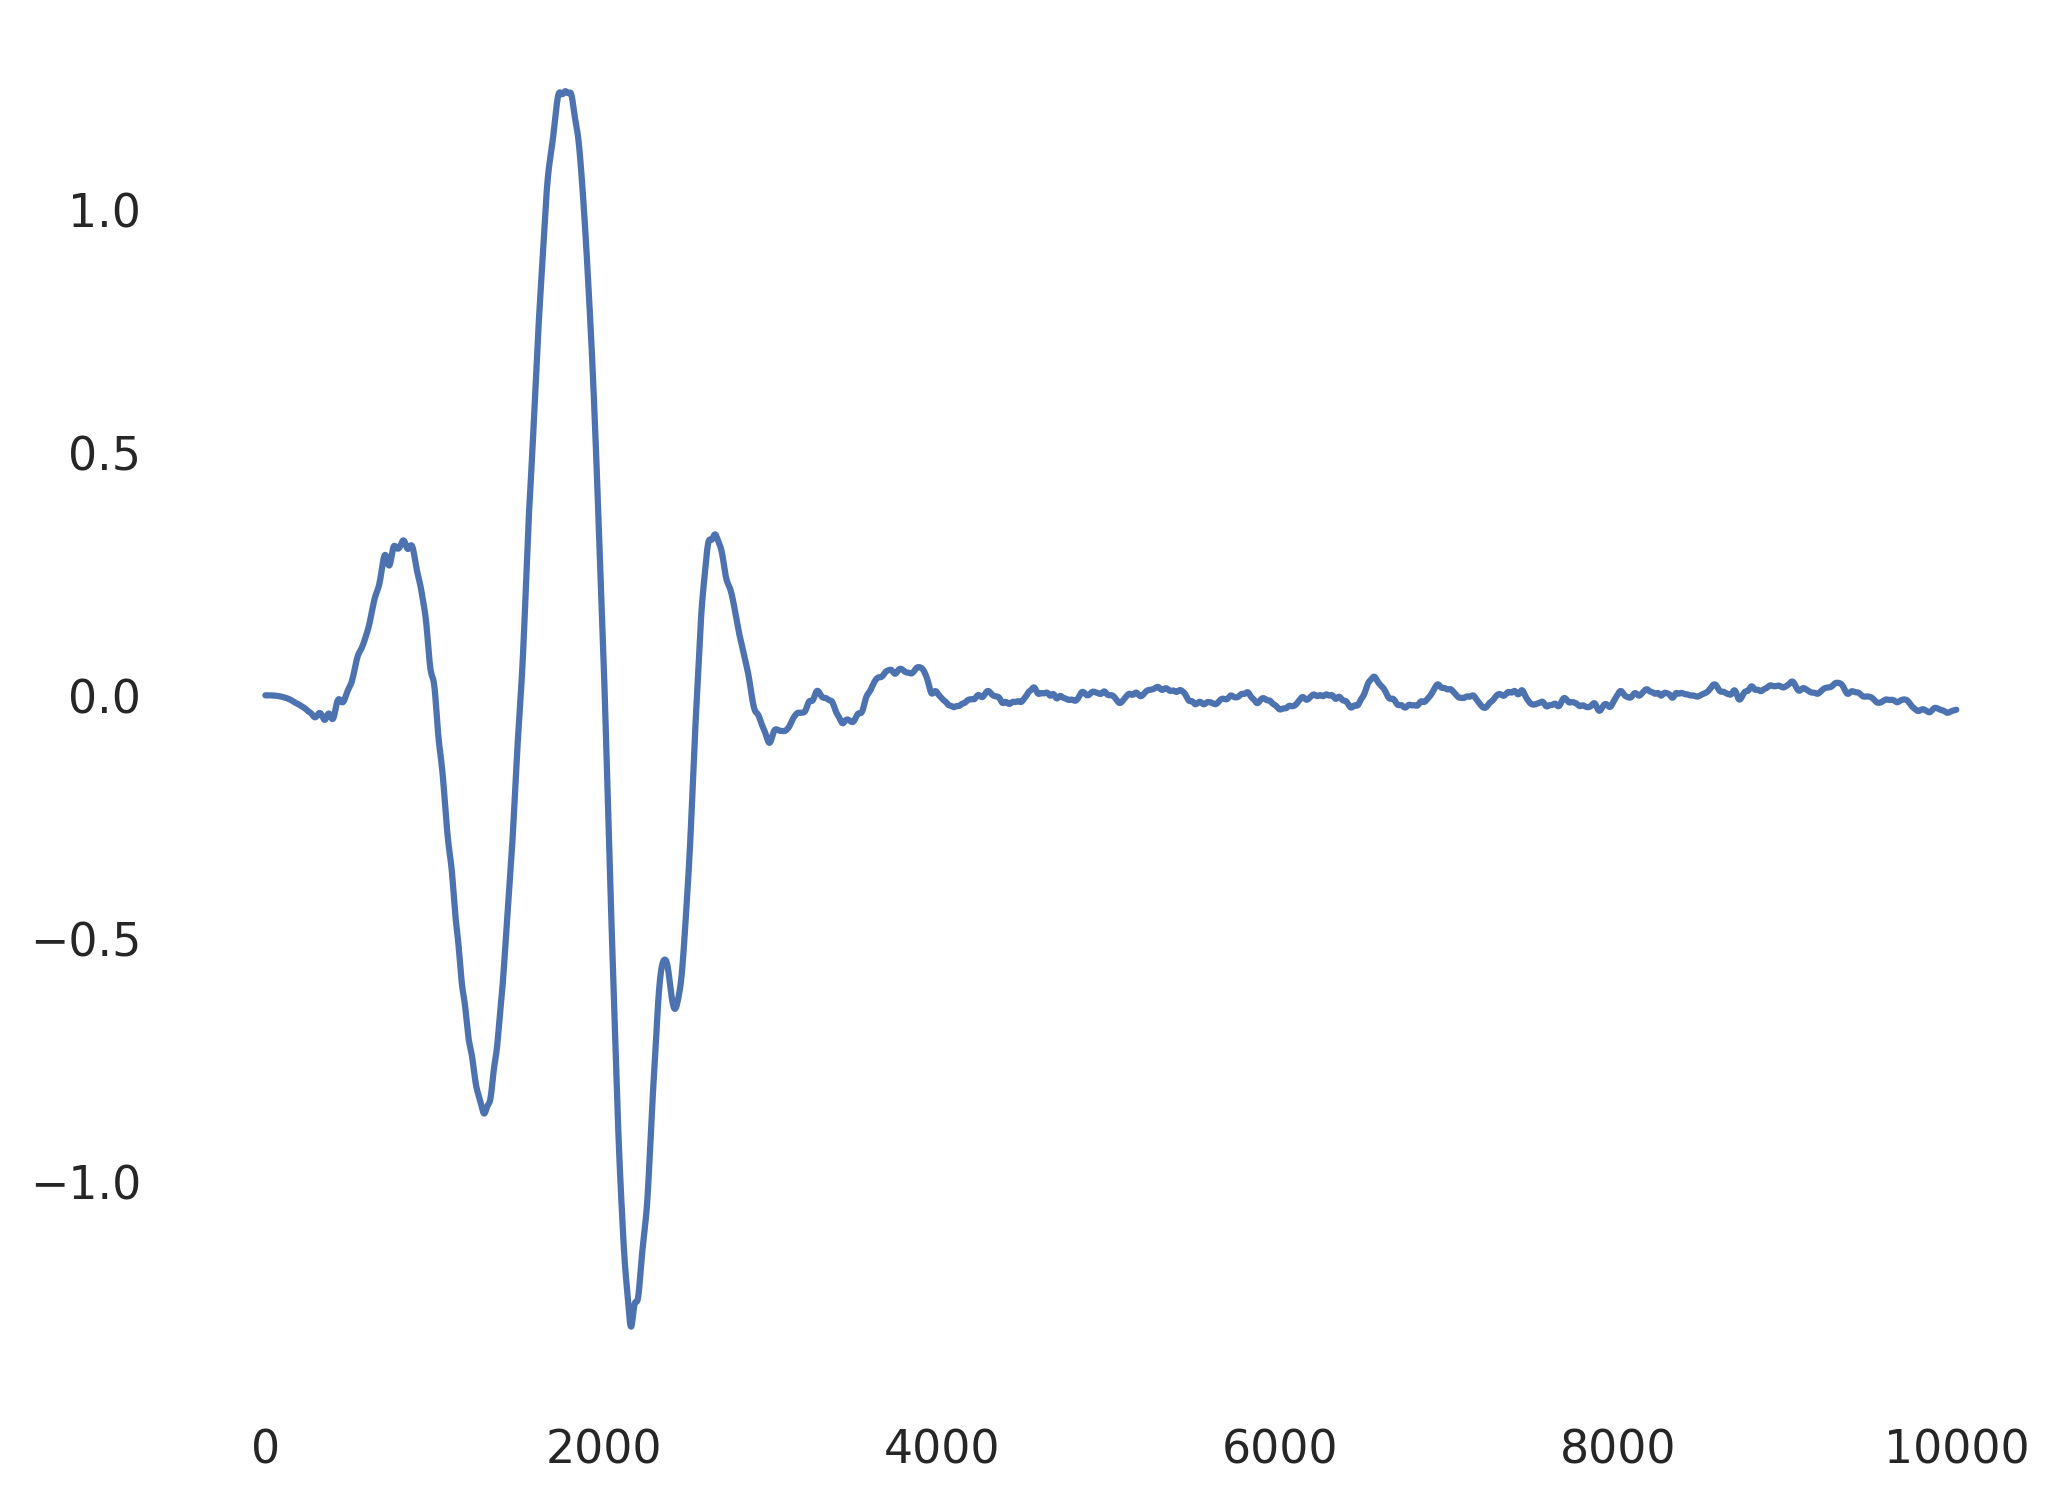

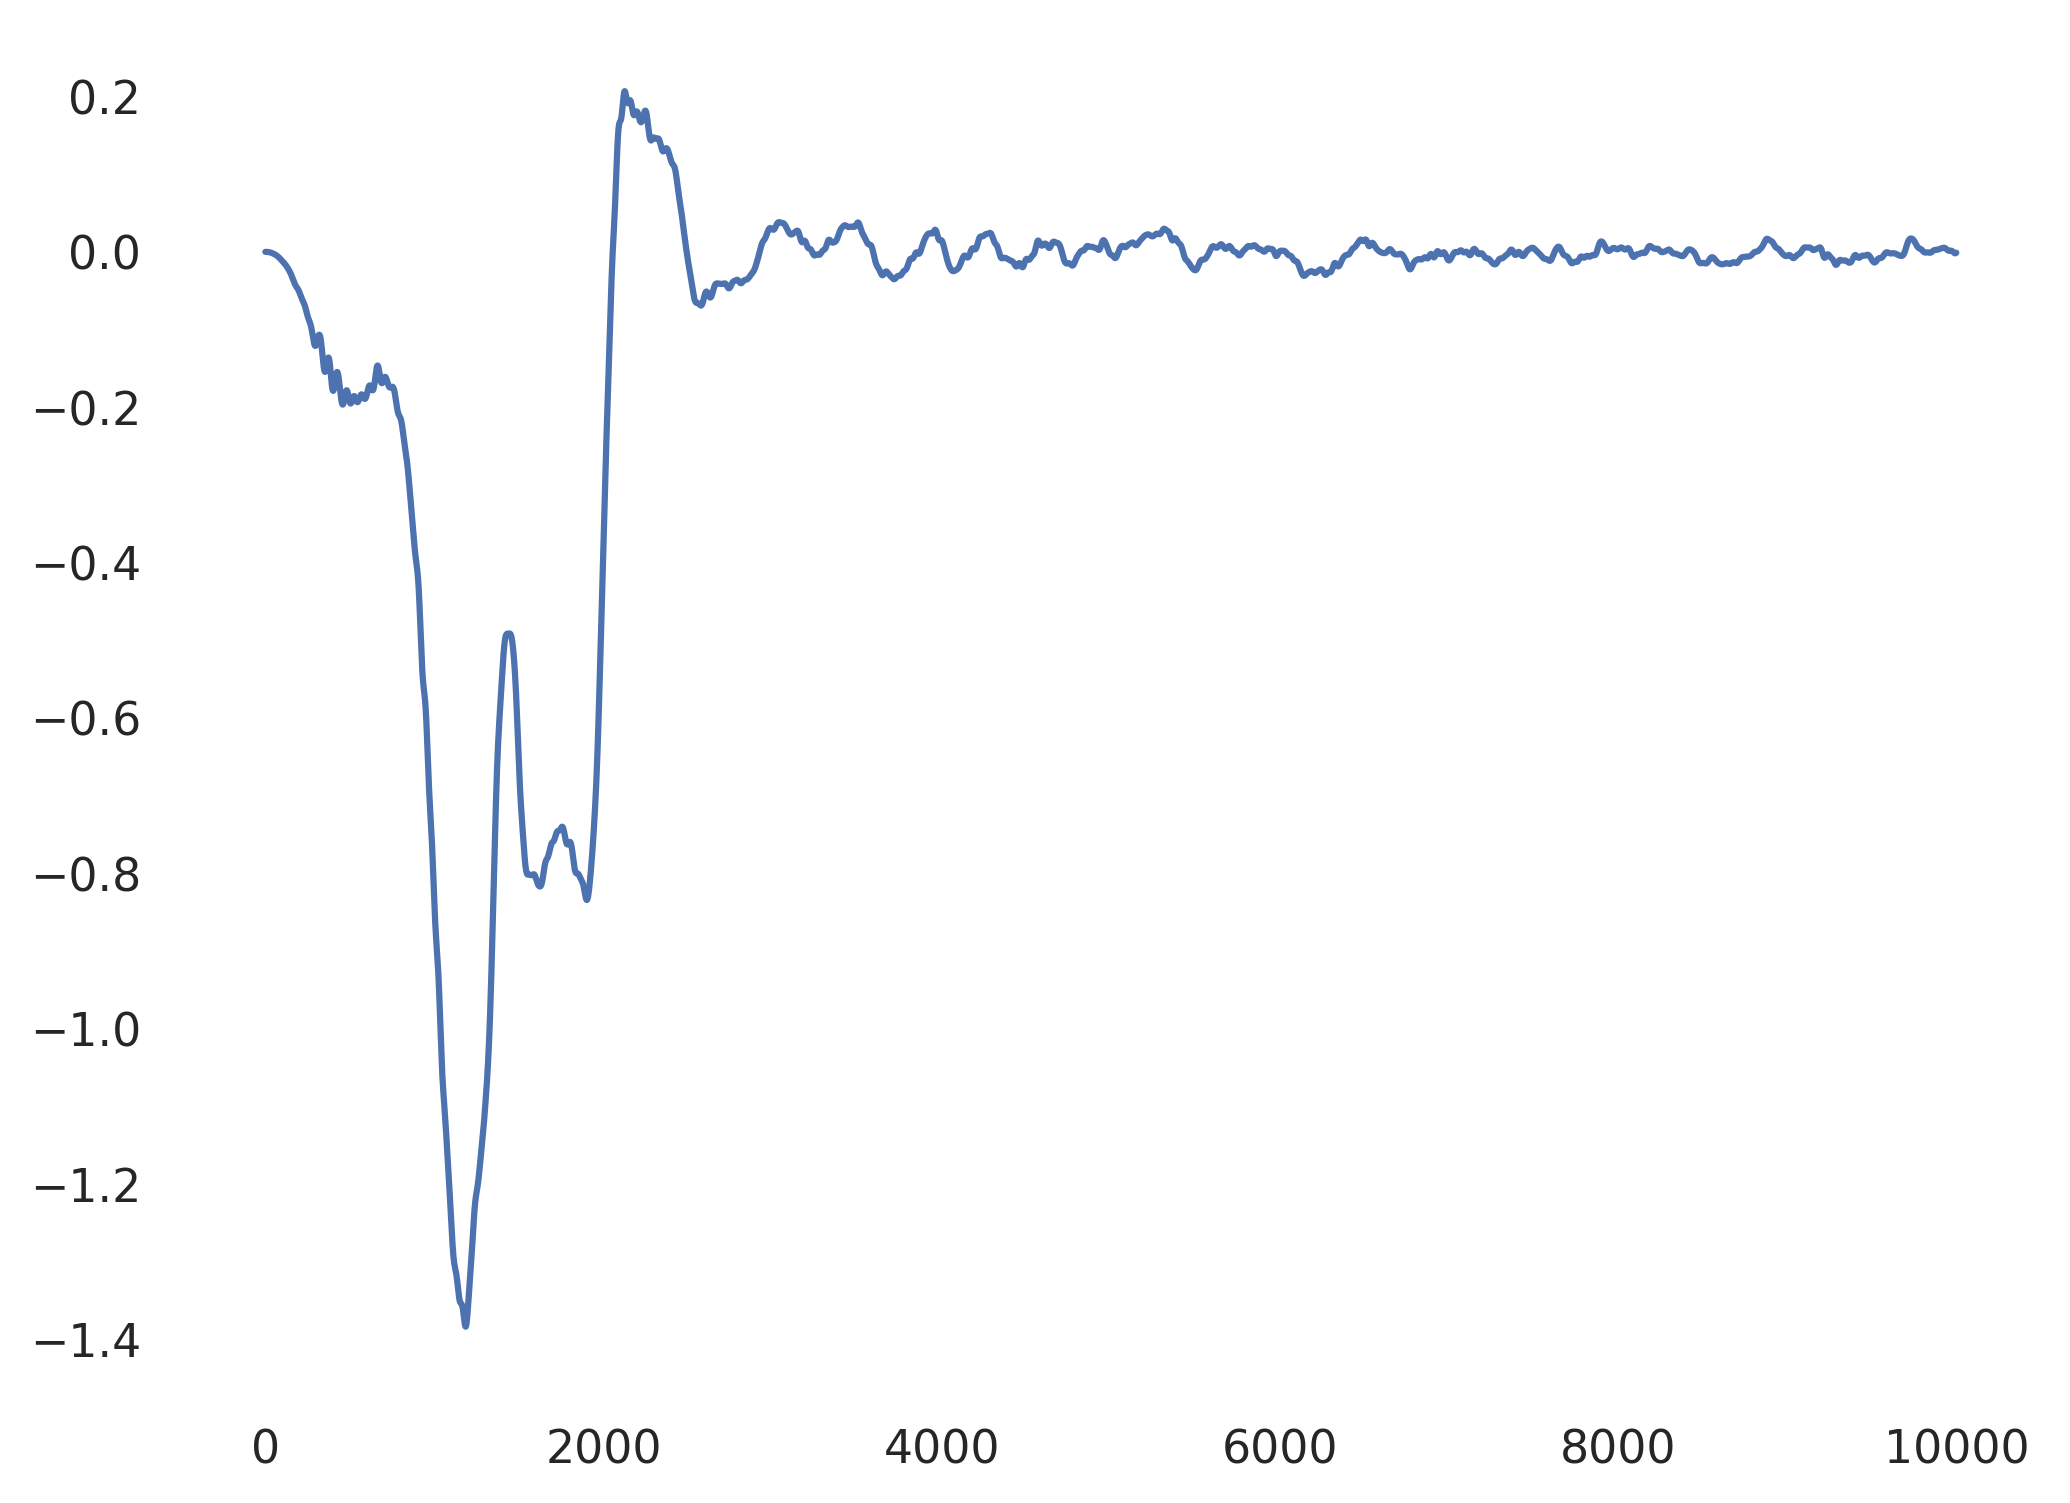

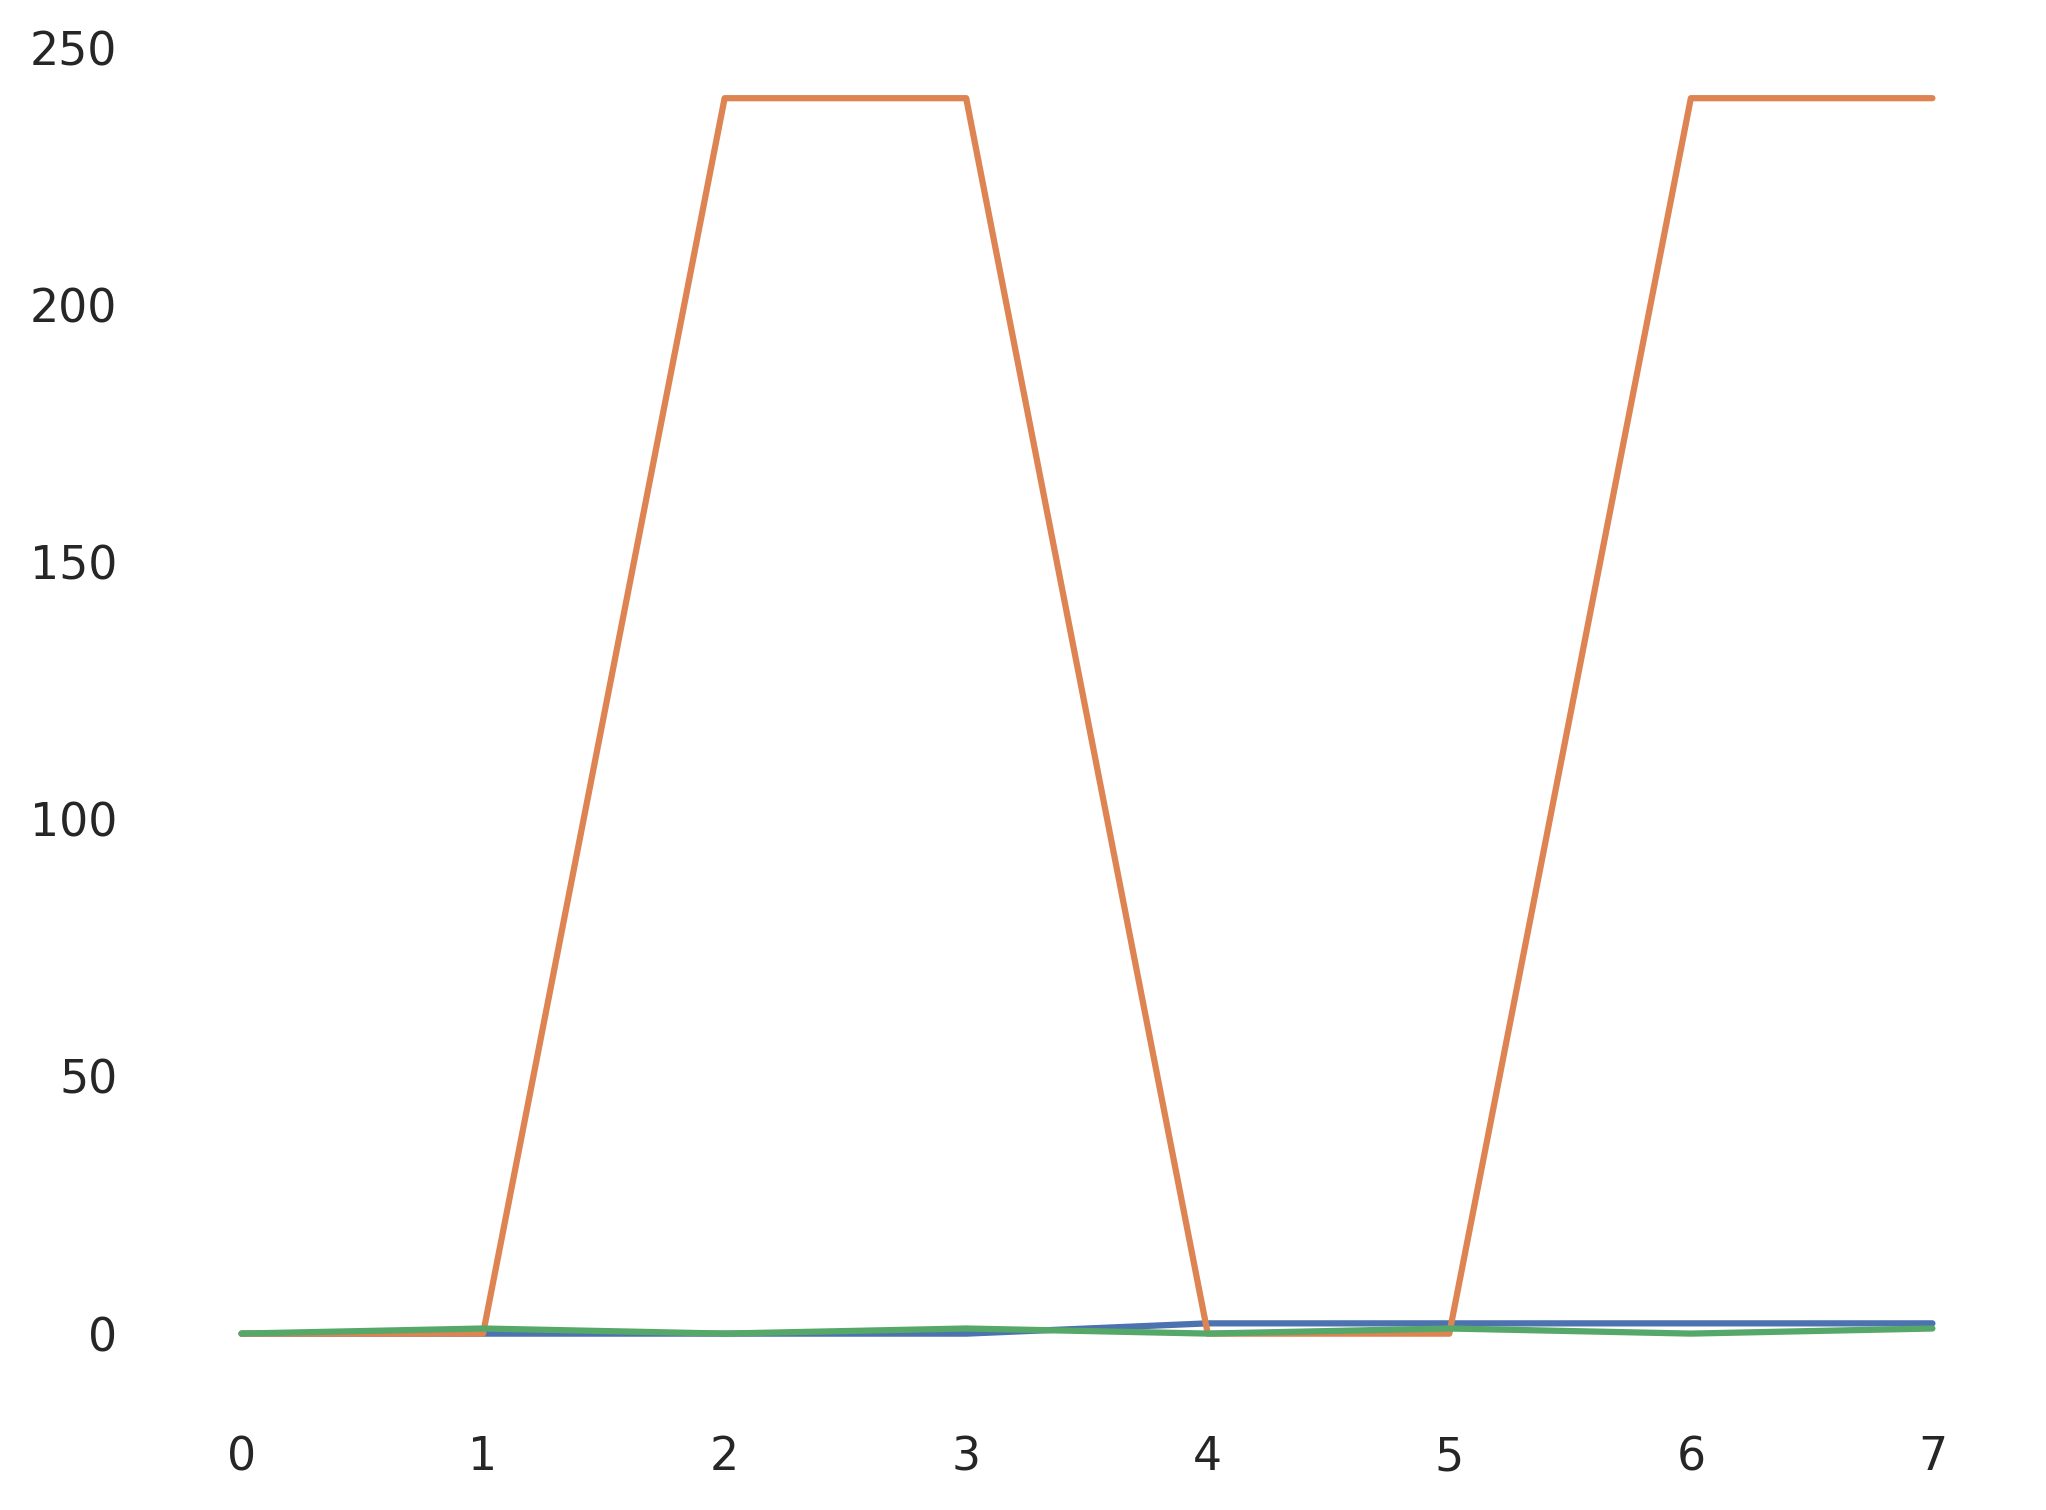

In [6]:
############################
#
# For plotting
#
############################

f = h5py.File('./Data/Looping/TESTLooping_8iterations-2,0maxamps-240,1maxdels-1,0maxfreqs-params_10sites-0,468U-0,52t0-10F0-4a-10cycles-10000steps.hdf5', 'r')
ls = list(f.keys())
print(np.array(ls).shape)
for _ in ls:
    plt.plot(np.array(f.get(_)[:]).real)
    plt.show()

In [2]:
field = 32.9  # field angular frequency THz
F0 = 10  # Field amplitude MV/cm
a = 4   # Lattice constant Angstroms

"""Parameters for a target or reference field"""
# Hubbard model
L = 10             # system size
N_up = L // 2 + L % 2   # number of fermions with spin up
N_down = L // 2     # number of fermions with spin down
N = N_up + N_down   # number of particles
t0 = 0.52       # hopping strength
U = 0.9 * t0    # interaction strength
pbc = True

# Parameters for evolving the system
cycles = 10     # time in cycles of field frequency
n_steps = 10000  # Number of steps for time resolution

# Bundle parameters to pass to Hubbard Model class for unit conversion
tgt_params = dict(
    nx=L,
    hopping=t0,
    interaction=U,
    n_up=N_up,
    n_down=N_down,
    angular_frequency=field,
    lattice_constant=a,
    field_amplitude=F0,
    chem_potential=0,
    cycles=cycles,
    n_steps=n_steps,
    ny=0,       # 1D simulations do not use y-axis
    soc=0,      # No spin orbit coupling
    gamma=0     #
)

# get the converted units for creating a target field
tgt = fhmodel(**tgt_params)

start = 0.0
stop = tgt.stop
times, dt = np.linspace(start, stop, num=n_steps, endpoint=True, retstep=True)

In [3]:
#file = "./Data/Looping/TESTLooping_1728iterations-2,0maxamps-240,1maxdels-1,0maxfreqs-params_10sites-0,468U-0,52t0-10F0-4a-10cycles-10000steps.hdf5"
file = './Data/Looping/Looping_CorrectedSweep.hdf5'
file2 = np.load('./Data/TargetsForTracking/TGTparams_10sites-0,416U-0,52t0-10F0-4a-10cycles-10000steps.npz')
file3 = np.load('./Data/TargetsForTracking/TGTparams_10sites-0,520U-0,52t0-10F0-4a-10cycles-10000steps.npz')
key = []
key.clear()
print(key)

file1 = dict() # {'comp_J': np.real(file2['current'])}

with h5py.File(file, 'r') as fin:
    ls = fin.keys()
    for _ in ls:
        if _ != 'master_params':
            key.append(_)
            file1[_]= np.real(fin[_][:])
#for _ in ls:
#    print("Run with params: {} finished".format(_))
    print(key)

diff=0
"""    diff = [
        [np.linalg.norm(J1[...] - J2[...]) for name1, J1 in fin.items() if name1 != 'params']
        for name2, J2 in fin.items() if name2 != 'params'
    ]"""



[]
['[0.5, 0.6283185307179586, 0.1]', '[0.5, 0.6283185307179586, 0.2]', '[0.5, 0.6283185307179586, 0.3]', '[0.5, 0.6283185307179586, 0.4]', '[0.5, 0.6283185307179586, 0.5]', '[0.5, 0.6283185307179586, 0.6]', '[0.5, 0.6283185307179586, 0.7]', '[0.5, 0.6283185307179586, 0.8]', '[0.5, 0.6283185307179586, 0.9]', '[0.5, 0.6283185307179586, 1.0]', '[0.5, 1.2566370614359172, 0.1]', '[0.5, 1.2566370614359172, 0.2]', '[0.5, 1.2566370614359172, 0.3]', '[0.5, 1.2566370614359172, 0.4]', '[0.5, 1.2566370614359172, 0.5]', '[0.5, 1.2566370614359172, 0.6]', '[0.5, 1.2566370614359172, 0.7]', '[0.5, 1.2566370614359172, 0.8]', '[0.5, 1.2566370614359172, 0.9]', '[0.5, 1.2566370614359172, 1.0]', '[0.5, 1.8849555921538759, 0.1]', '[0.5, 1.8849555921538759, 0.2]', '[0.5, 1.8849555921538759, 0.3]', '[0.5, 1.8849555921538759, 0.4]', '[0.5, 1.8849555921538759, 0.5]', '[0.5, 1.8849555921538759, 0.6]', '[0.5, 1.8849555921538759, 0.7]', '[0.5, 1.8849555921538759, 0.8]', '[0.5, 1.8849555921538759, 0.9]', '[0.5, 1.8

"    diff = [\n        [np.linalg.norm(J1[...] - J2[...]) for name1, J1 in fin.items() if name1 != 'params']\n        for name2, J2 in fin.items() if name2 != 'params'\n    ]"

In [5]:
# params is amps dels freqs in order
#data1.clear()
data1 = {'frequency': [], 'delay': [], 'amplitude': [], 'diff': [], 'current': []}

for i in key:
    params = [float(_) for _ in i[(i.find('[') + 1):i.find(']')].split(", ")]   # .replace(',', '.')
    diff1 = np.linalg.norm(file1[i] - np.real(file2['current']))
    data1['frequency'].append(params[2])
    data1['delay'].append(params[1])
    data1['amplitude'].append(params[0])
    data1['diff'].append(diff1)
    data1['current'].append(np.real(file1[i]))





"plt.plot(np.real(file2['current']))\nplt.plot(file1[key[20]])\nplt.show()"

In [21]:
print(np.unique(data1['amplitude']))
print(np.unique(data1['frequency']))
print(np.unique(data1['delay']))
print(np.shape(data1['current']))


[0.5  0.75 1.   1.25 1.5 ]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.62831853 1.25663706 1.88495559 2.51327412 3.14159265 3.76991118
 4.39822972 5.02654825 5.65486678]
(440, 10000)


In [8]:
pitimes = np.linspace(0, 2*np.pi, len(file2['current']))


(90,)
(90,)


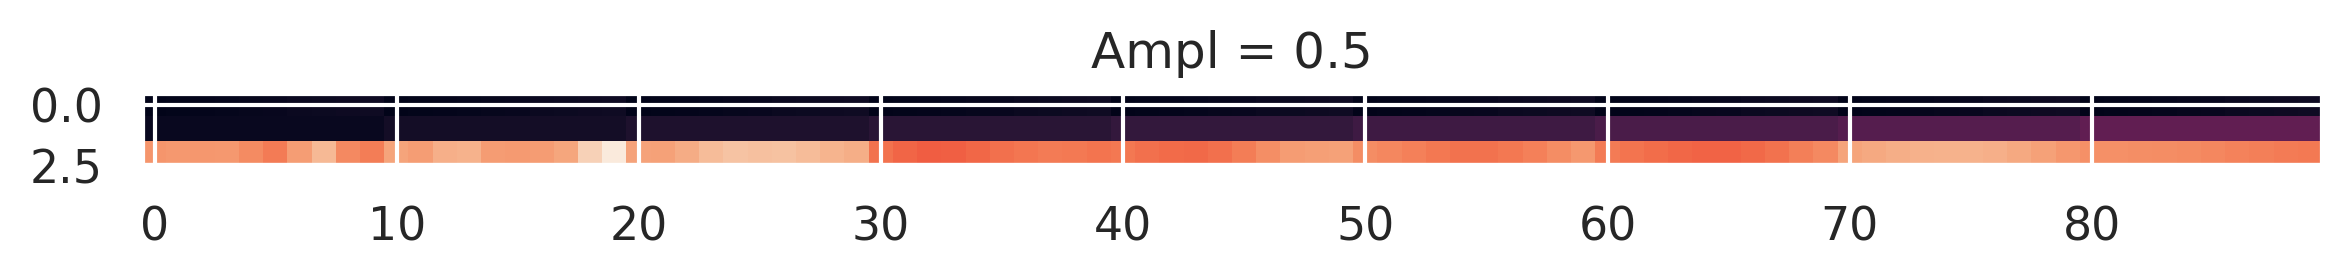

(90,)
(90,)


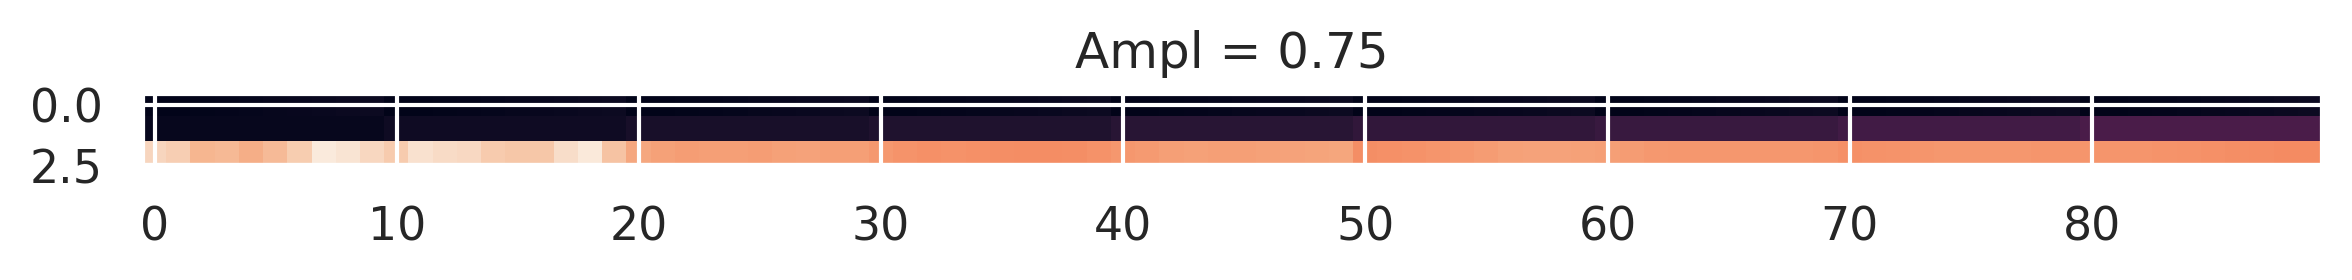

(90,)
(90,)


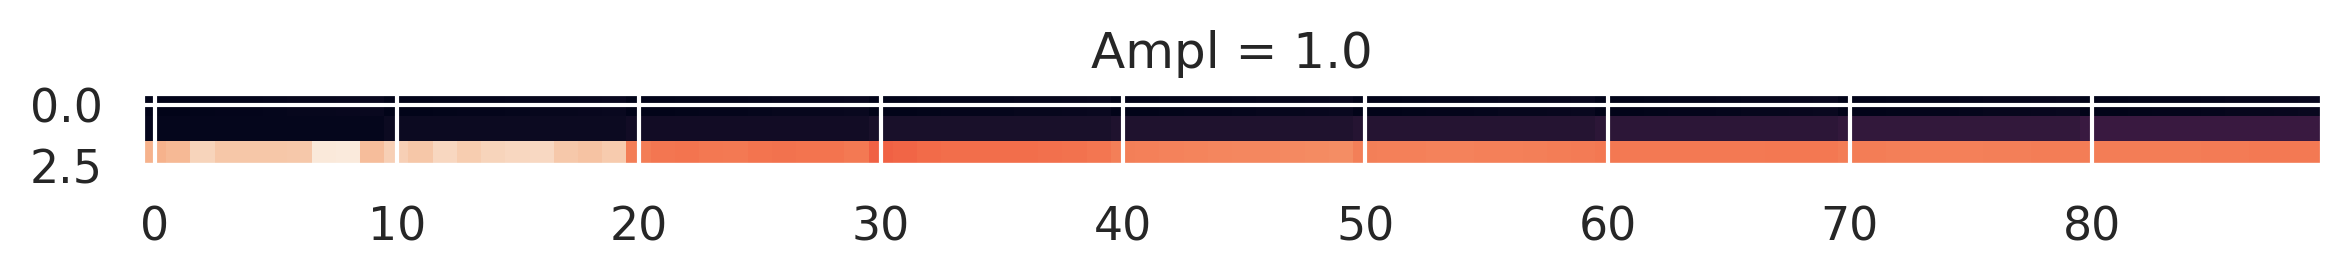

(90,)
(90,)


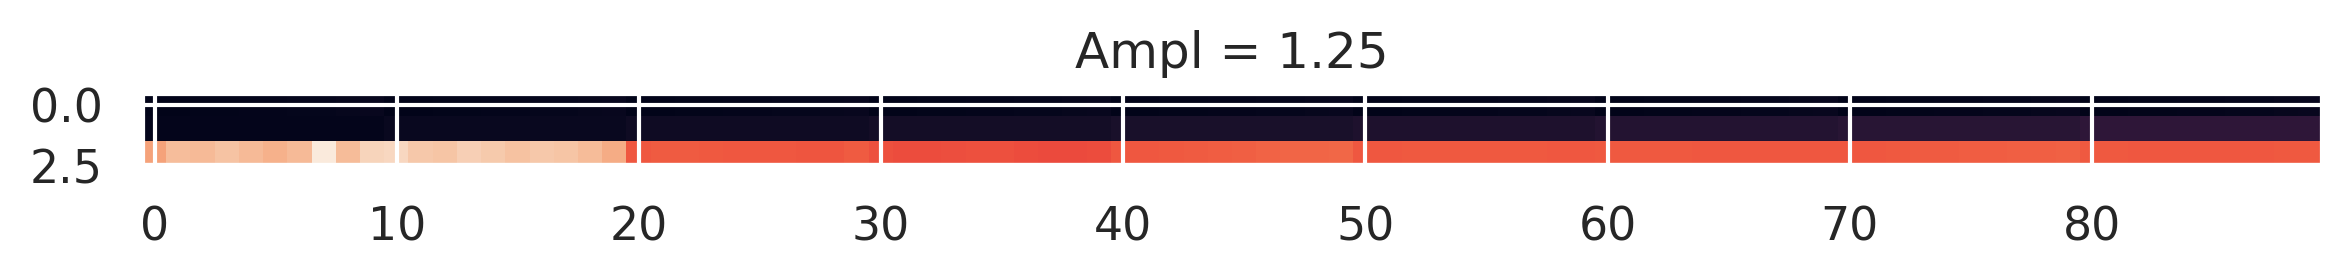

(80,)
(80,)


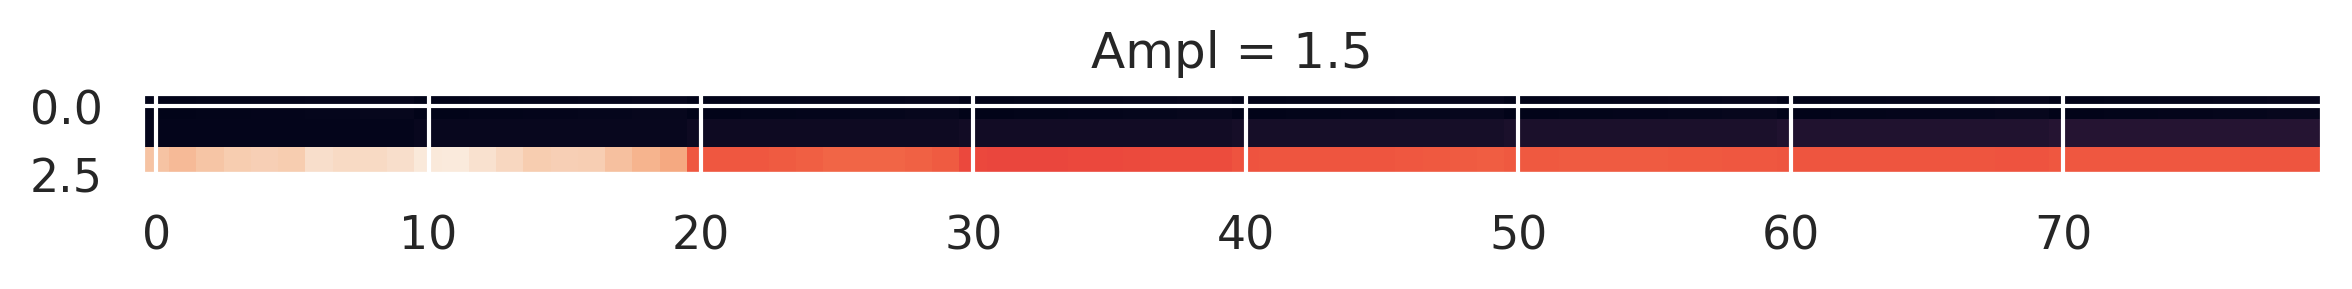

In [19]:
import pandas as pd

data2 = pd.DataFrame(data1)
fignum = 0


for ampl in data2.amplitude.unique():
    x = data2[data2.amplitude == ampl]['frequency']
    y = data2[data2.amplitude == ampl]['delay']
    z = data2[data2.amplitude == ampl]['diff']
    print(np.shape(z))
    print(np.shape(x))
    plt.figure(num=fignum, figsize=(8,6), dpi=300)
    fignum+=1
    plt.title(f"Ampl = {ampl}")
    #sns.scatterplot(data=data2[data2.amplitude == ampl], x='frequency', y='delay', size='diff', sizes=(5, 250), alpha=0.5)
    #plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)
    plt.imshow((x, y, z))
    plt.tight_layout()
    #plt.savefig(f"./Plots/Looping/DiffPlot_Ampl={ampl}.pdf")
    plt.show()

# Plotting for the Superspectroscopy Paper is happening here

In [2]:
# Set the initial plotting parameters

# Colorblind friendly color scheme reordered for maximum efficiency
ok = {
    'blue': "#56B4E9",
    'orange': "#E69F00",
    'green': "#009E73",
    'amber': "#F5C710",
    'purple': "#CC79A7",
    'navy': "#0072B2",
    'red': "#D55E00",
    'black': "#000000",
    'yellow': "#F0E442",
    'grey': "#999999",
}

plt_params = {
        'figure.figsize': (8, 6),
        'figure.dpi': 300,
        'legend.fontsize': 16,
        'axes.labelsize': 16,
        'axes.titlesize': 16,
        'axes.prop_cycle': plt.cycler('color', (ok[_] for _ in ok)),
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'lines.linewidth': 3.5,
        }
plt.rcParams.update(plt_params)


In [3]:
f1 = np.load('./Data/Paper/Fig.1.npz')
f2a = np.load('./Data/Paper/Fig.2(a).npz')
f2b = np.load('./Data/Paper/Fig.2(b).npz')
f3 = np.load('./Data/Paper/Fig.3.npz')
f4a = np.load('./Data/Paper/Fig.4(a).npz')
f4b = np.load('./Data/Paper/Fig.4(b).npz')
f5a = np.load('./Data/Paper/Fig.5(a).npz')
f5b = np.load('./Data/Paper/Fig.5(b).npz')
f5c = np.load('./Data/Paper/Fig.5(c).npz')


## Figure 1

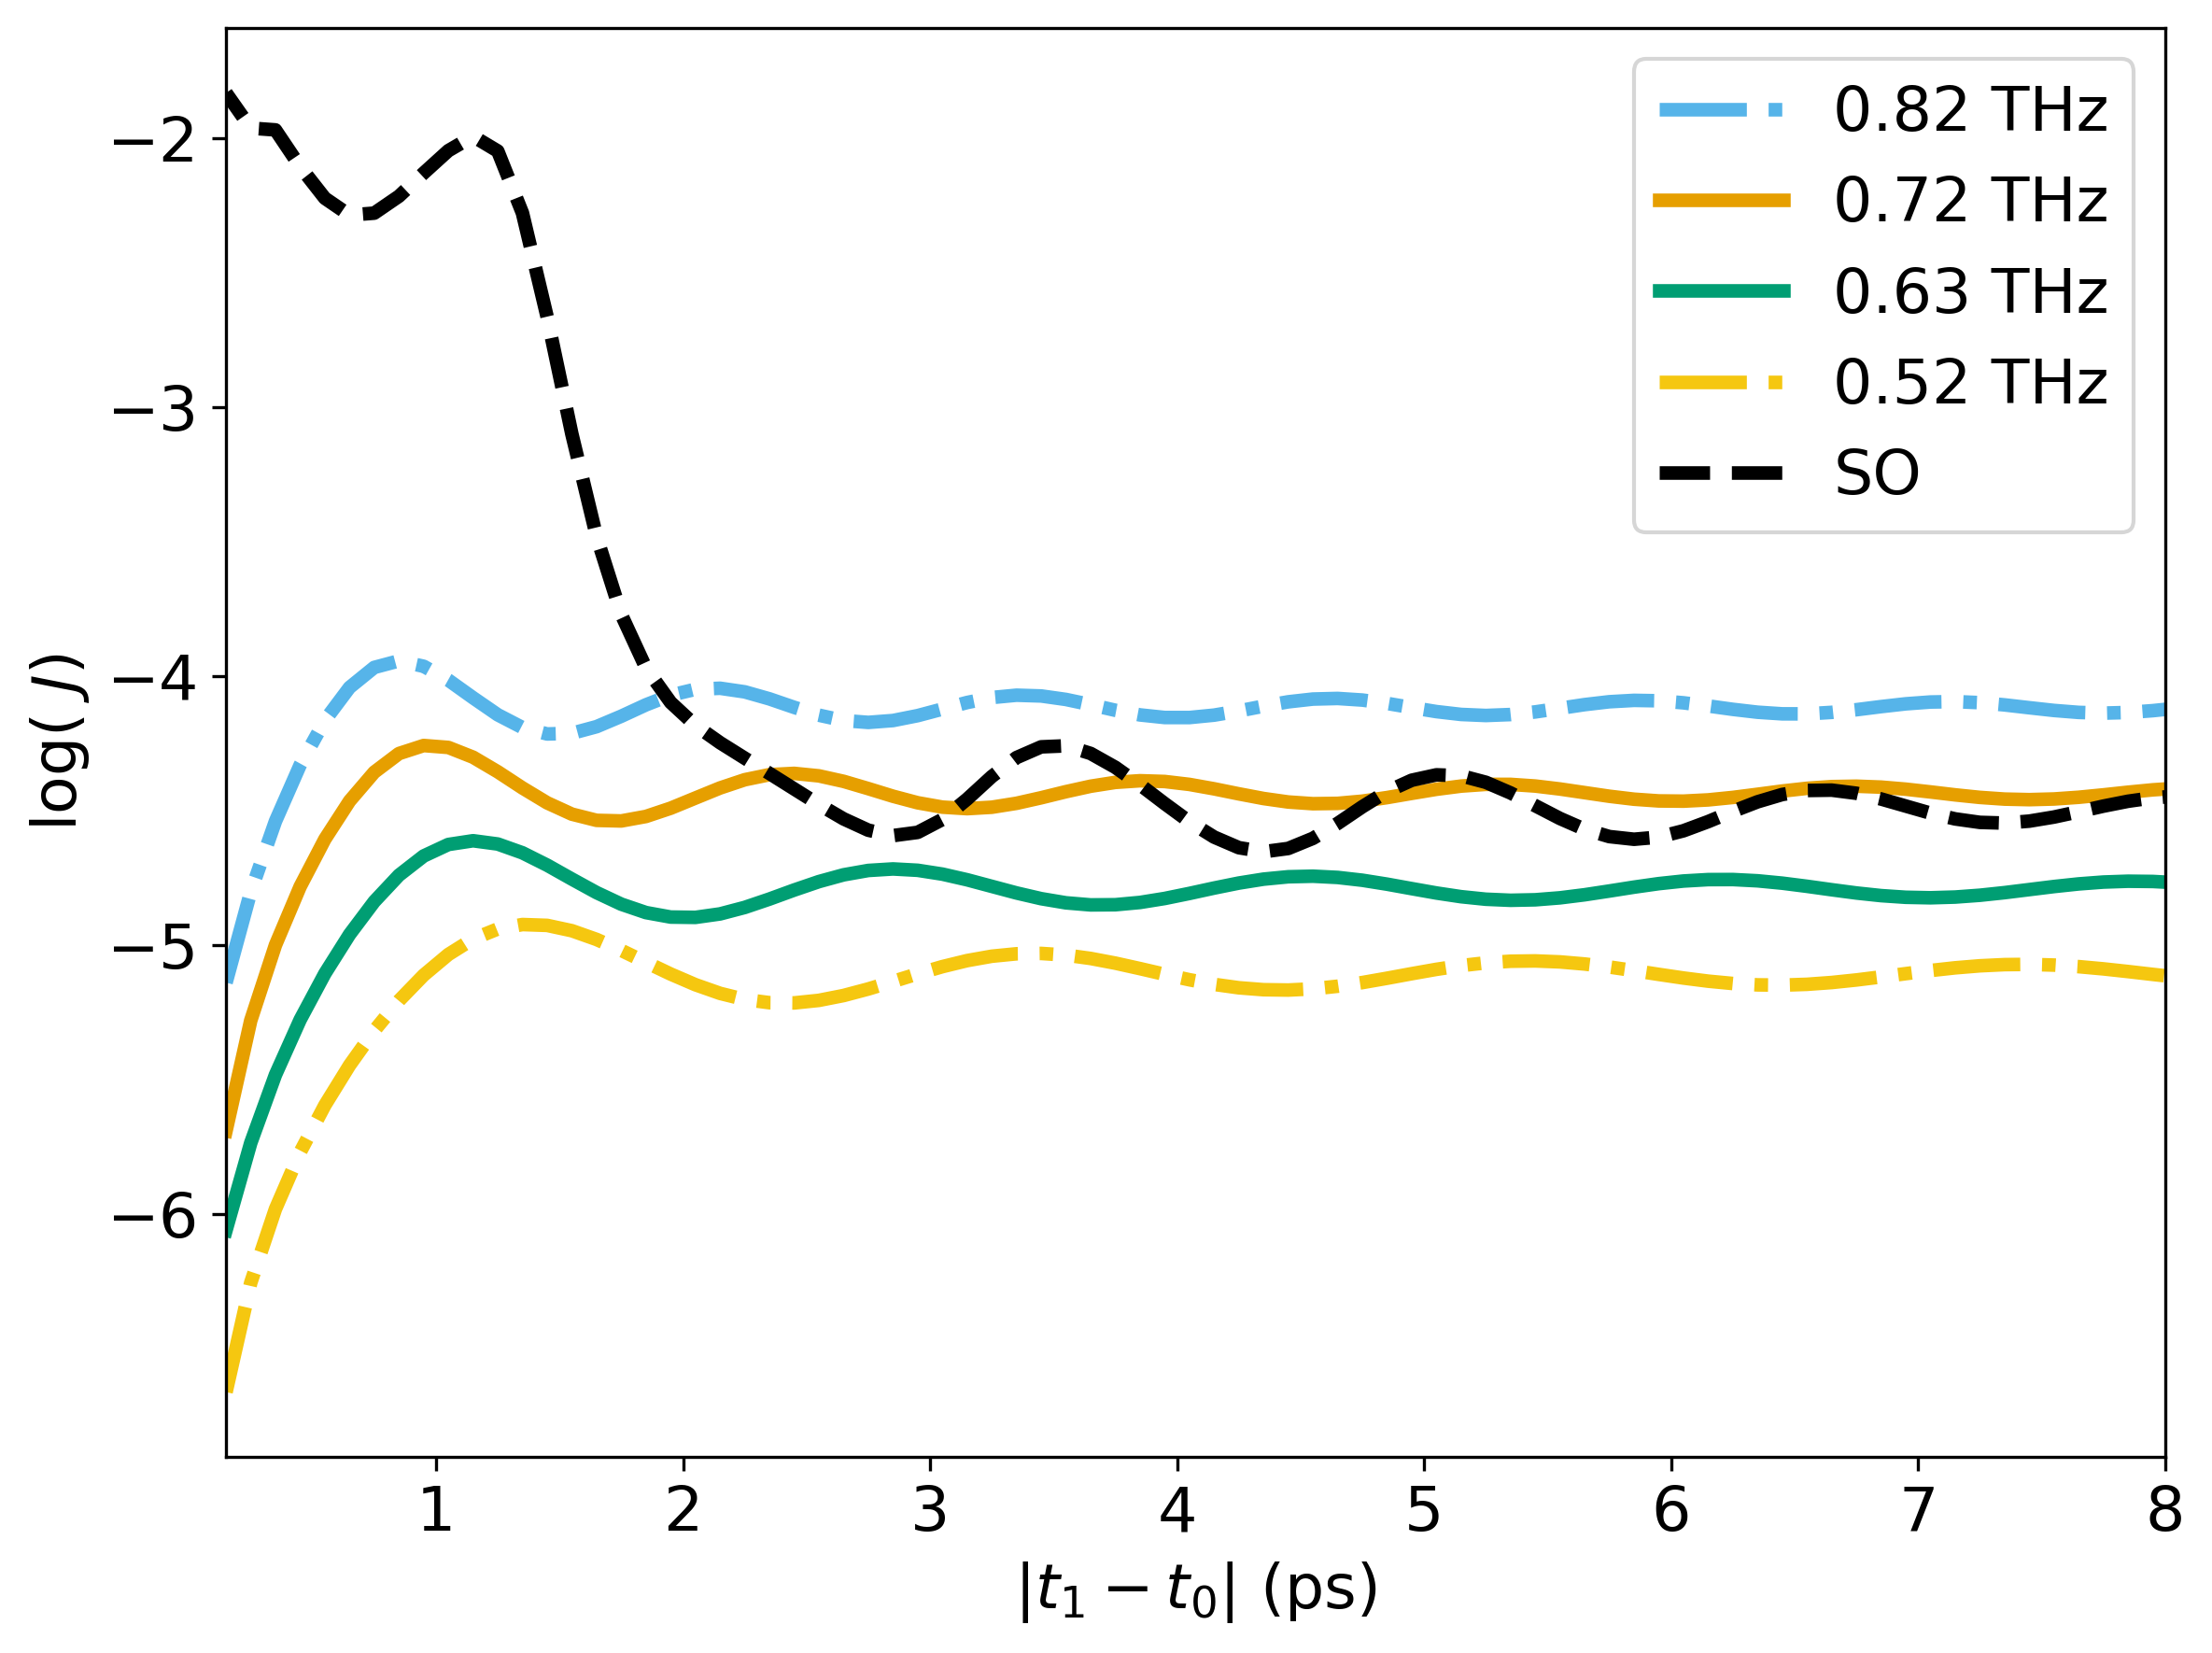

In [4]:

h1 = [_ for _ in f1.keys()]

plt.figure(num=1)
plt.plot(f1[h1[1]].T[0], f1[h1[1]].T[1], label=h1[1], linestyle='-.')
plt.plot(f1[h1[2]].T[0], f1[h1[2]].T[1], label=h1[2])
plt.plot(f1[h1[3]].T[0], f1[h1[3]].T[1], label=h1[3])
plt.plot(f1[h1[4]].T[0], f1[h1[4]].T[1], label=h1[4], linestyle='-.')
plt.plot(f1[h1[0]].T[0], f1[h1[0]].T[1], label=h1[0], linestyle='--', color=ok['black'])
plt.xlim([f1['SO'].T[0][-2],8])
plt.xlabel("$\|t_1 - t_0 \|$ (ps)")
plt.ylabel("log( $J$)")
plt.legend()
plt.tight_layout()
plt.savefig('./Plots/Paper/Fig1(thick).pdf')
plt.show()

## Figure 2

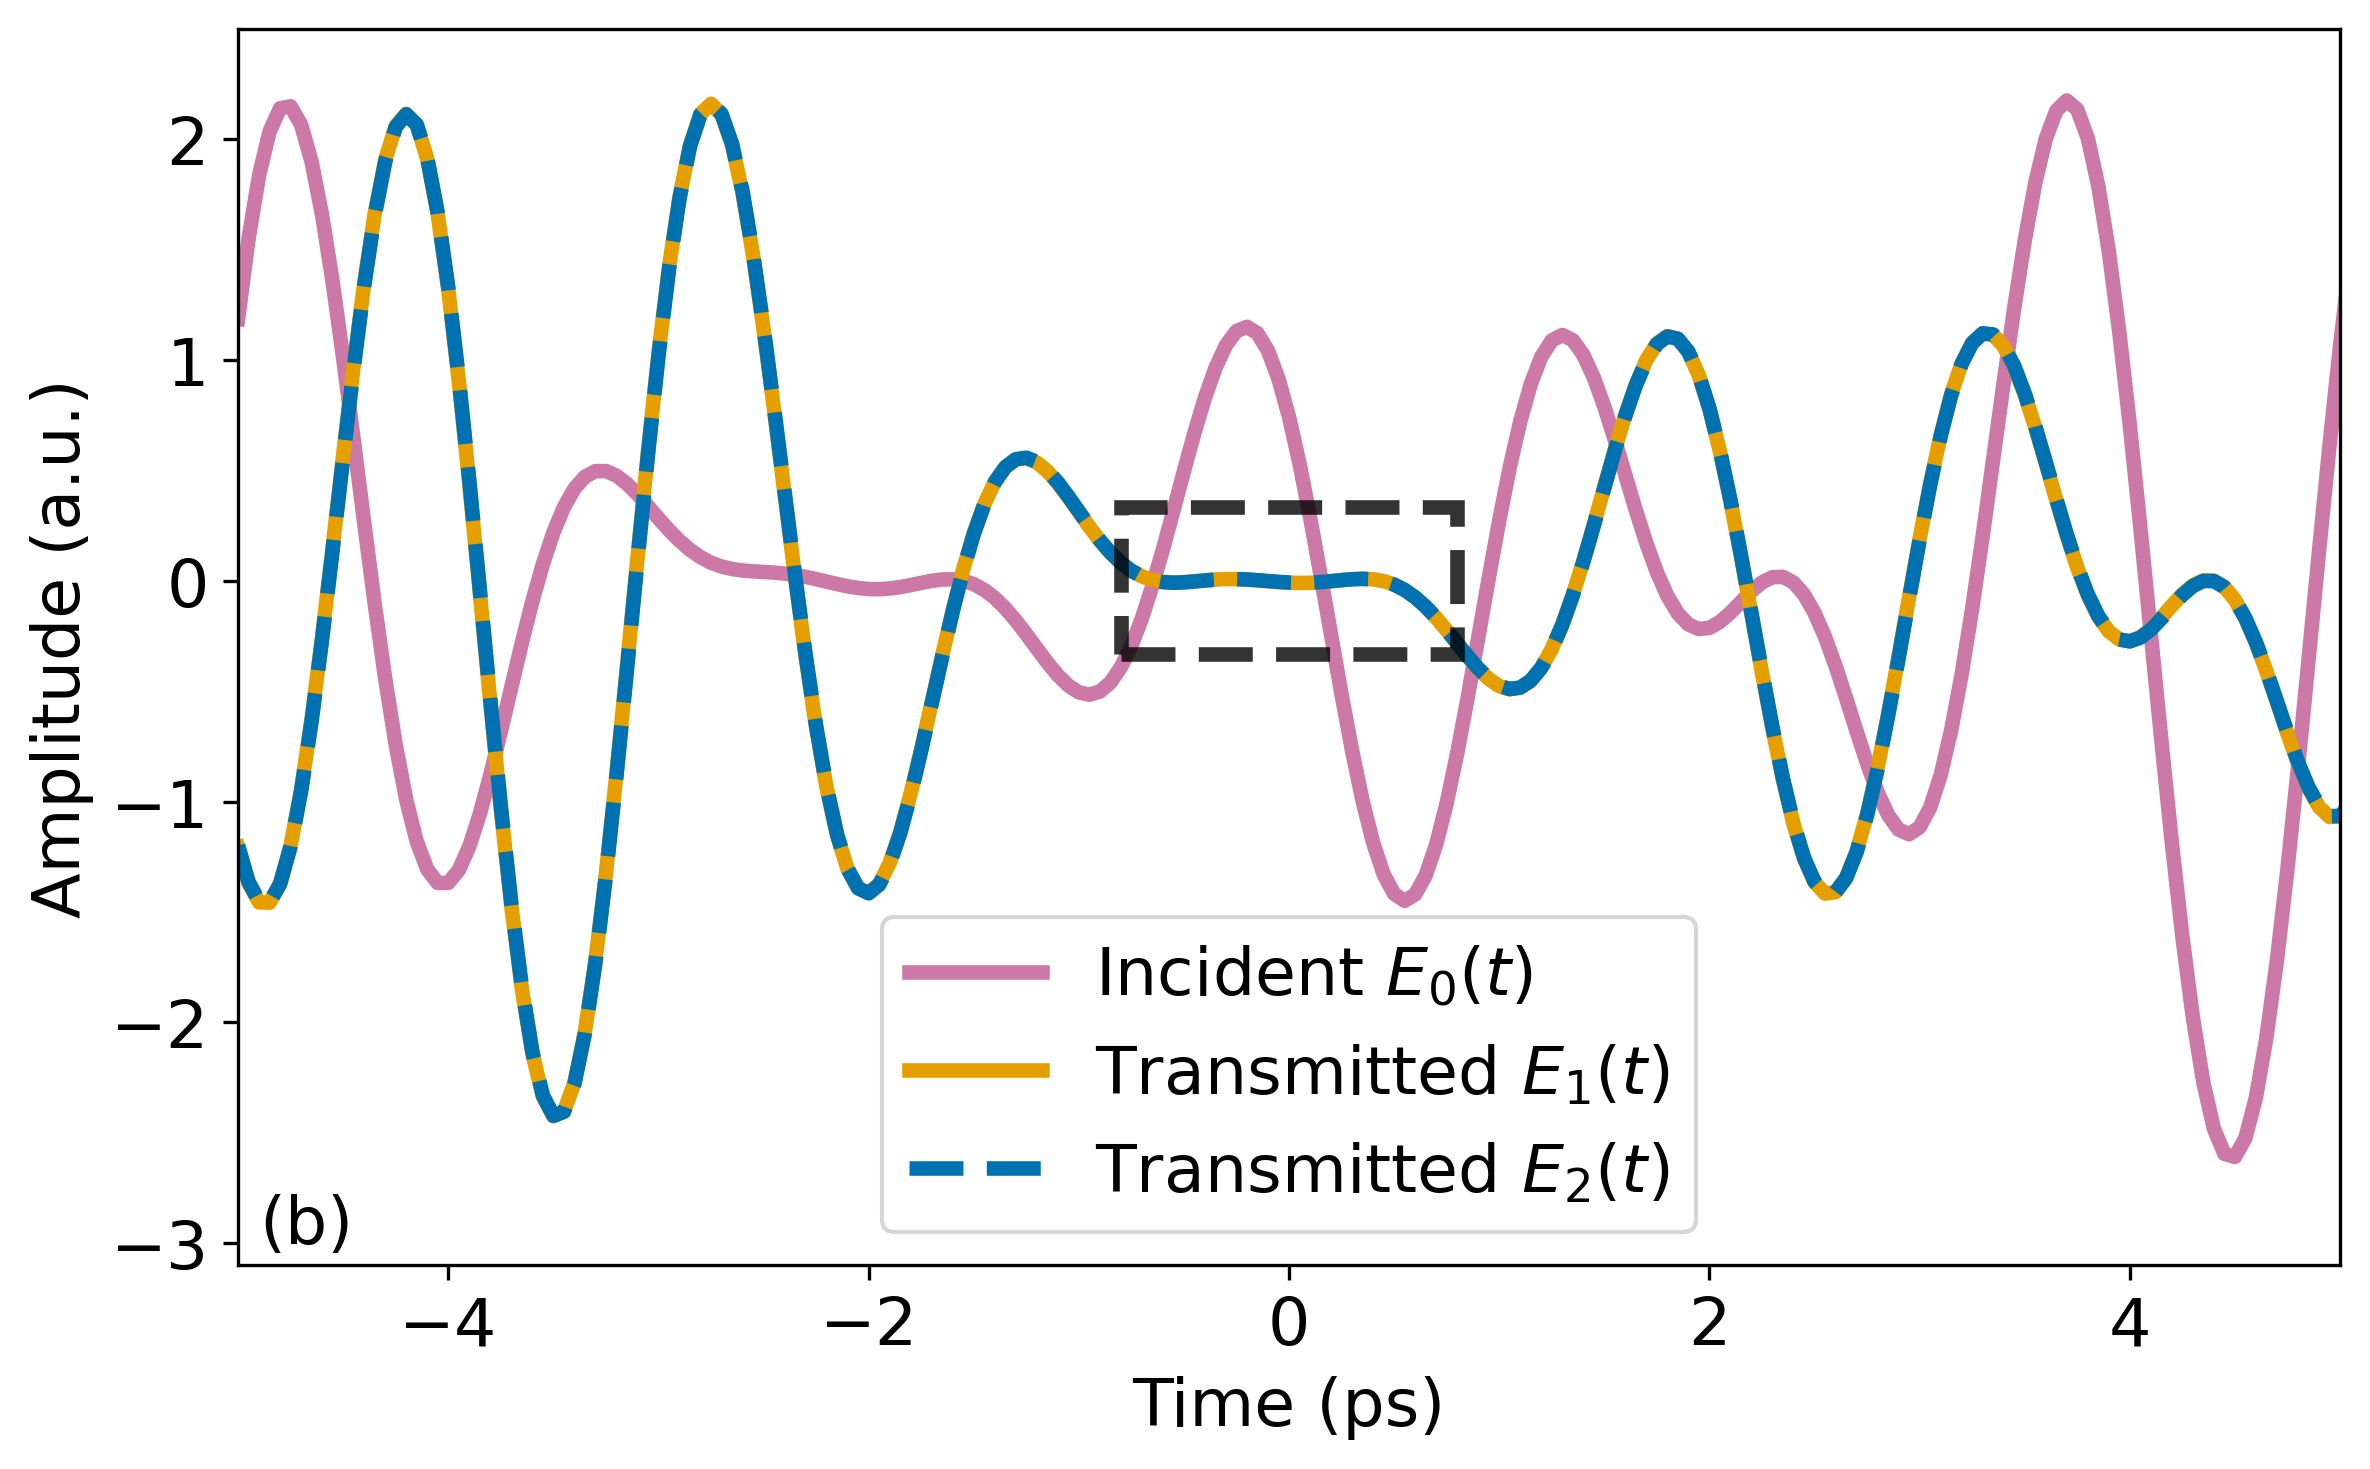

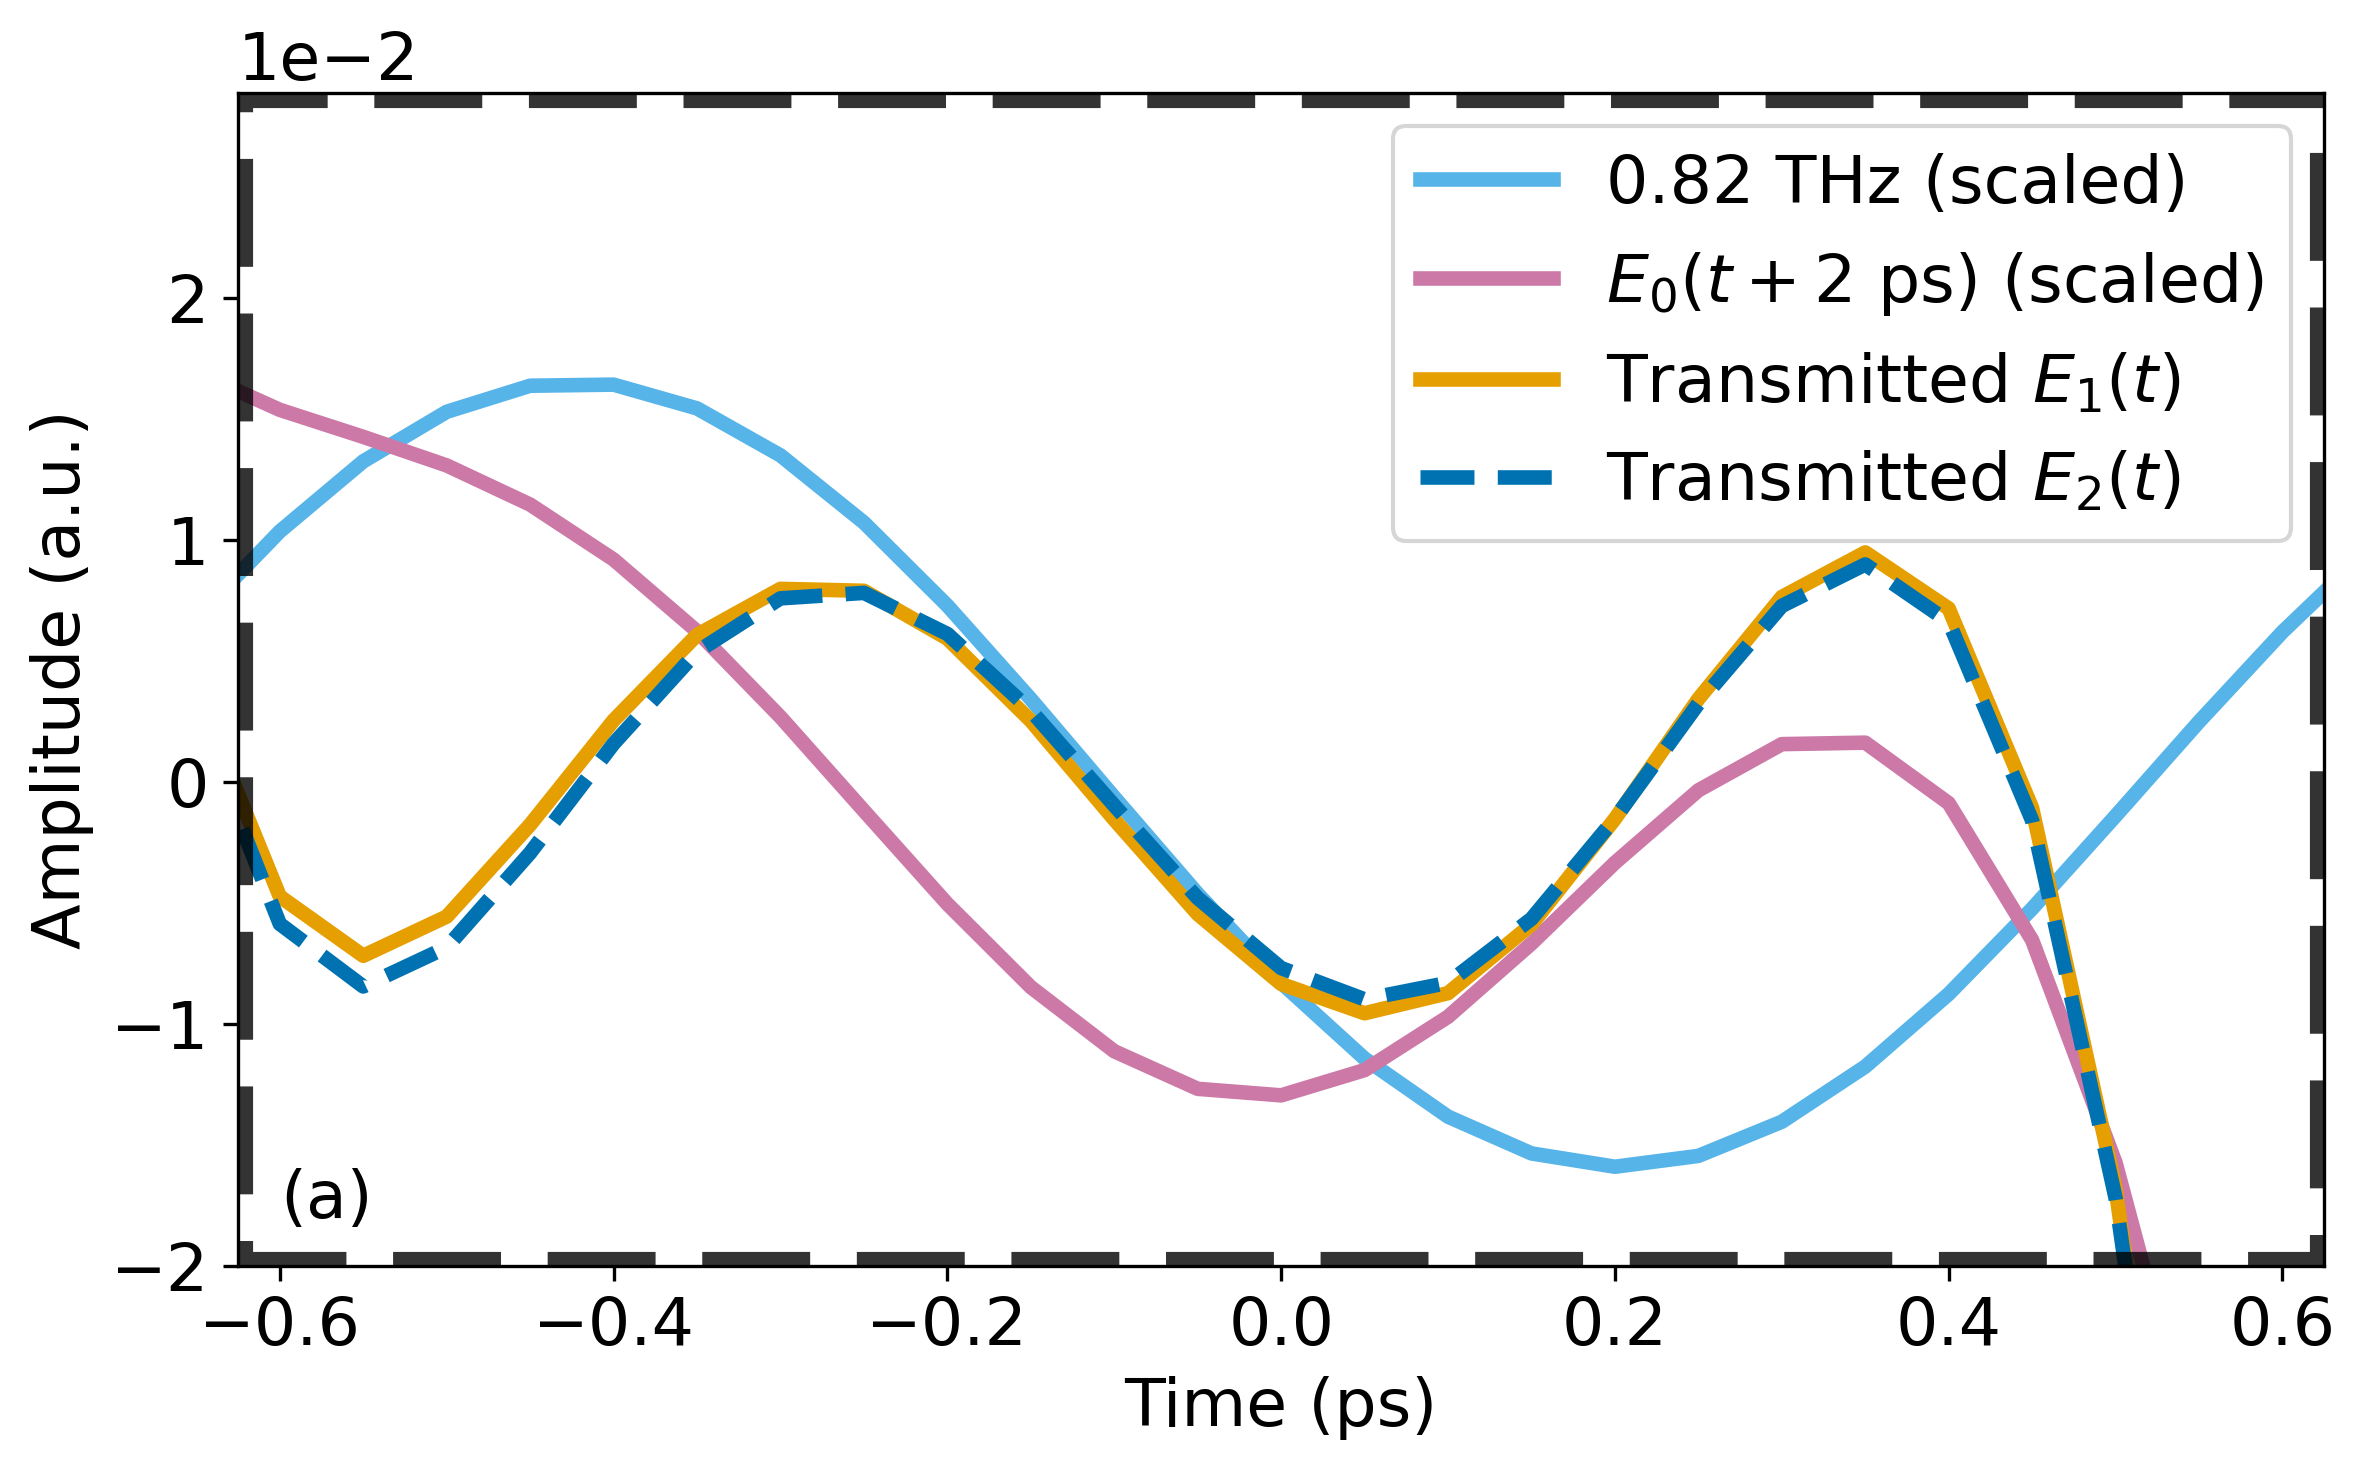

In [5]:
h2a = [_ for _ in f2a.keys()]
h2b = [_ for _ in f2b.keys()]

# Change E_0(t) shifted to E_0(t + 2 ps)

plt.figure(num=2, figsize=(8, 5))
plt.plot(f2a[h2a[0]].T[0], f2a[h2a[0]].T[1], color=ok['purple'], label=h2a[0])
plt.plot(f2a[h2a[1]].T[0], f2a[h2a[1]].T[1], color=ok['orange'], label=h2a[1])
plt.plot(f2a[h2a[2]].T[0], f2a[h2a[2]].T[1], color=ok['navy'], linestyle='--', label=h2a[2])
plt.xlim([-5, 5])
plt.ylim([-3.1, 2.5])
plt.xlabel("Time (ps)")
plt.ylabel("Amplitude (a.u.)")
plt.legend()
plt.subplot().add_patch(
    patches.Rectangle(((0-1.6/2), -0.3333), 1.6, 0.6666, linestyle='--', linewidth=3.5, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3)
)
plt.subplot().text(-4.9, -3, '(b)', fontsize=16)
plt.tight_layout()
plt.savefig('./Plots/Paper/Fig2(a)(thick).pdf')
plt.show()

plt.figure(num=3, figsize=(8, 5))
plt.plot(f2b[h2b[0]].T[0], (np.array(f2b[h2b[0]].T[1]) * 0.02 / f2b[h2b[0]].T[1].max()),
         color=ok['blue'], label='0.82 THz (scaled)')
plt.plot(f2b[h2b[1]].T[0], (np.array(f2b[h2b[1]].T[1]) * 0.75 / f2b[h2b[1]].T[1].max()),
         color=ok['purple'], label='$E_0 (t + 2$ ps) (scaled)')
plt.plot(f2b[h2b[2]].T[0], f2b[h2b[2]].T[1], color=ok['orange'], label=h2b[2])
plt.plot(f2b[h2b[3]].T[0], f2b[h2b[3]].T[1], color=ok['navy'], linestyle='--', label=h2b[3])
plt.xlim([-0.625, 0.625])
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0.02, 0.02))
plt.ylim([-2e-2, 2.85e-2])
plt.yticks([-.02, -.01, 0, .01, .02])
plt.xlabel("Time (ps)")
plt.ylabel("Amplitude (a.u.)")
plt.legend(loc='upper right')
plt.subplot().add_patch(
    patches.Rectangle(((-0.625), -2e-2), 1.25, 4.85e-2, linestyle='--', linewidth=7, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3)
)
plt.subplot().text(-0.6, -1.8e-2, '(a)', fontsize=16)
plt.box(True)
plt.tight_layout()
plt.savefig('./Plots/Paper/Fig2b(Frame).pdf')
plt.show()

## Figure 3

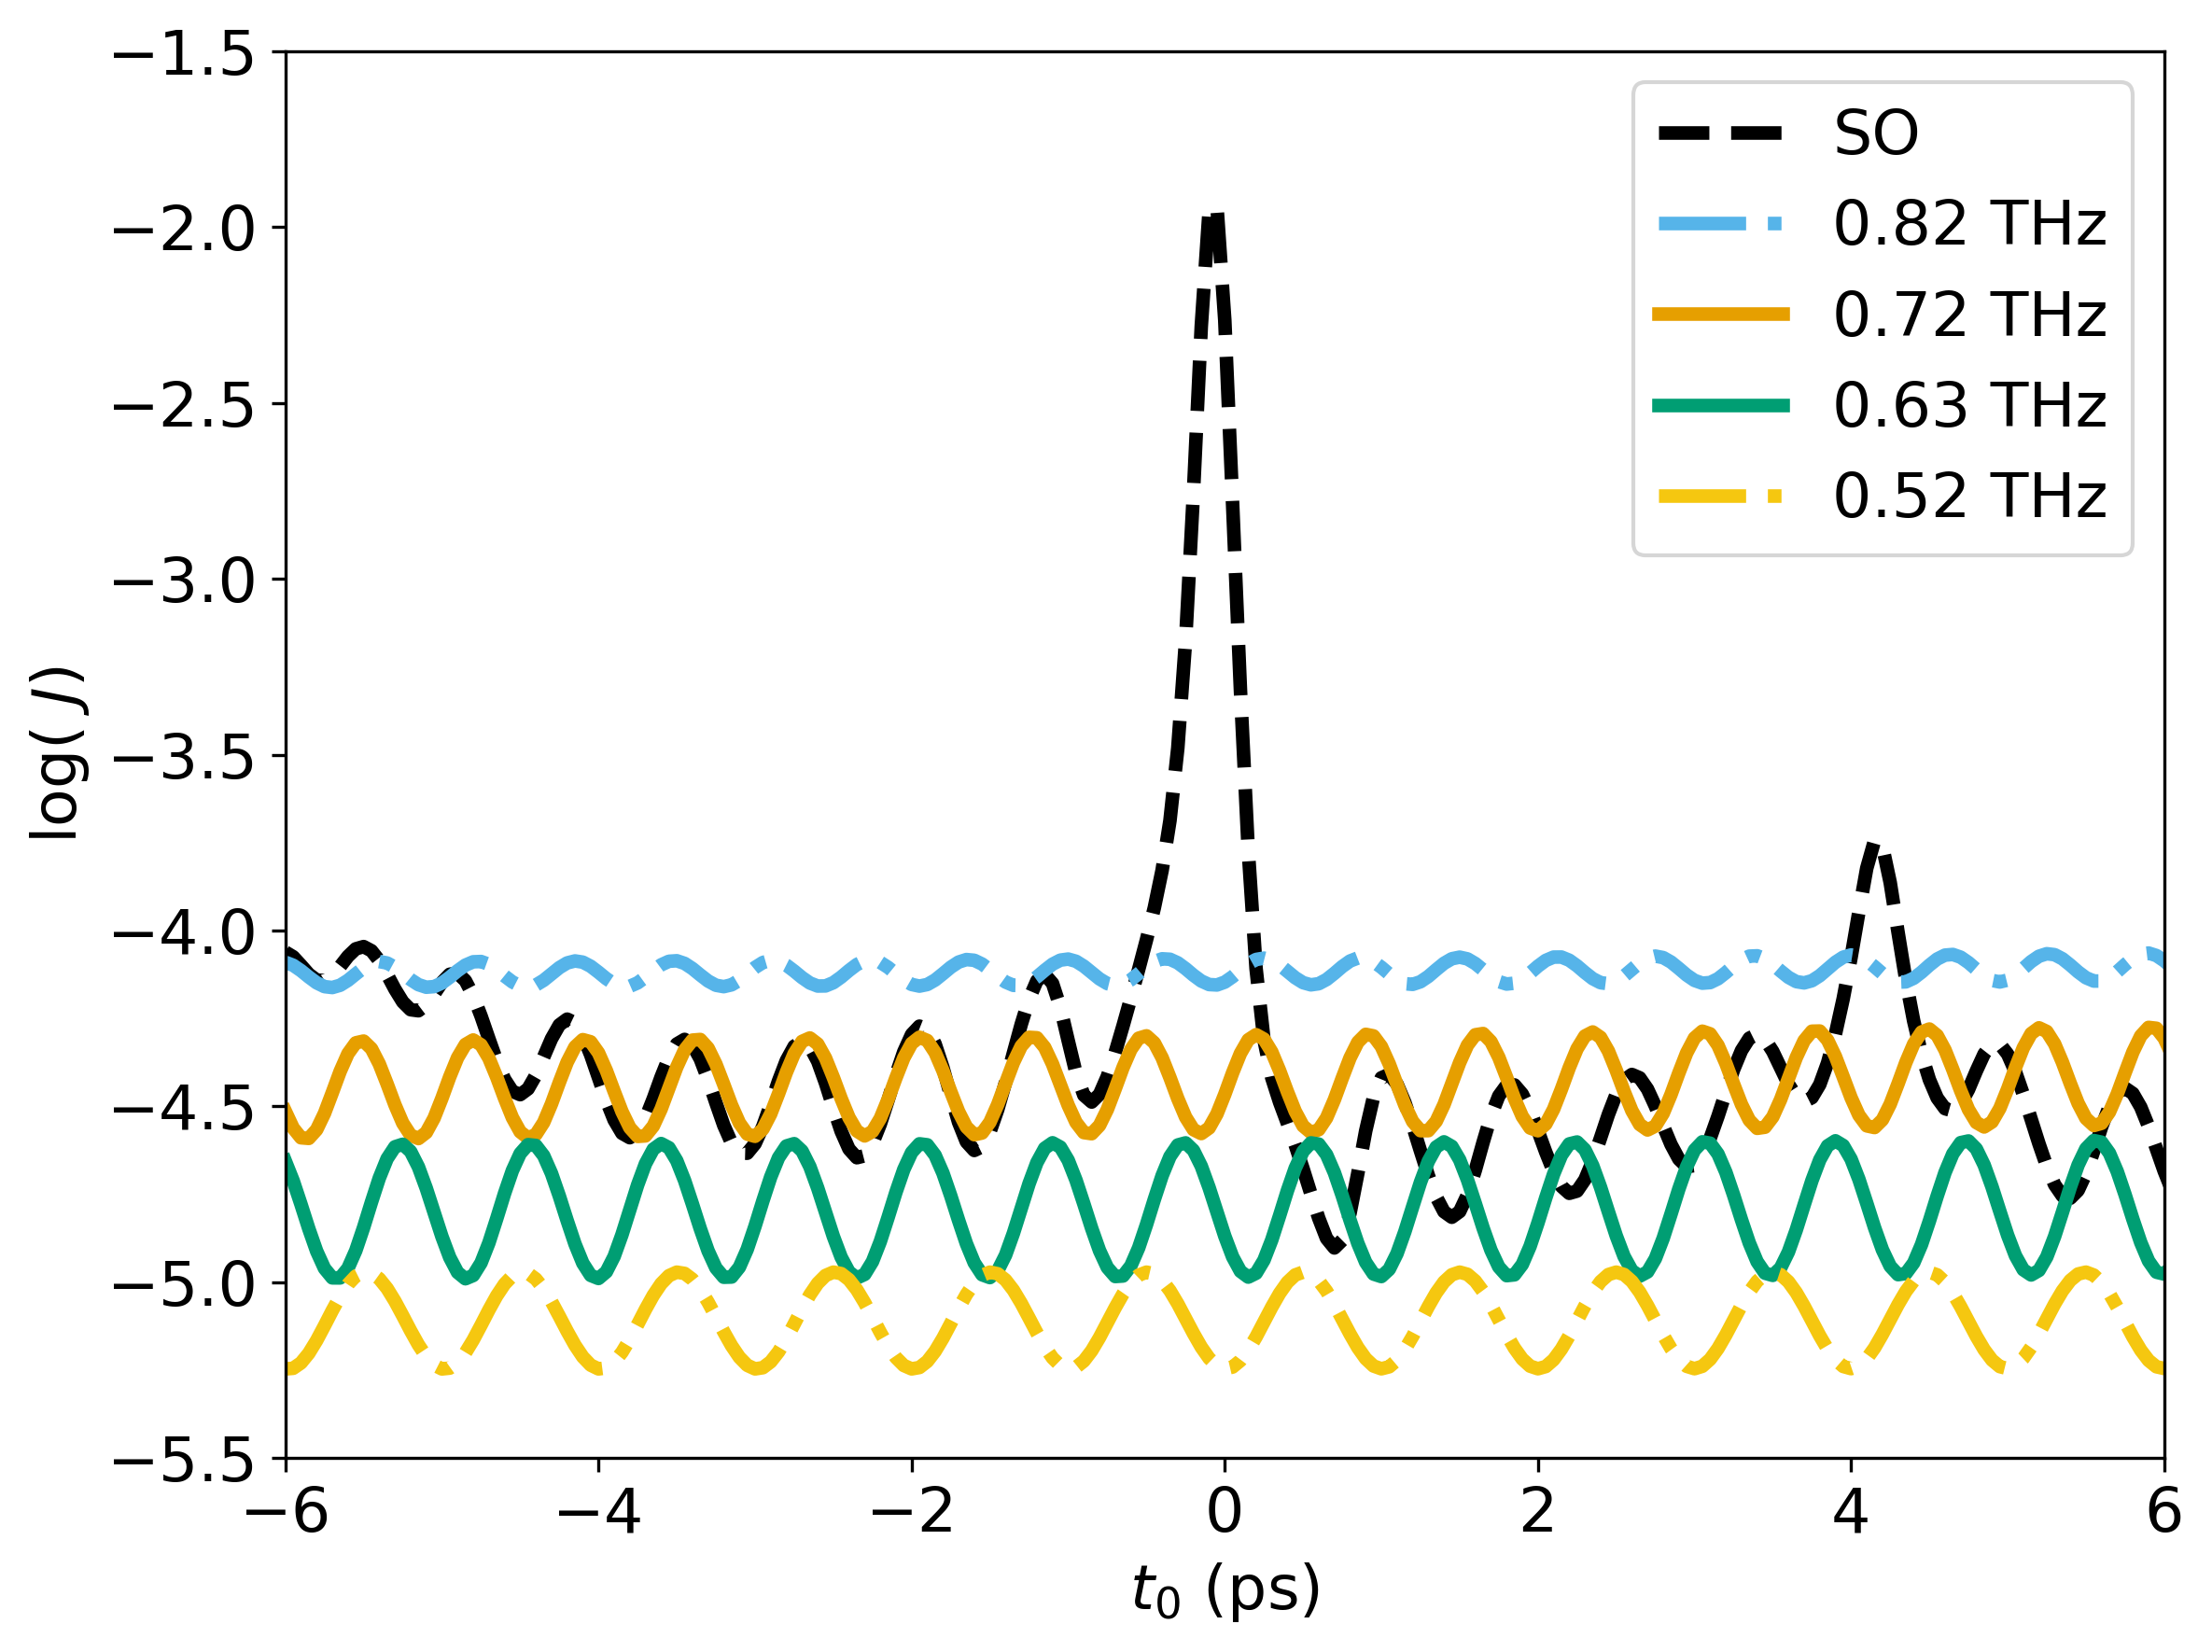

In [6]:
h3 = [_ for _ in f3.keys()]

plt.figure(num=4)
plt.plot(f3[h3[0]].T[0], f3[h3[0]].T[1], label=h3[0], linestyle='--', color=ok['black'])
plt.plot(f3[h3[1]].T[0], f3[h3[1]].T[1], label=h3[1], linestyle='-.')
plt.plot(f3[h3[2]].T[0], f3[h3[2]].T[1], label=h3[2])
plt.plot(f3[h3[3]].T[0], f3[h3[3]].T[1], label=h3[3])
plt.plot(f3[h3[4]].T[0], f3[h3[4]].T[1], label=h3[4], linestyle='-.')
plt.xlim([-6, 6])
plt.ylim([-5.5, -1.5])
plt.xlabel("$t_0$ (ps)")
plt.ylabel("log( $J$)")
plt.legend()
plt.tight_layout()
plt.savefig('./Plots/Paper/Fig3(thick).pdf')
plt.show()

## Figure 4

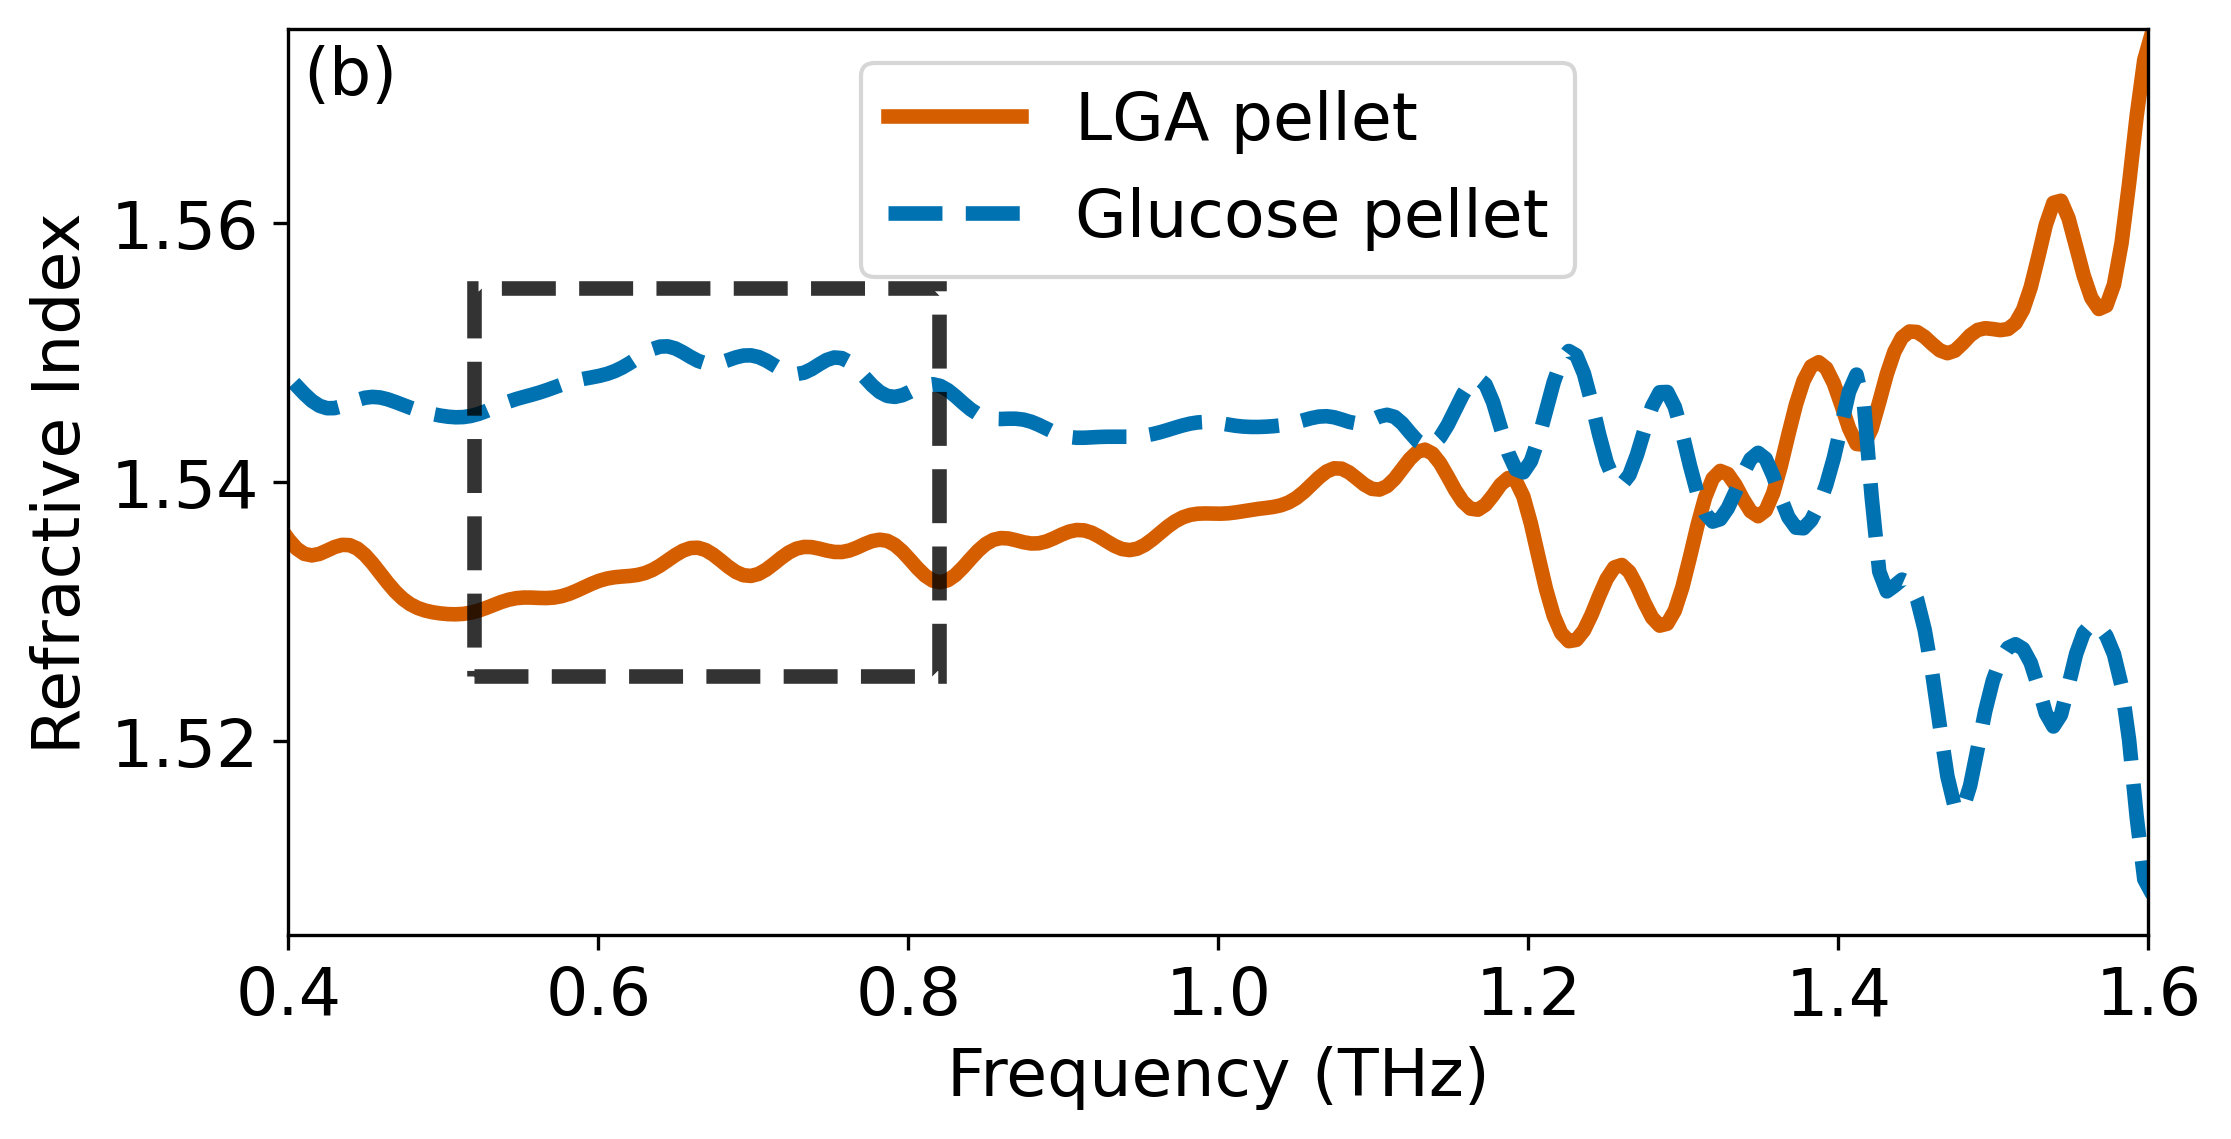

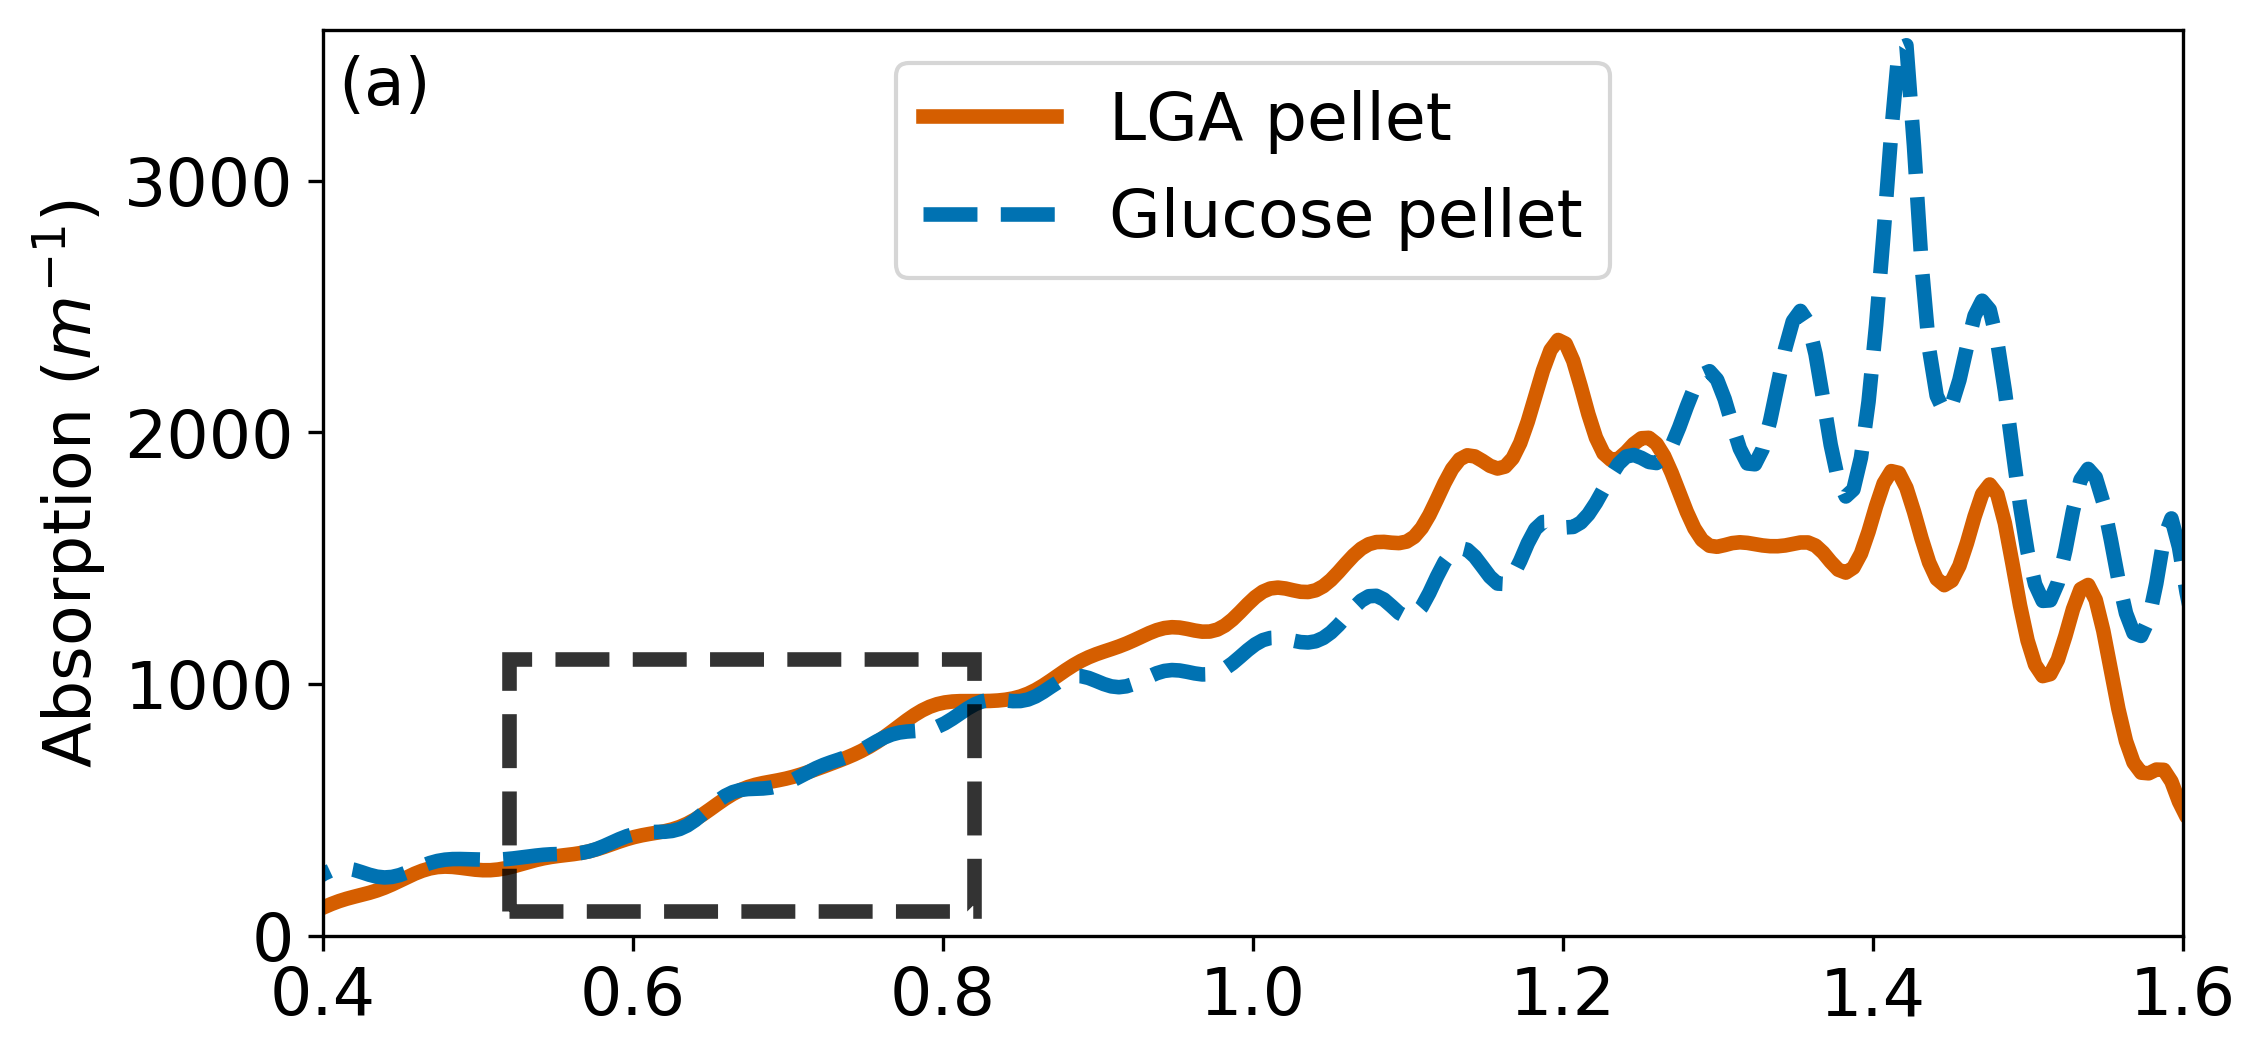

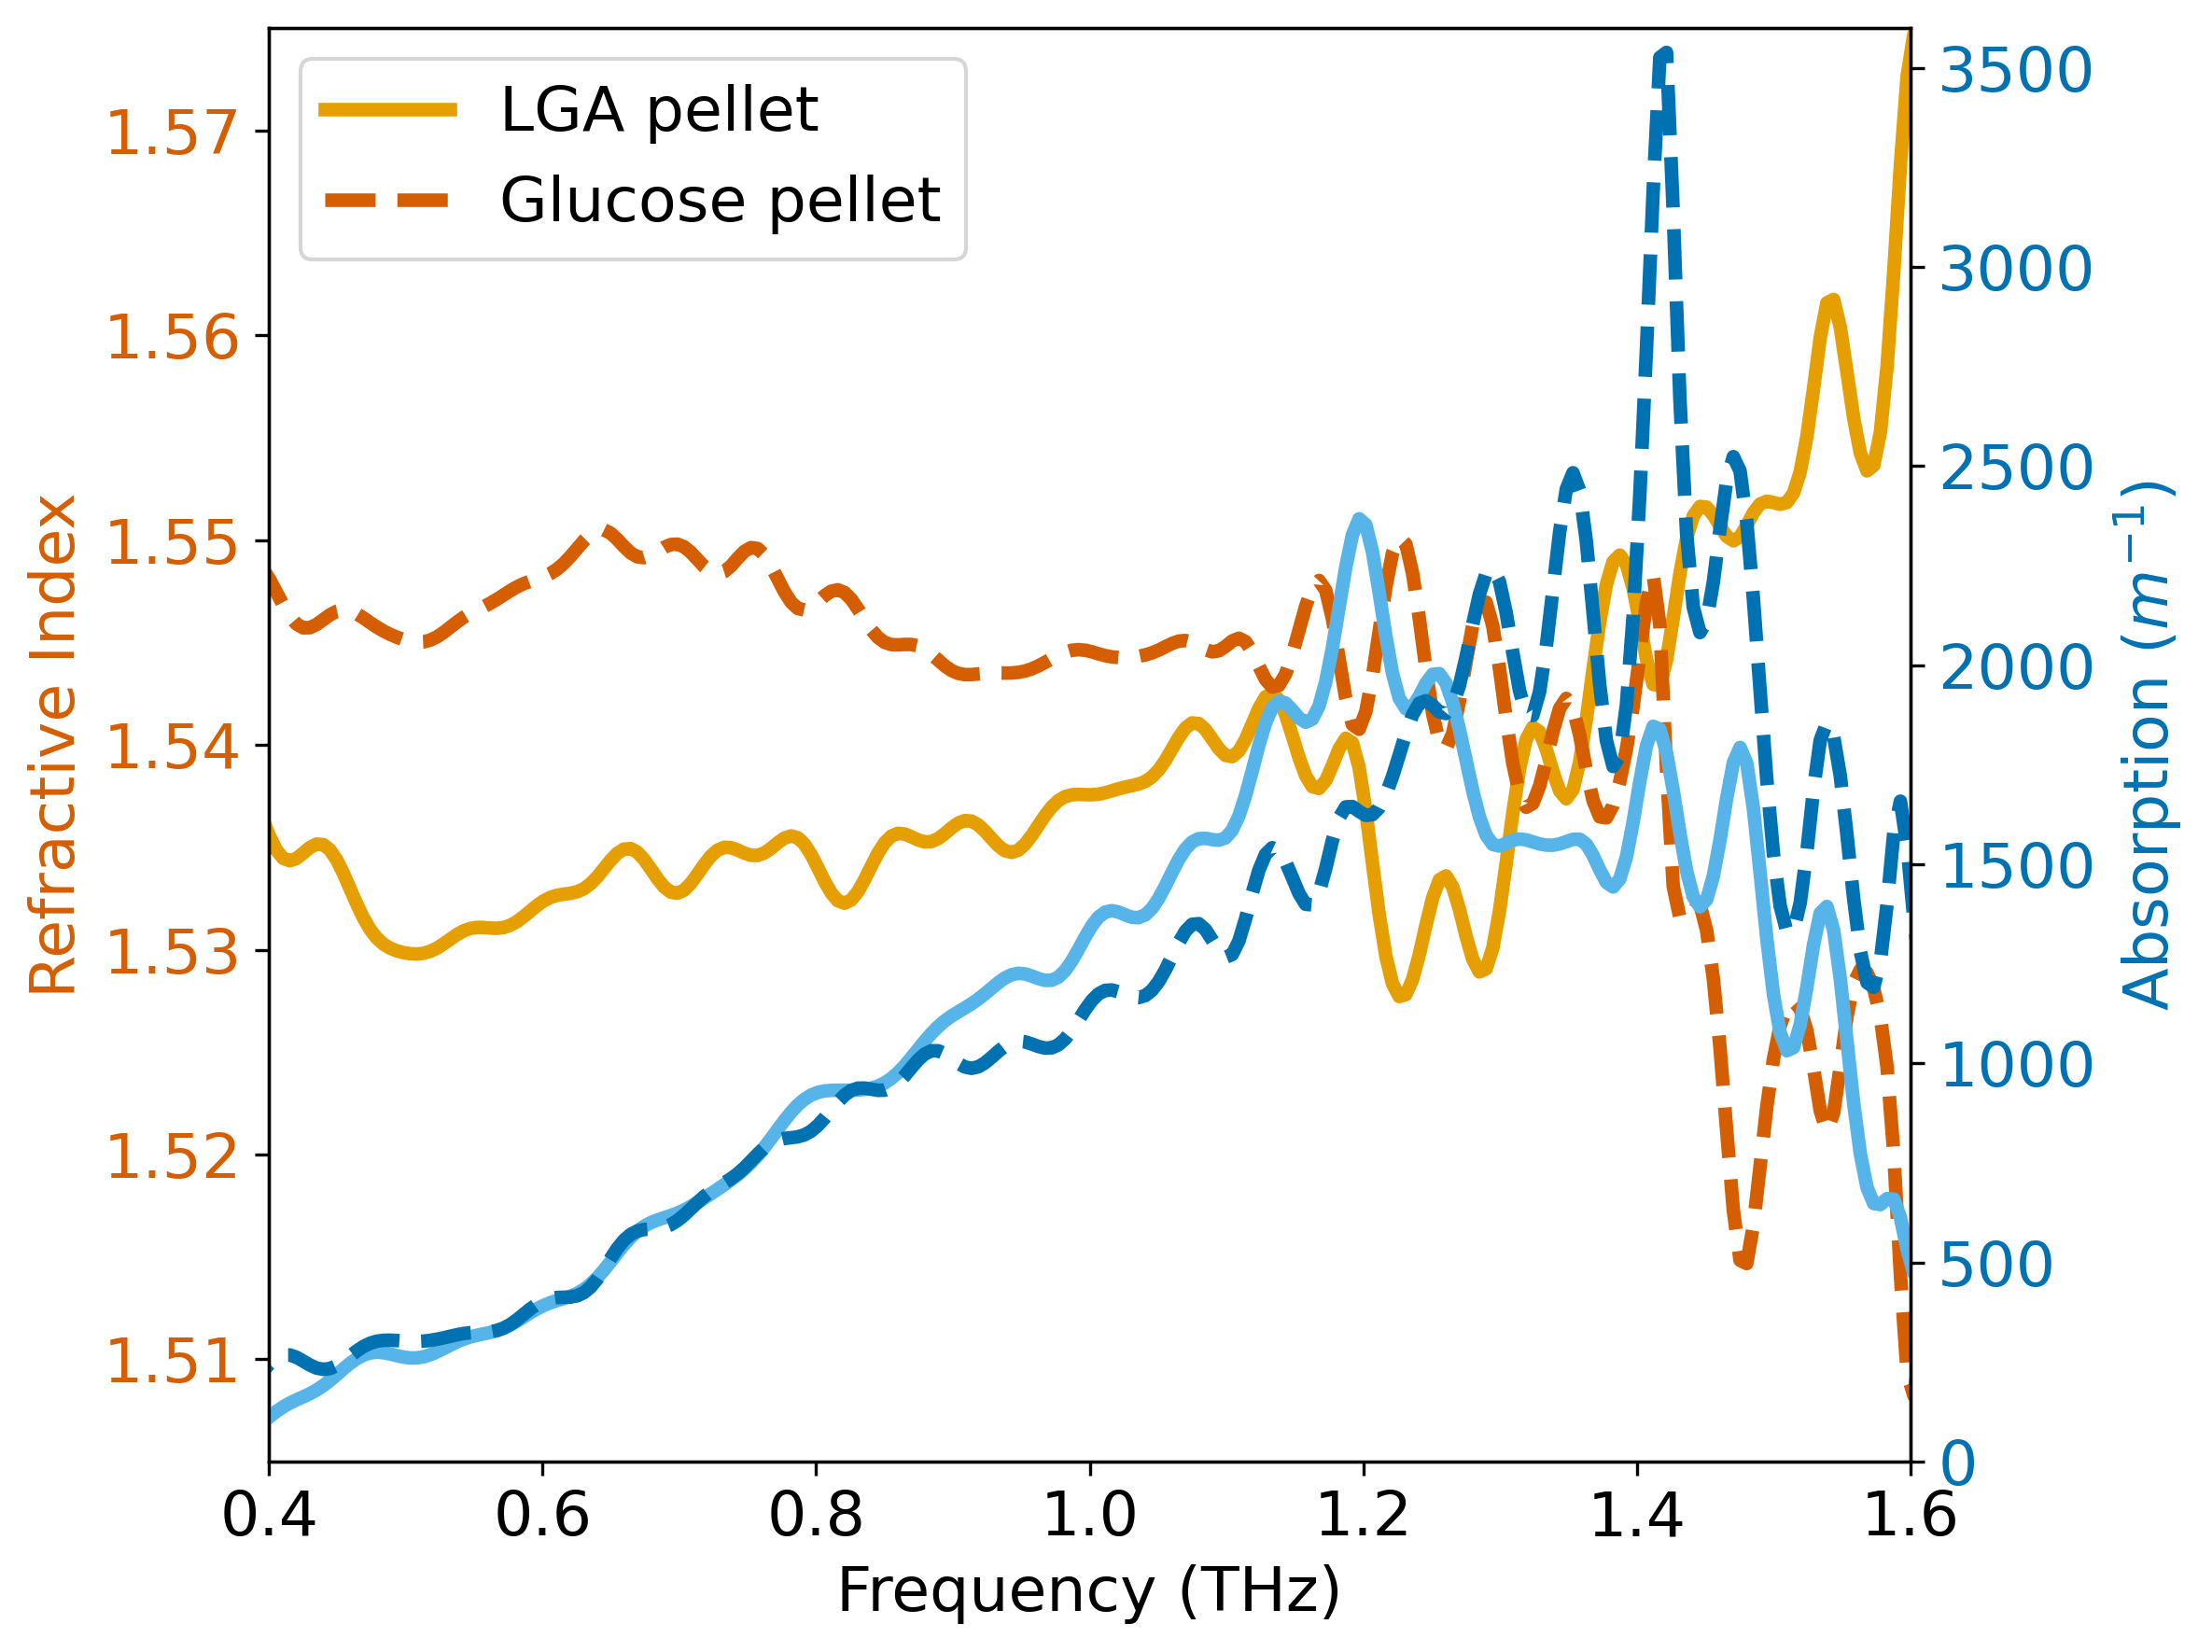

'plt.figure(figsize=(8,4))\n\nplt.plot(f4a[h4a[0]].T[0], f4a[h4a[0]].T[1], color=ok[\'red\'], label=h4a[0])\nplt.plot(f4a[h4a[1]].T[0], f4a[h4a[1]].T[1], color=ok[\'navy\'], linestyle=\'--\', label=h4a[1])\nplt.xlim([0.5, 0.8])\nplt.ylim([1.525, 1.555])\nplt.xlabel("Frequency (THz)")\nplt.ylabel("Refractive Index")\nplt.legend(loc=\'best\')\nplt.subplot().text(0.505, 1.5525, \'(b)\', fontsize=16)\nplt.subplot().add_patch(\n    patches.Rectangle((0.52, 1.525), 0.3, 0.03, linestyle=\'--\', linewidth=7, edgecolor=ok[\'black\'], \n                      facecolor=\'none\', alpha=0.8, zorder=3))\nplt.box(False)\nplt.tight_layout()\nplt.savefig(\'./Plots/Paper/Fig4bZoomed.pdf\')\nplt.show()'

In [7]:
h4a = [_ for _ in f4a.keys()]
h4b = [_ for _ in f4b.keys()]

plt.figure(num=5, figsize=(8,4))

plt.plot(f4a[h4a[0]].T[0], f4a[h4a[0]].T[1], color=ok['red'], label=h4a[0])
plt.plot(f4a[h4a[1]].T[0], f4a[h4a[1]].T[1], color=ok['navy'], linestyle='--', label=h4a[1])
plt.xlim([0.4, 1.6])
plt.ylim([1.505, 1.575])
plt.xlabel("Frequency (THz)")
plt.ylabel("Refractive Index")
plt.legend(loc='upper center')

plt.subplot().add_patch(
    patches.Rectangle((0.52, 1.525), 0.3, 0.03, linestyle='--', linewidth=3.5, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3))
plt.subplot().text(0.41, 1.57, '(b)', fontsize=16)

#plt.tight_layout()
plt.savefig('./Plots/Paper/Fig4b(edited).pdf')
plt.show()

plt.figure(num=6, figsize=(8,4))
plt.plot(f4b[h4b[0]].T[0], f4b[h4b[0]].T[1], color=ok['red'], label=h4b[0])
plt.plot(f4b[h4b[1]].T[0], f4b[h4b[1]].T[1], color=ok['navy'], linestyle='--', label=h4b[1])
plt.subplot().add_patch(
    patches.Rectangle((0.52, 100), 0.3, 1000, linestyle='--', linewidth=3.5, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3))
plt.subplot().text(0.41, 3300, '(a)', fontsize=16)
plt.xlim([0.4, 1.6])
plt.ylim([0, 3600])
#plt.xlabel("Frequency (THz)")
plt.ylabel("Absorption $(m^{-1})$")
plt.legend(loc='upper center')
#plt.gca().axes.xaxis.set_ticklabels([])
#plt.tight_layout()
plt.savefig('./Plots/Paper/Fig4a.pdf')
plt.show()

fig, ax1 = plt.subplots()
ax1.set_xlabel("Frequency (THz)")
ax1.set_ylabel("Refractive Index", color=ok['red'])
ax1.plot(f4a[h4a[0]].T[0], f4a[h4a[0]].T[1], color=ok['orange'], label=h4a[0])
ax1.plot(f4a[h4a[1]].T[0], f4a[h4a[1]].T[1], color=ok['red'], linestyle='--', label=h4a[1])
ax1.tick_params(axis='y', labelcolor=ok['red'])
ax1.set_ylim([1.505, 1.575])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("Absorption $(m^{-1})$", color=ok['navy'])
ax2.plot(f4b[h4b[0]].T[0], f4b[h4b[0]].T[1], color=ok['blue'], label=h4b[0])
ax2.plot(f4b[h4b[1]].T[0], f4b[h4b[1]].T[1], color=ok['navy'], linestyle='--', label=h4b[1])
ax2.tick_params(axis='y', labelcolor=ok['navy'])
ax2.set_ylim([0, 3600])
plt.xlim([0.4, 1.6])
plt.tight_layout()
plt.show()

"""plt.figure(figsize=(8,4))

plt.plot(f4a[h4a[0]].T[0], f4a[h4a[0]].T[1], color=ok['red'], label=h4a[0])
plt.plot(f4a[h4a[1]].T[0], f4a[h4a[1]].T[1], color=ok['navy'], linestyle='--', label=h4a[1])
plt.xlim([0.5, 0.8])
plt.ylim([1.525, 1.555])
plt.xlabel("Frequency (THz)")
plt.ylabel("Refractive Index")
plt.legend(loc='best')
plt.subplot().text(0.505, 1.5525, '(b)', fontsize=16)
plt.subplot().add_patch(
    patches.Rectangle((0.52, 1.525), 0.3, 0.03, linestyle='--', linewidth=7, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3))
plt.box(False)
plt.tight_layout()
plt.savefig('./Plots/Paper/Fig4bZoomed.pdf')
plt.show()"""

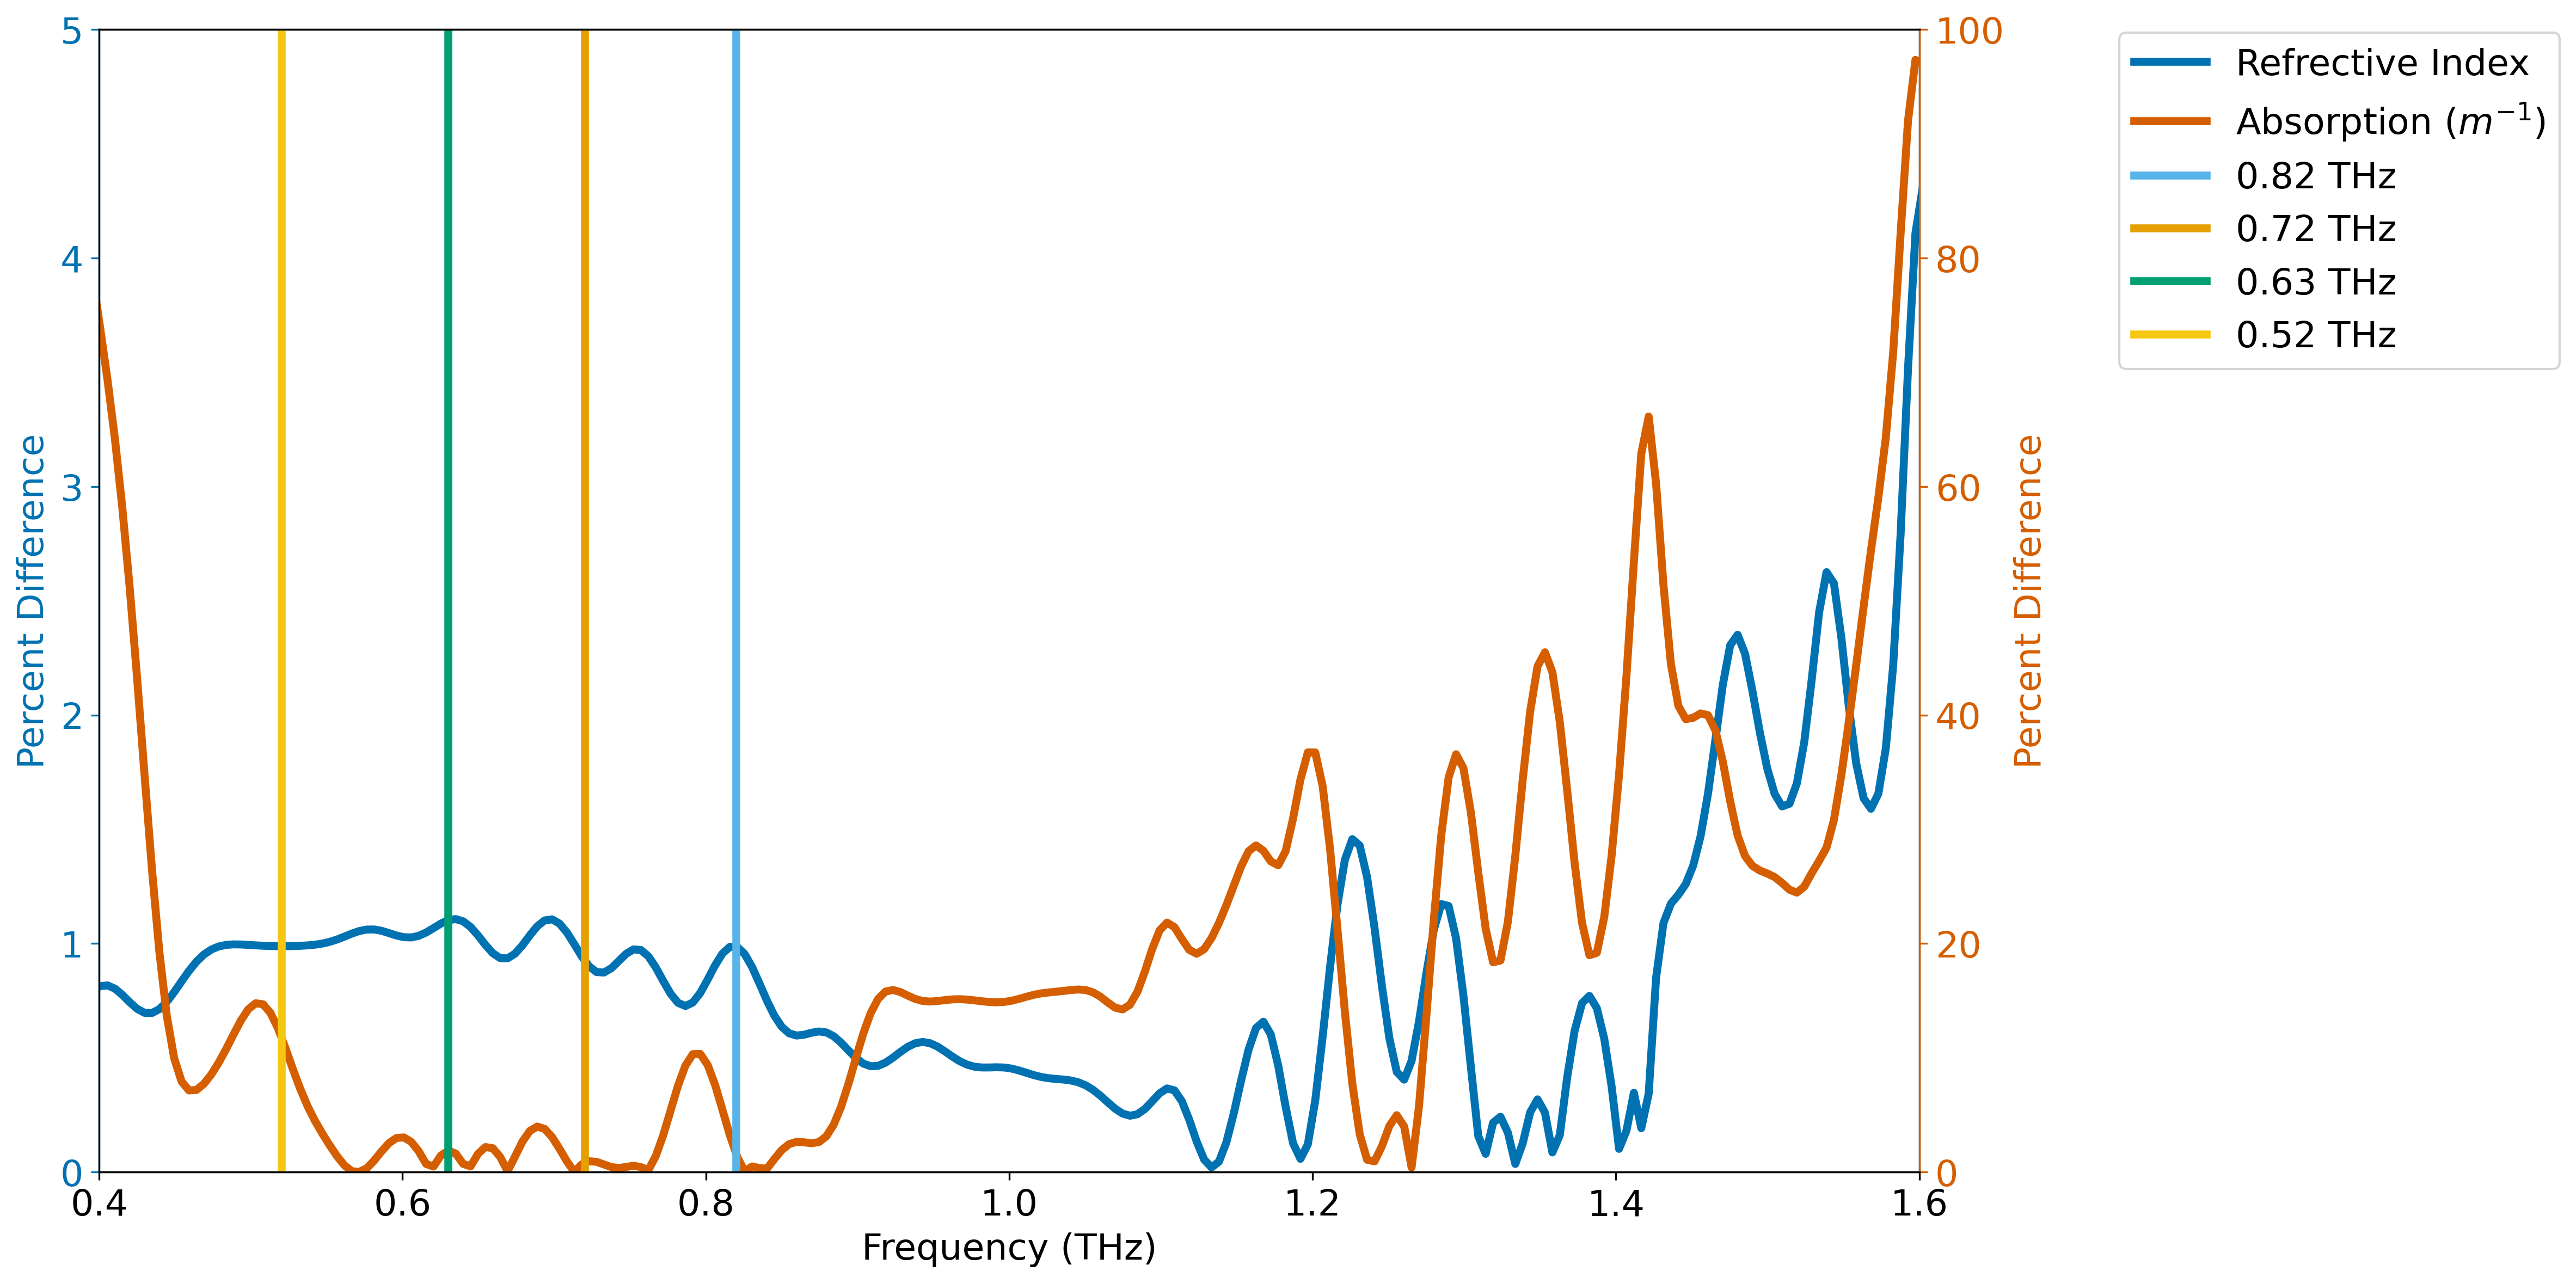

In [8]:
lga_ref = f4a[h4a[0]].T[1]
glu_ref = f4a[h4a[1]].T[1]
f_ref = f4a[h4a[0]].T[0]

lga_abs = f4b[h4b[0]].T[1]
glu_abs = f4b[h4b[1]].T[1]
f_abs = f4b[h4b[0]].T[0]


def r_diff(w1, w2):
    return 100 * np.abs(w1 - w2) / (0.5 * (np.abs(w1) + np.abs(w2)))
       
    

fig, ax1 = plt.subplots(figsize=(16,8), dpi=300)
#ax1.title()
ax1.plot(f_ref, r_diff(lga_ref, glu_ref), color = ok['navy'], label='Refrective Index')

ax1.set_xlabel("Frequency (THz)")
ax1.set_ylabel("Percent Difference", color=ok['navy'])
ax1.tick_params(axis='y', colors=ok['navy'])
ax1.spines['left'].set_color(ok['navy'])
ax1.set_xlim(0.4, 1.6)
ax1.set_ylim(0, 5)

ax2 = ax1.twinx()

ax2.plot(f_abs, r_diff(lga_abs, glu_abs), color=ok['red'], label='Absorption ($m^{-1}$)')
ax2.set_ylabel('Percent Difference', color=ok['red'])
ax2.tick_params(axis='y', colors=ok['red'])
ax2.spines['right'].set_color(ok['red'])
ax2.set_ylim(0, 100)

plt.axvline(0.82, color=ok['blue'], label='0.82 THz')
plt.axvline(0.72, color=ok['orange'], label='0.72 THz')
plt.axvline(0.63, color=ok['green'], label='0.63 THz')
plt.axvline(0.52, color=ok['amber'], label='0.52 THz')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.85))
plt.tight_layout()
plt.savefig('./Plots/Paper/RelativeDiff.pdf')
plt.show()

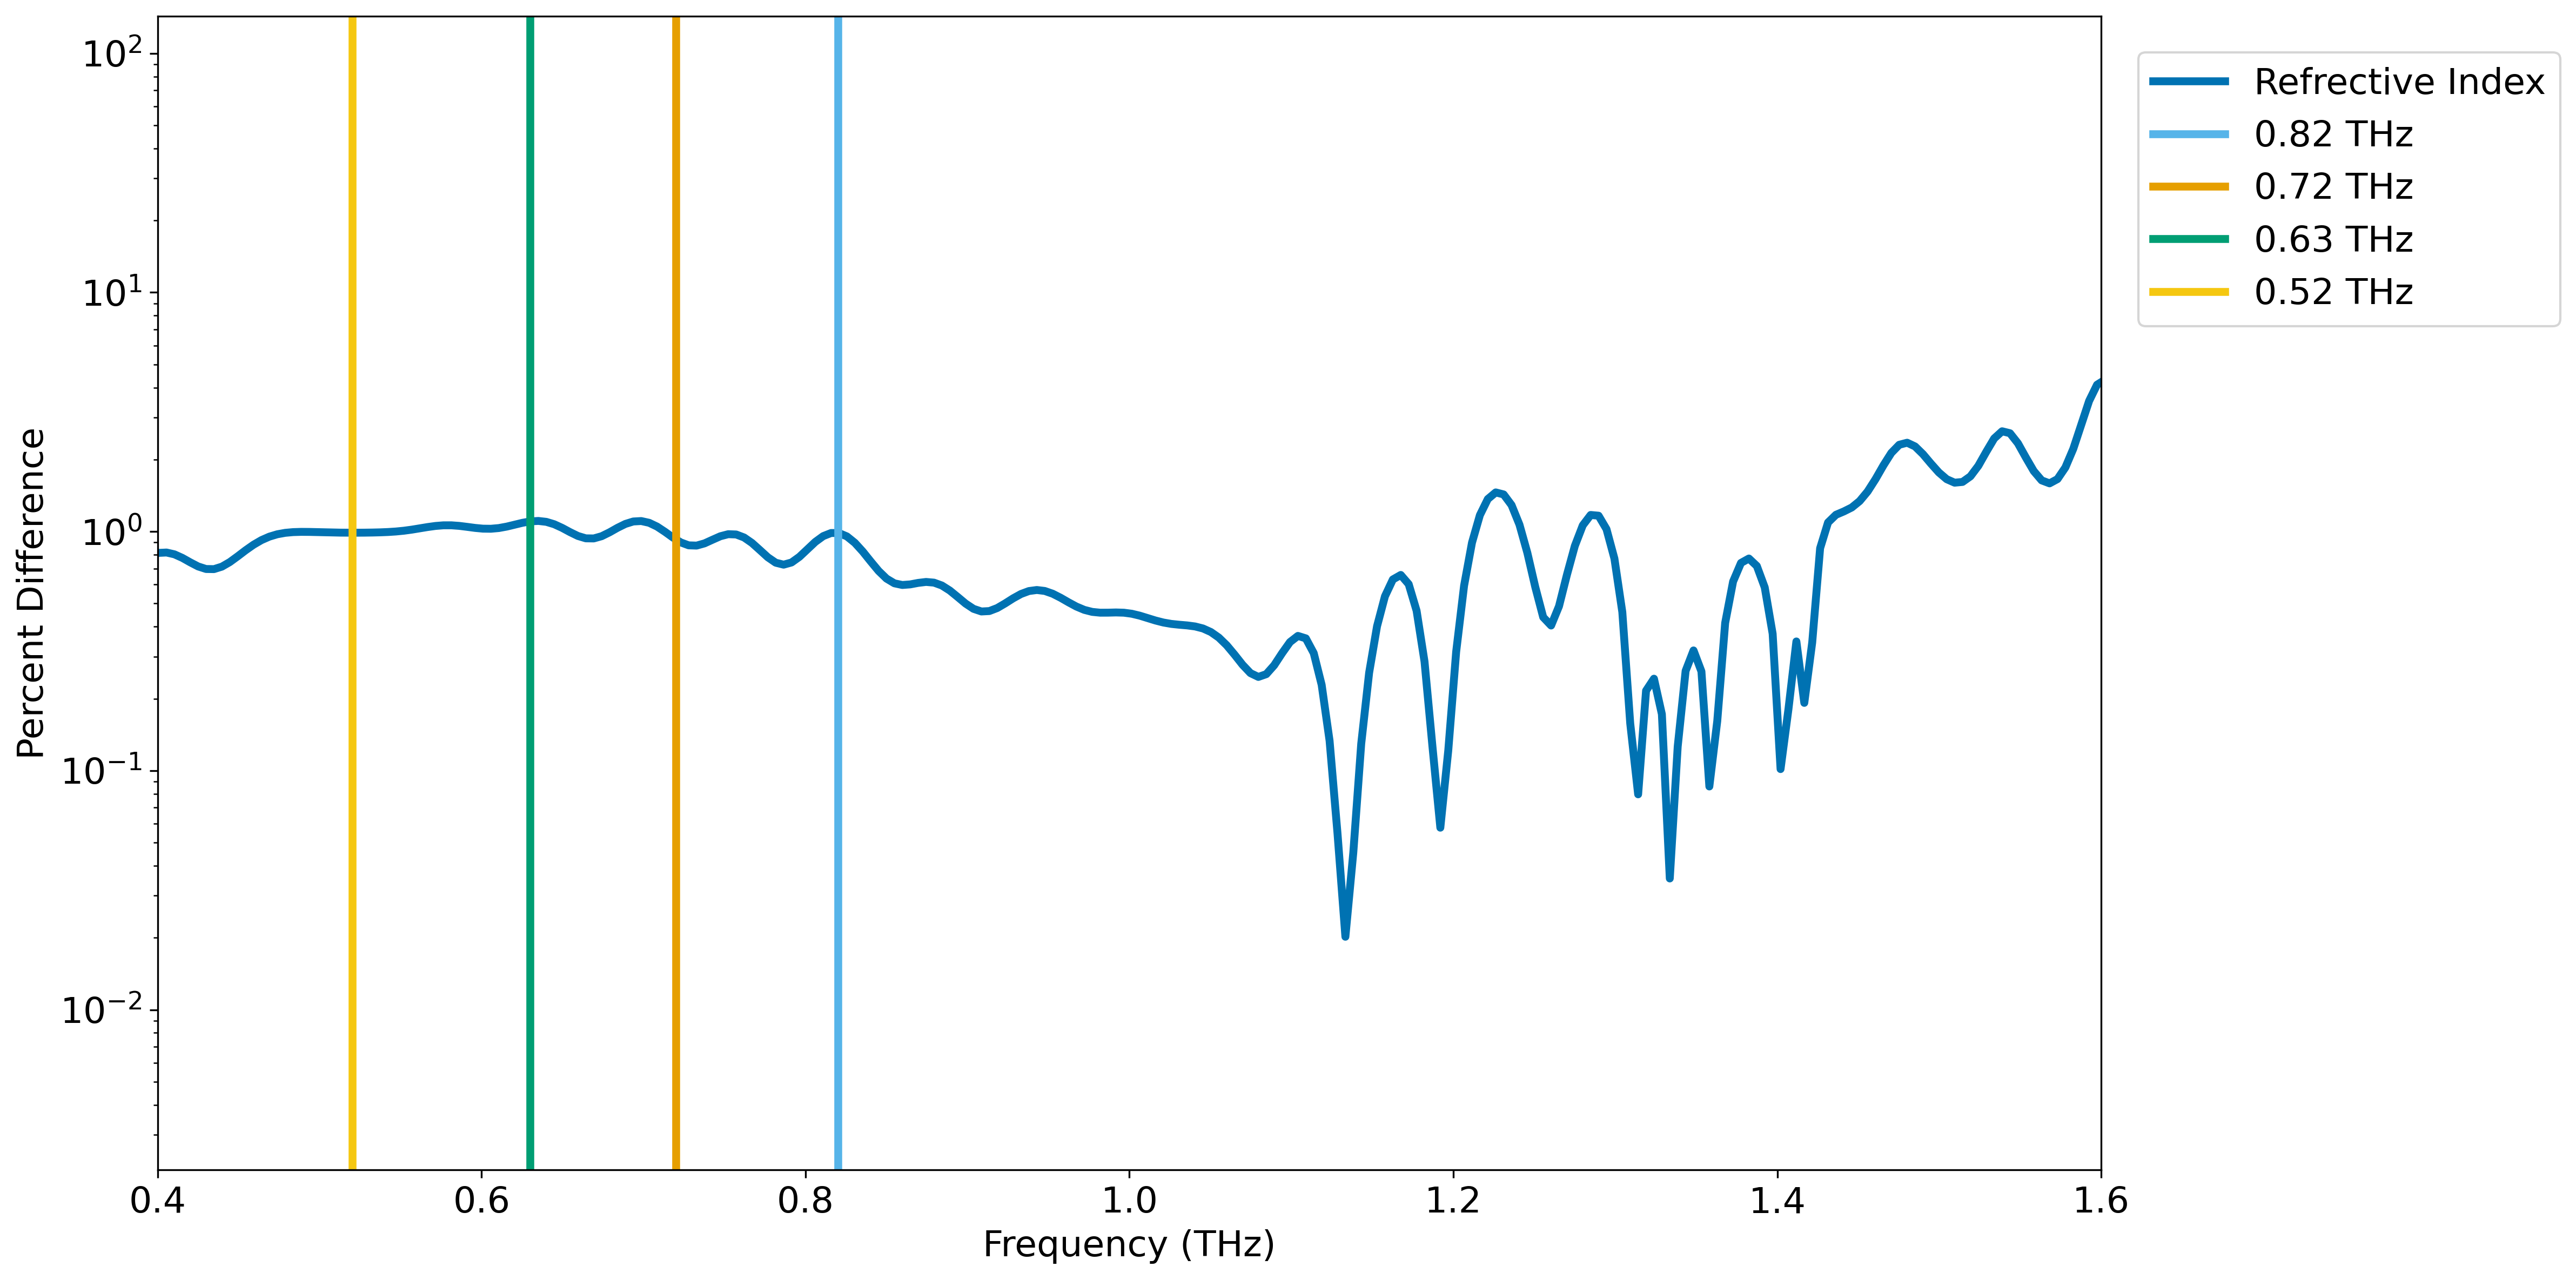

In [9]:
plt.figure(figsize=(16, 8), dpi=300)
plt.semilogy(f_ref, r_diff(lga_ref, glu_ref), color = ok['navy'], label='Refrective Index')
#plt.semilogy(f_abs, r_diff(lga_abs, glu_abs), color=ok['red'], label='Absorption ($m^{-1}$)')
plt.xlim(0.4, 1.6)
#plt.ylim(0, 100)
plt.axvline(0.82, color=ok['blue'], label='0.82 THz')
plt.axvline(0.72, color=ok['orange'], label='0.72 THz')
plt.axvline(0.63, color=ok['green'], label='0.63 THz')
plt.axvline(0.52, color=ok['amber'], label='0.52 THz')
plt.xlabel('Frequency (THz)')
plt.ylabel('Percent Difference')
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.85))
plt.tight_layout()
plt.savefig('./Plots/Paper/PercentDiff_RI_semilogy.pdf')
plt.show()

## Figure 5

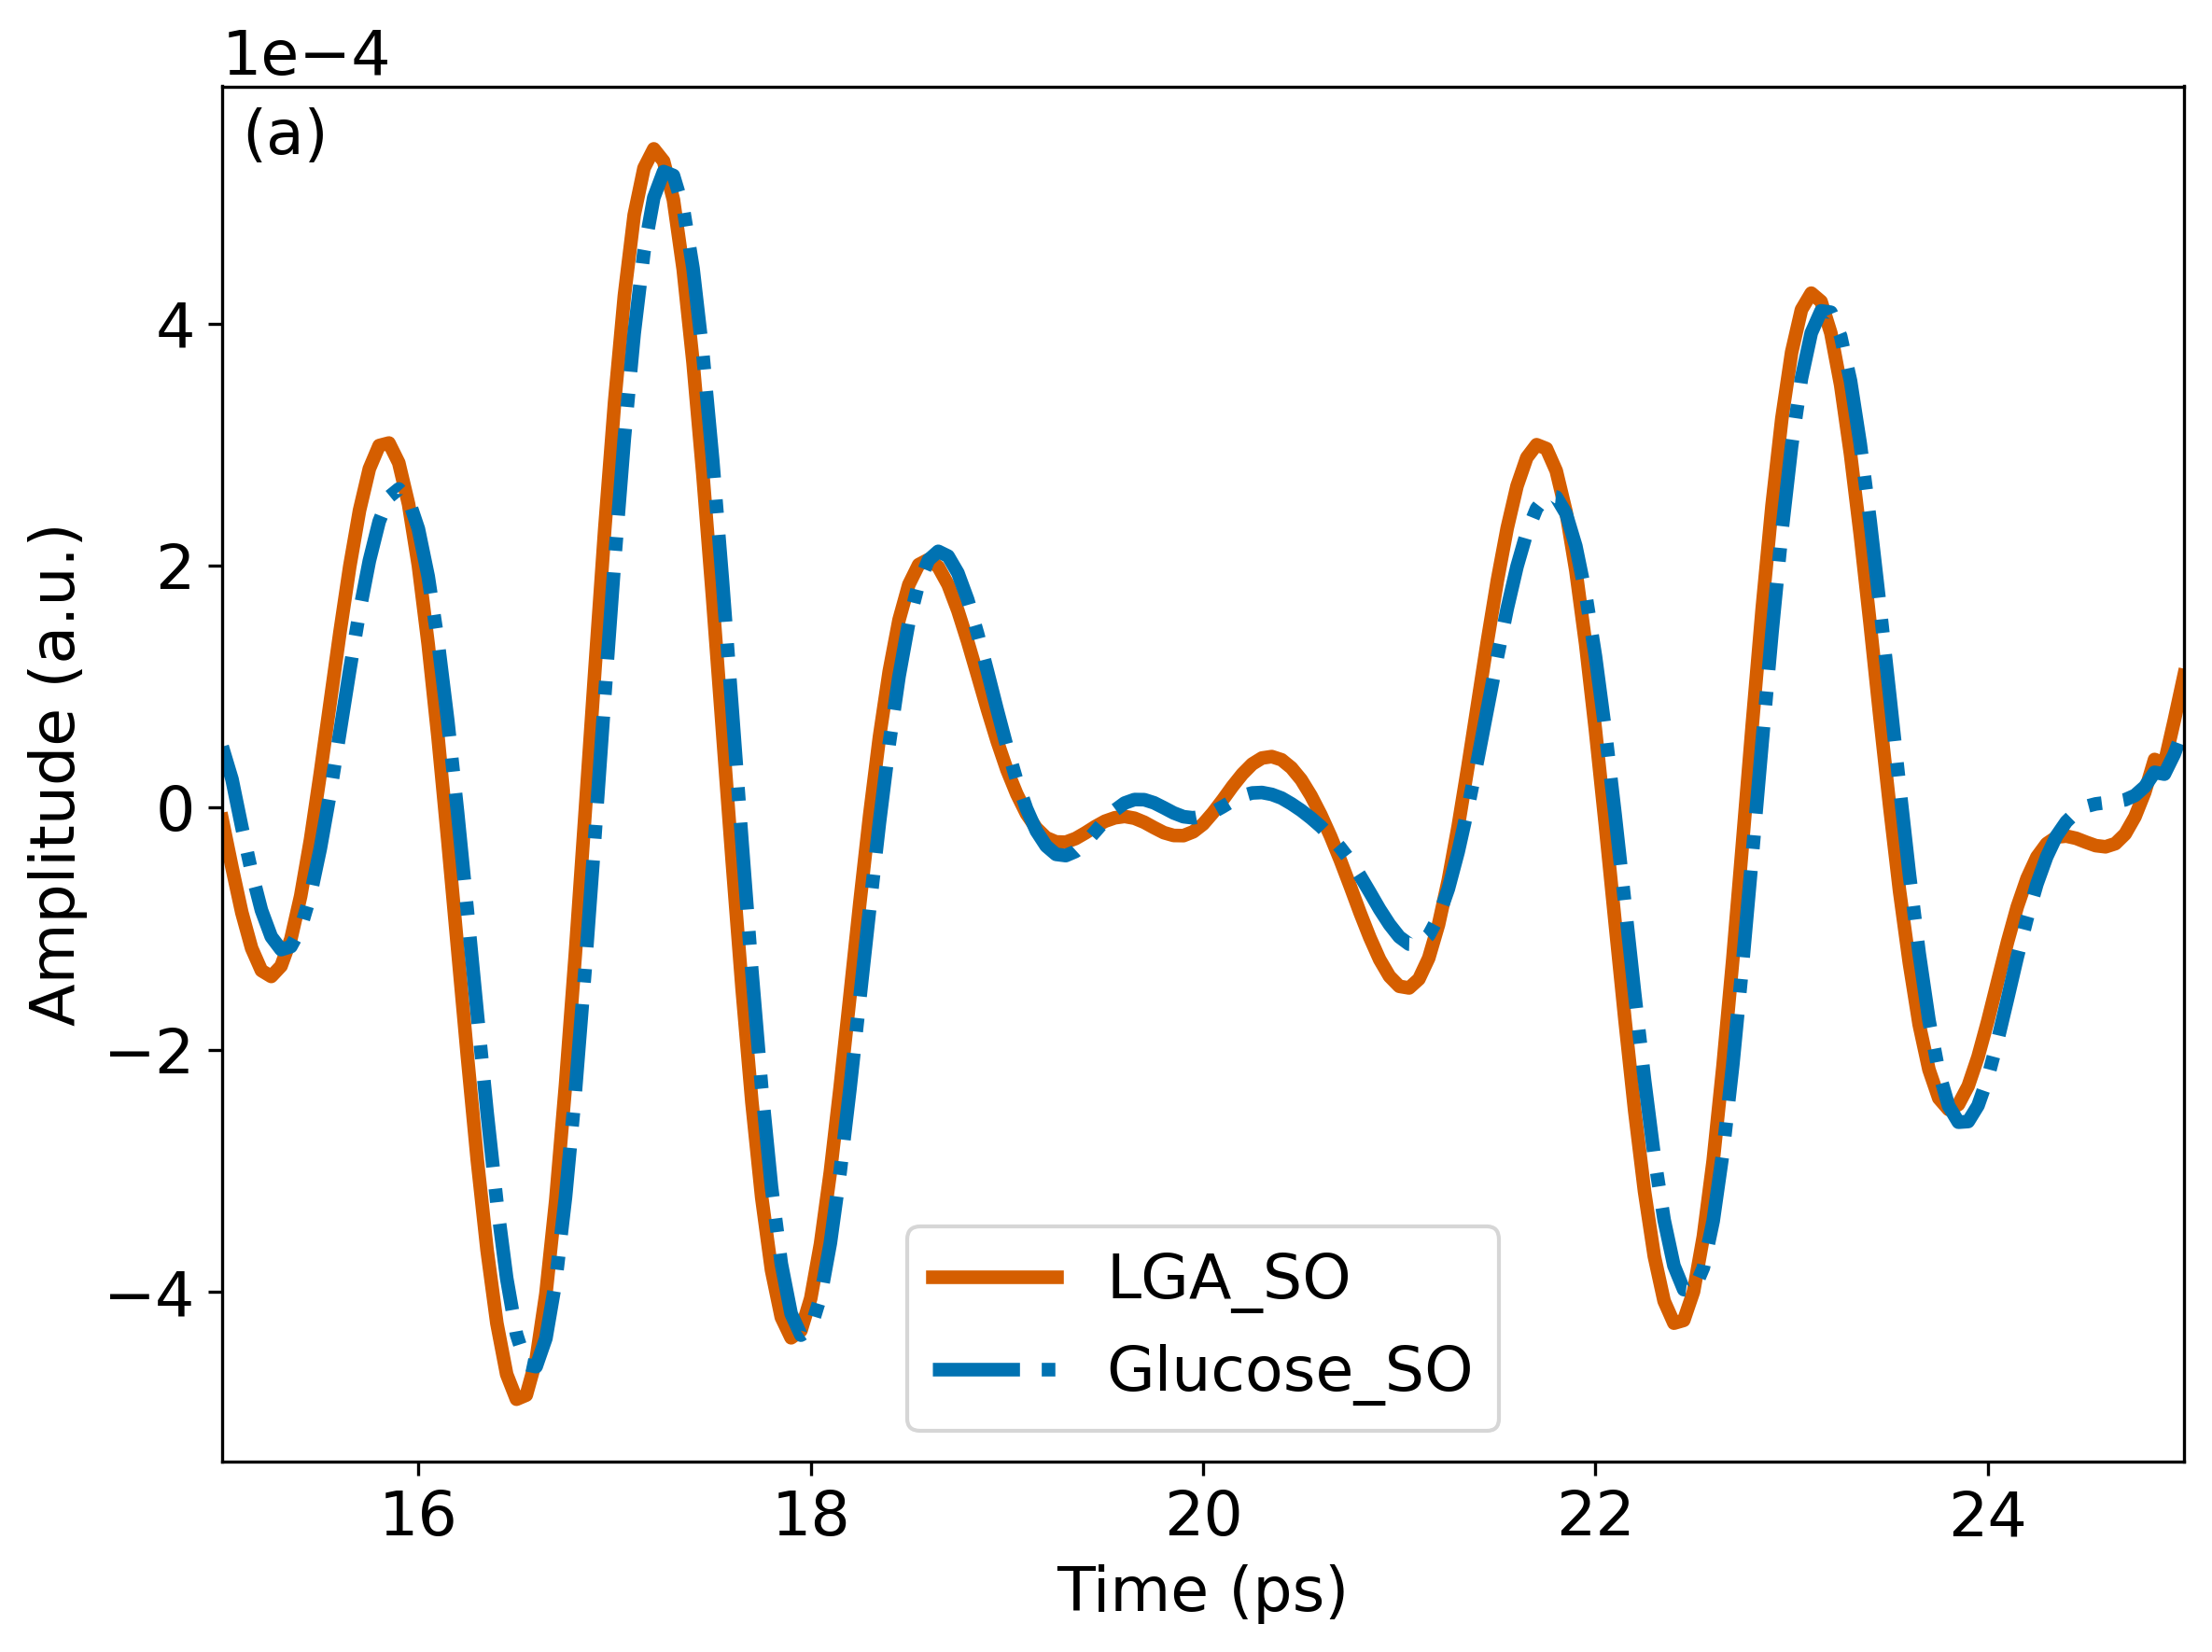

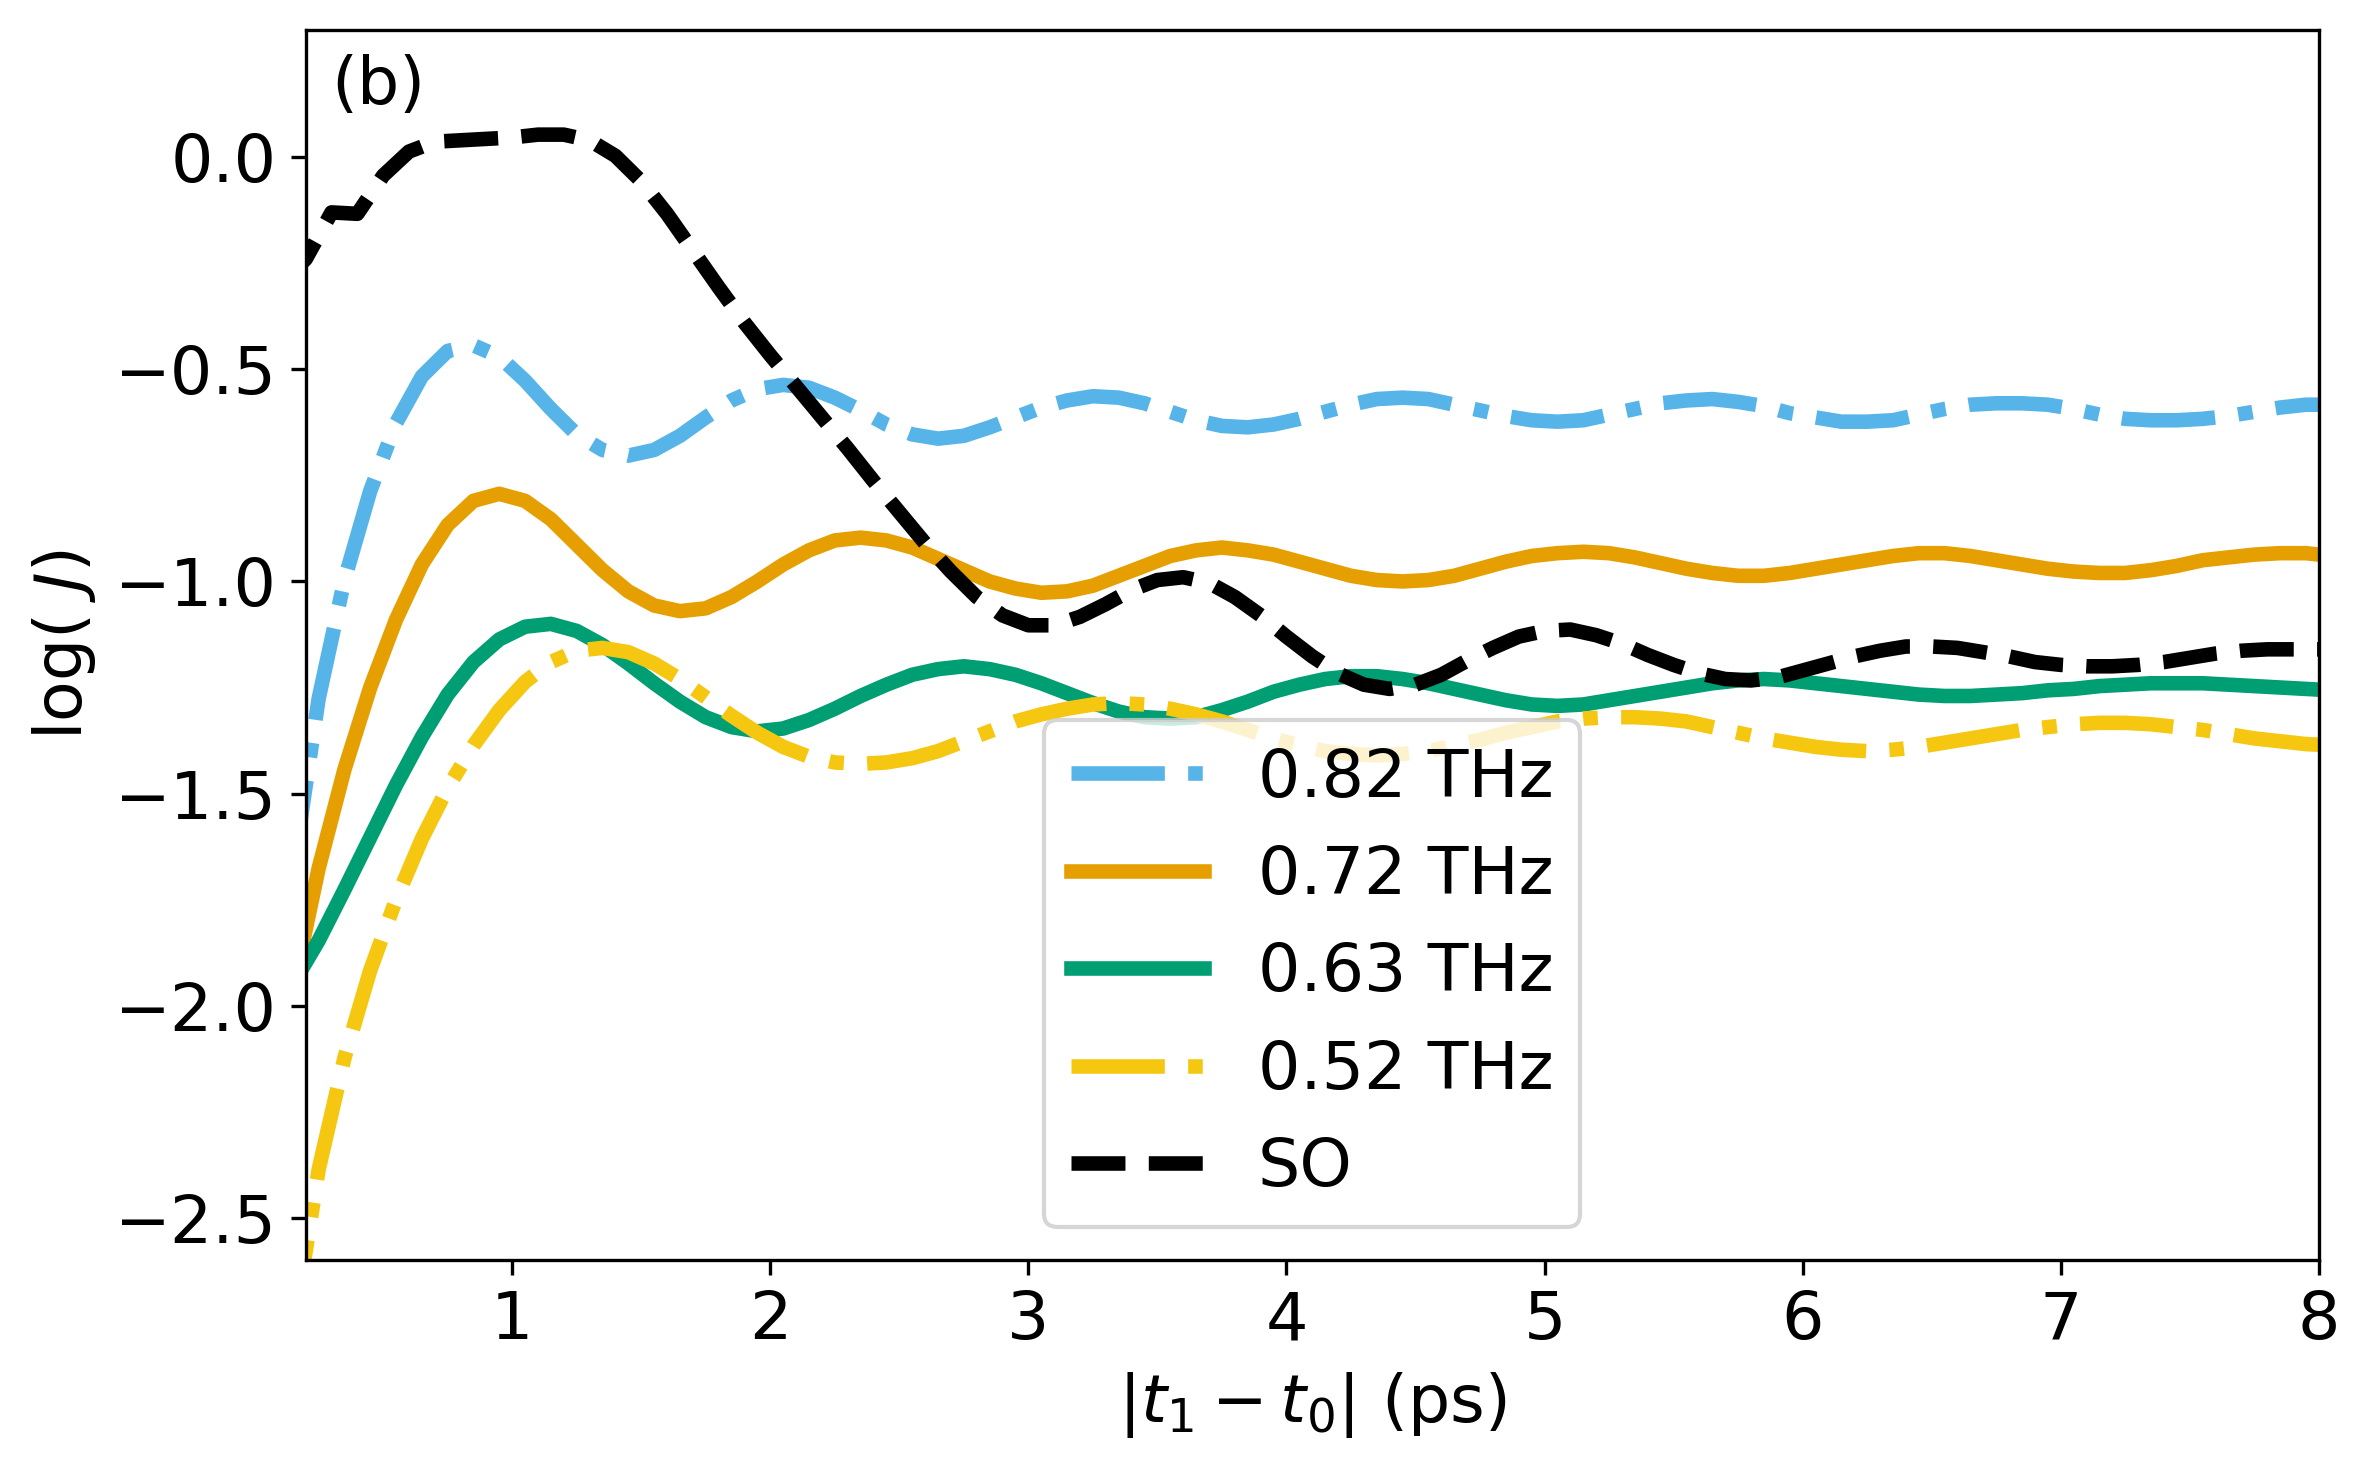

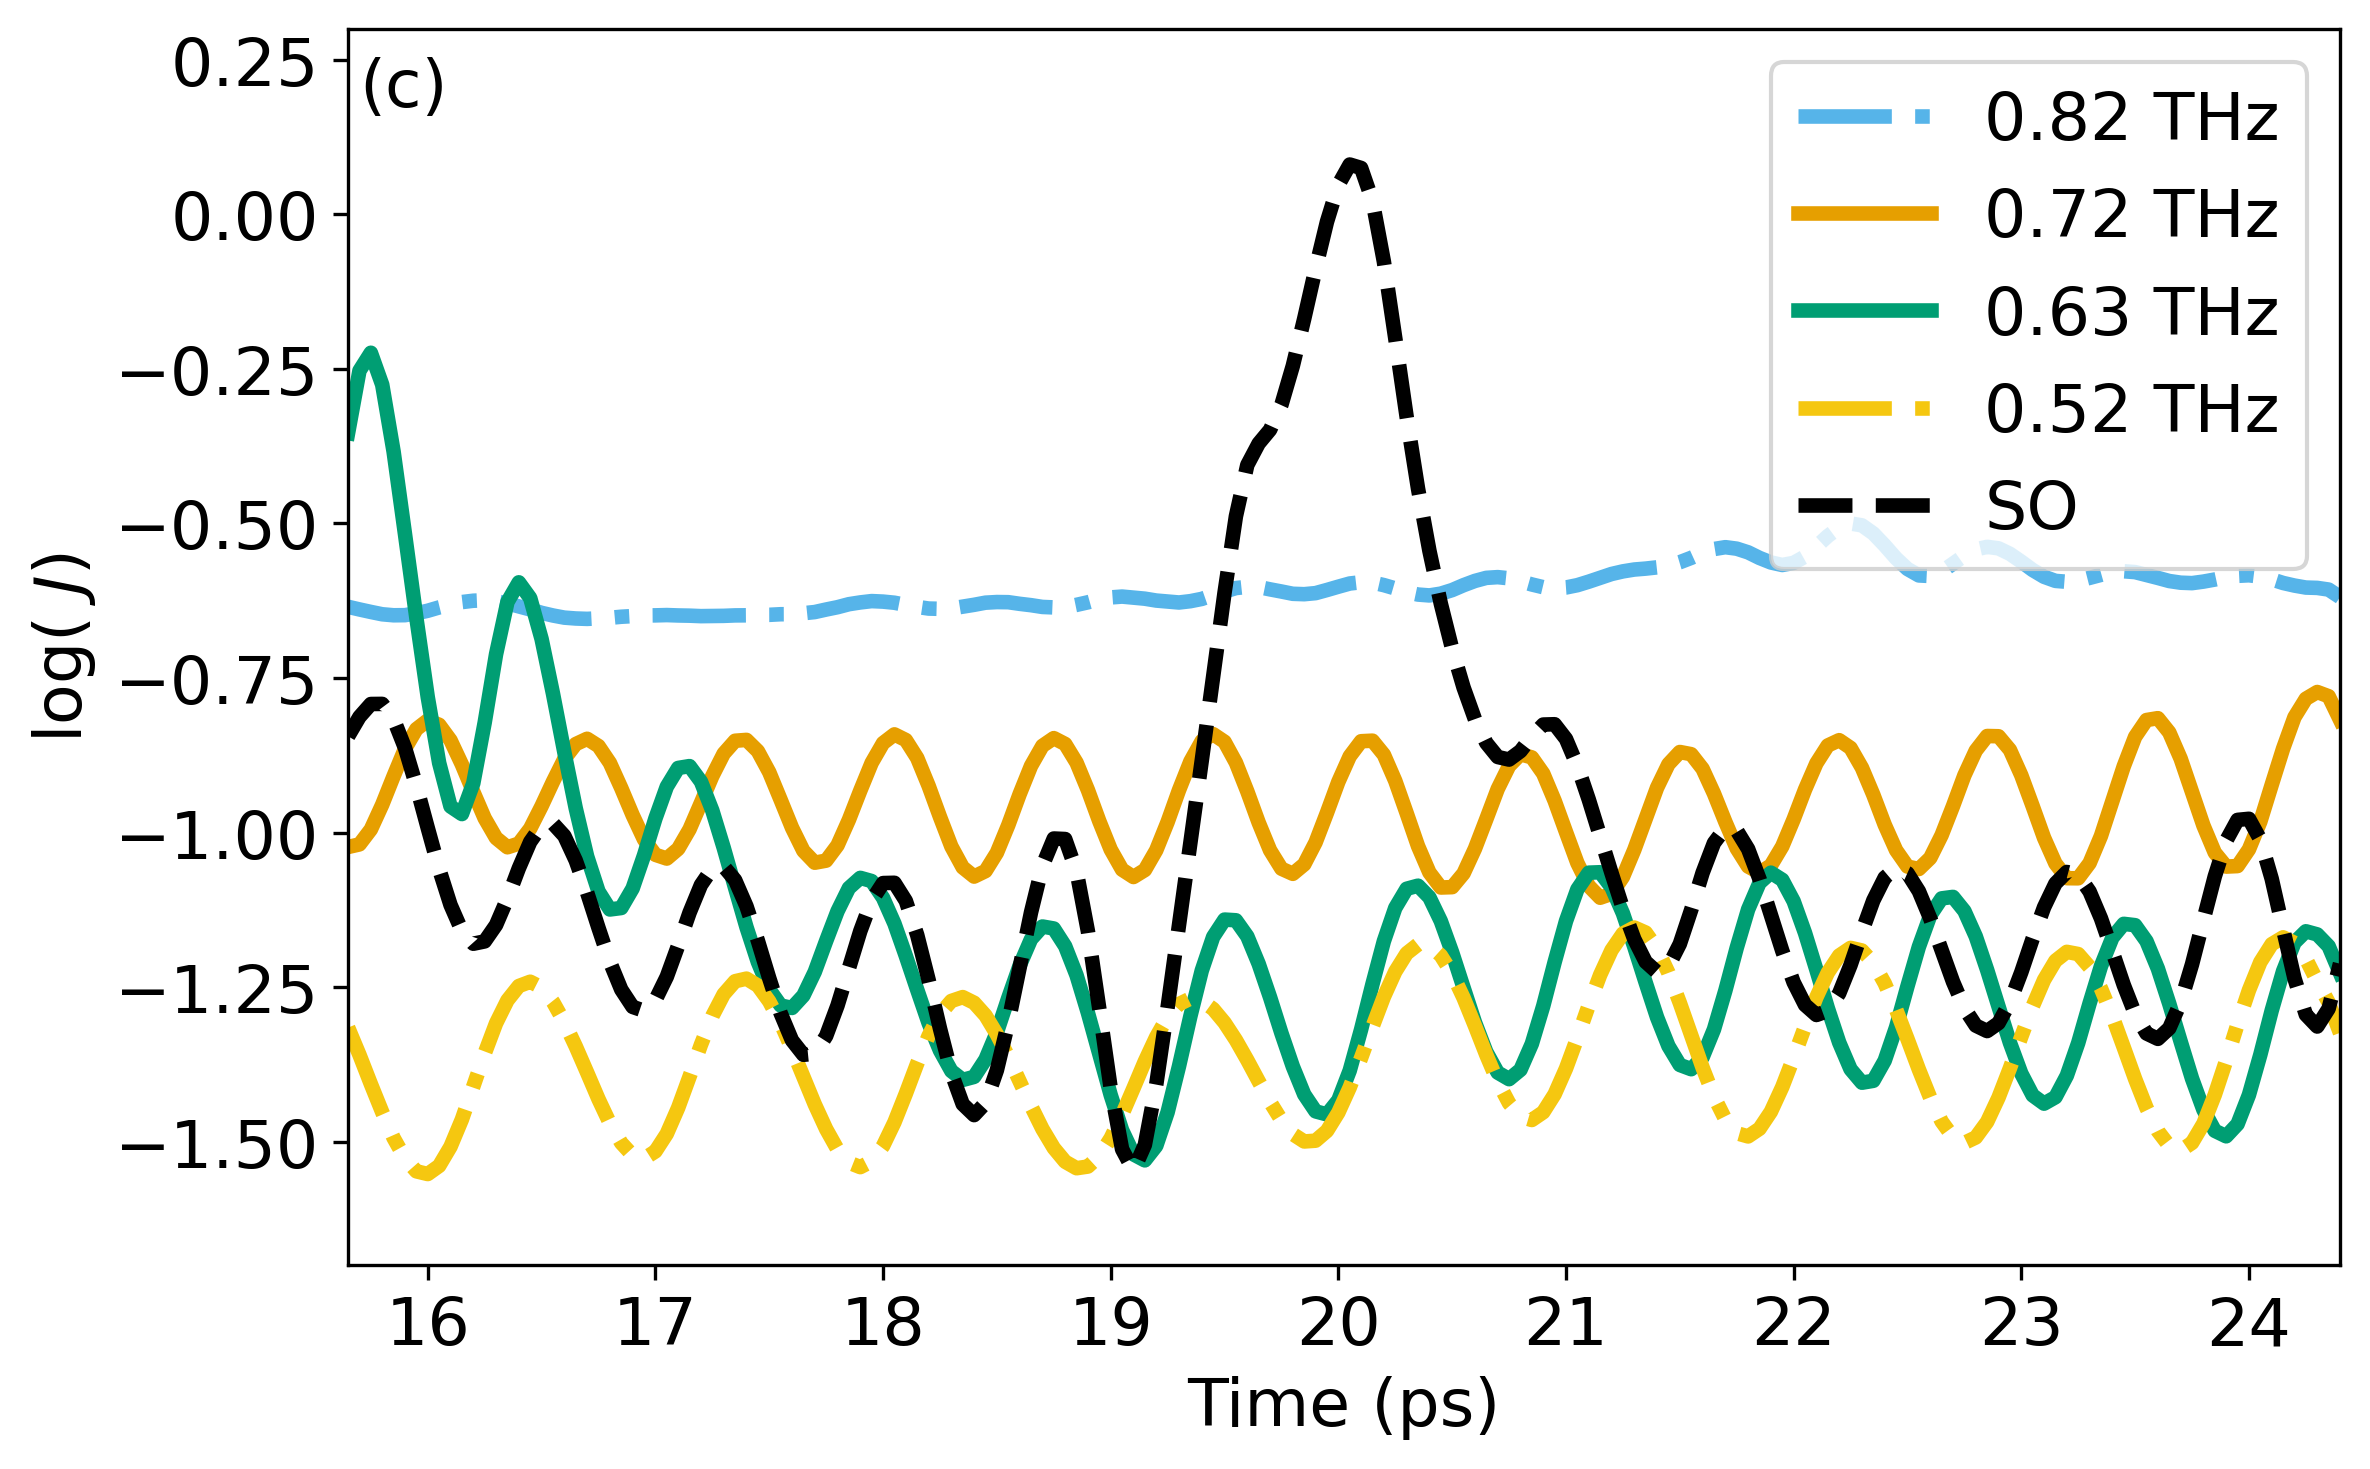

In [11]:
h5a = [_ for _ in f5a.keys()]
h5b = [_ for _ in f5b.keys()]
h5c = [_ for _ in f5c.keys()]

plt.figure(num=7)

plt.plot(f5a[h5a[0]].T[0], f5a[h5a[0]].T[1], color=ok['red'], label=h5a[0])
plt.plot(f5a[h5a[1]].T[0], f5a[h5a[1]].T[1], color=ok['navy'], linestyle='-.', label=h5a[1])
plt.xlim([f5a[h5a[0]].T[0][0],f5a[h5a[0]].T[0][-1]])
plt.xlabel("Time (ps)")
plt.ylabel("Amplitude (a.u.)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0.00052, 0.00052))
plt.legend()

plt.subplot().text(f5a[h5a[0]].T[0][0]+0.1, 5.4e-4, '(a)', fontsize=16)

plt.tight_layout()
plt.savefig('./Plots/Paper/Fig5a.pdf')
plt.show()

plt.figure(num=8, figsize=(8,5))
plt.plot(f5b[h5b[1]].T[0], f5b[h5b[1]].T[1], label=h5b[1], linestyle='-.')
plt.plot(f5b[h5b[2]].T[0], f5b[h5b[2]].T[1], label=h5b[2])
plt.plot(f5b[h5b[3]].T[0], f5b[h5b[3]].T[1], label=h5b[3])
plt.plot(f5b[h5b[4]].T[0], f5b[h5b[4]].T[1], label=h5b[4], linestyle='-.')
plt.plot(f5b[h5b[0]].T[0], f5b[h5b[0]].T[1], label=h5b[0], linestyle='--', color=ok['black'])

plt.subplot().text(f5b['SO'].T[0][-2]+0.1, 0.125, '(b)', fontsize=16)

plt.xlim([f5b['SO'].T[0][-2], 8])
plt.ylim([-2.6, 0.3])
plt.xlabel("$\|t_1 - t_0 \|$ (ps)")
plt.ylabel("log( $J$)")
plt.legend()
plt.tight_layout()
plt.savefig('./Plots/Paper/Fig5c.pdf')
plt.show()

plt.figure(num=9, figsize=(8,5))
plt.plot(f5c[h5c[1]].T[0], f5c[h5c[1]].T[1], label=h5c[1], linestyle='-.')
plt.plot(f5c[h5c[2]].T[0], f5c[h5c[2]].T[1], label=h5c[2])
plt.plot(f5c[h5c[3]].T[0], f5c[h5c[3]].T[1], label=h5c[3])
plt.plot(f5c[h5c[4]].T[0], f5c[h5c[4]].T[1], label=h5c[4], linestyle='-.')
plt.plot(f5c[h5c[0]].T[0], f5c[h5c[0]].T[1], label=h5c[0], linestyle='--', color=ok['black'])

plt.subplot().text(f5c[h5c[0]].T[0][0]+0.05, 0.175, '(c)', fontsize=16)

plt.xlim([f5c[h5c[0]].T[0][0],f5c[h5c[0]].T[0][-1]])
plt.ylim([-1.7, 0.3])
plt.xlabel("Time (ps)")
plt.ylabel("log( $J$)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./Plots/Paper/Fig5b.pdf')
plt.show()

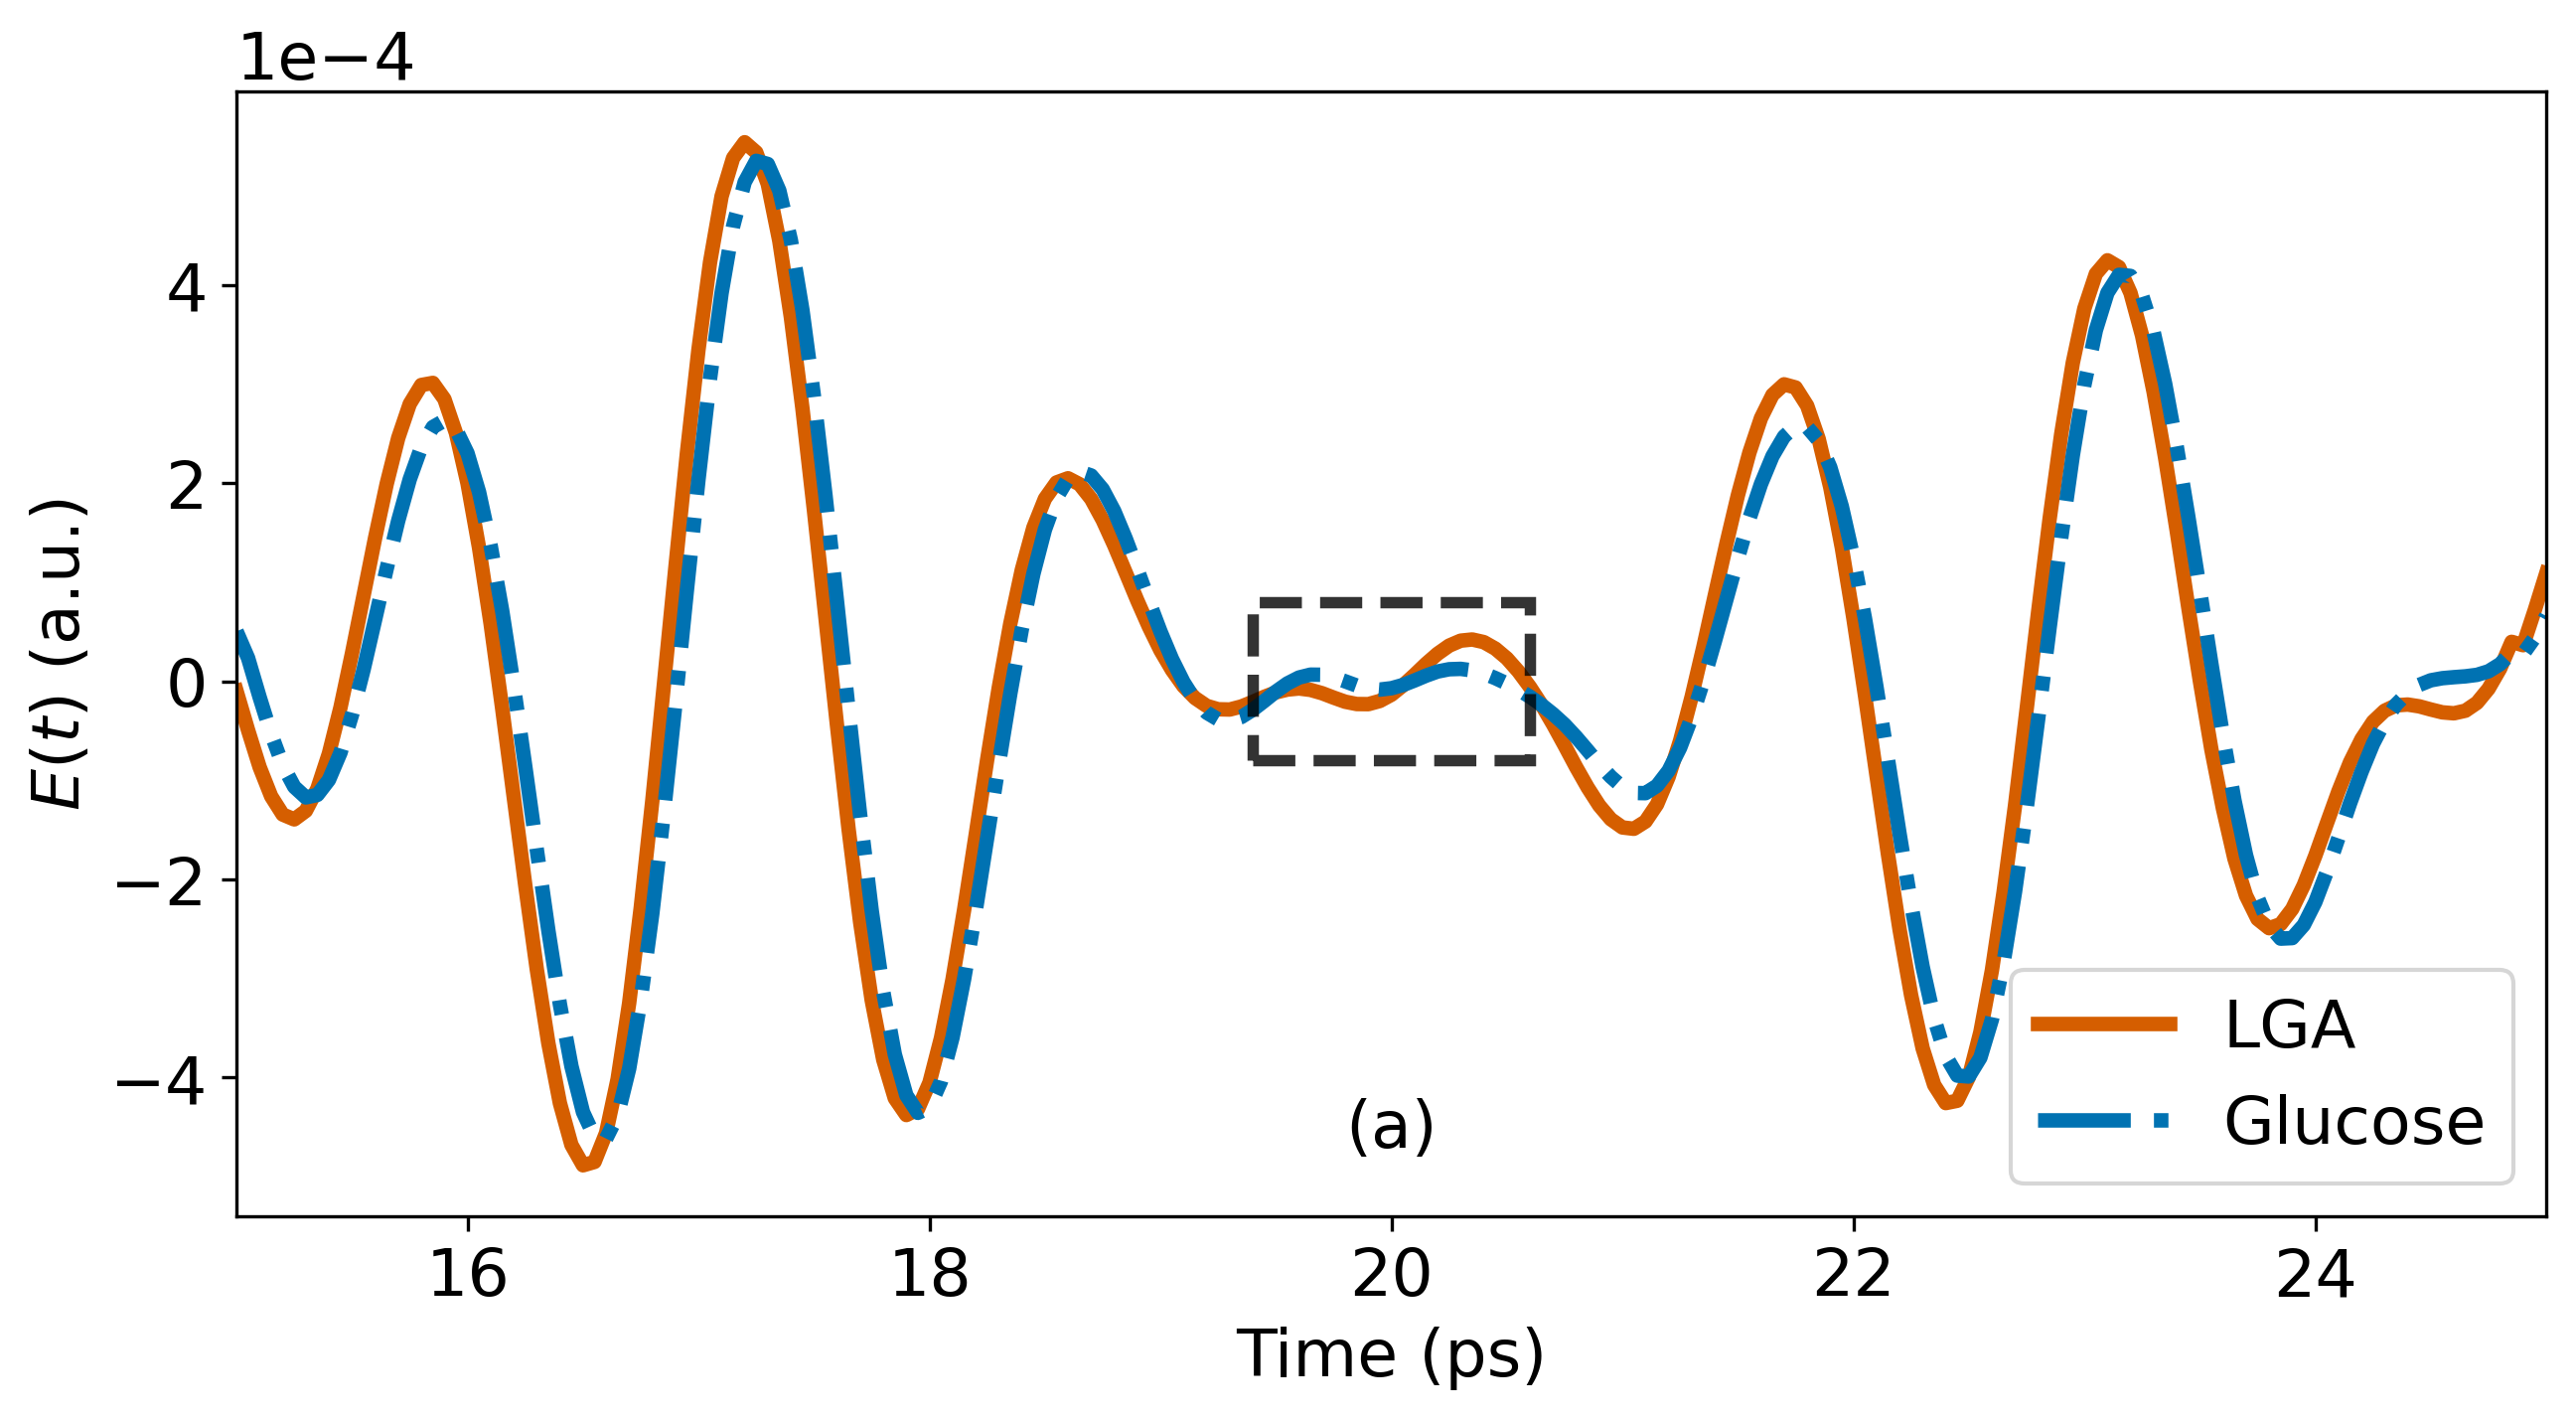

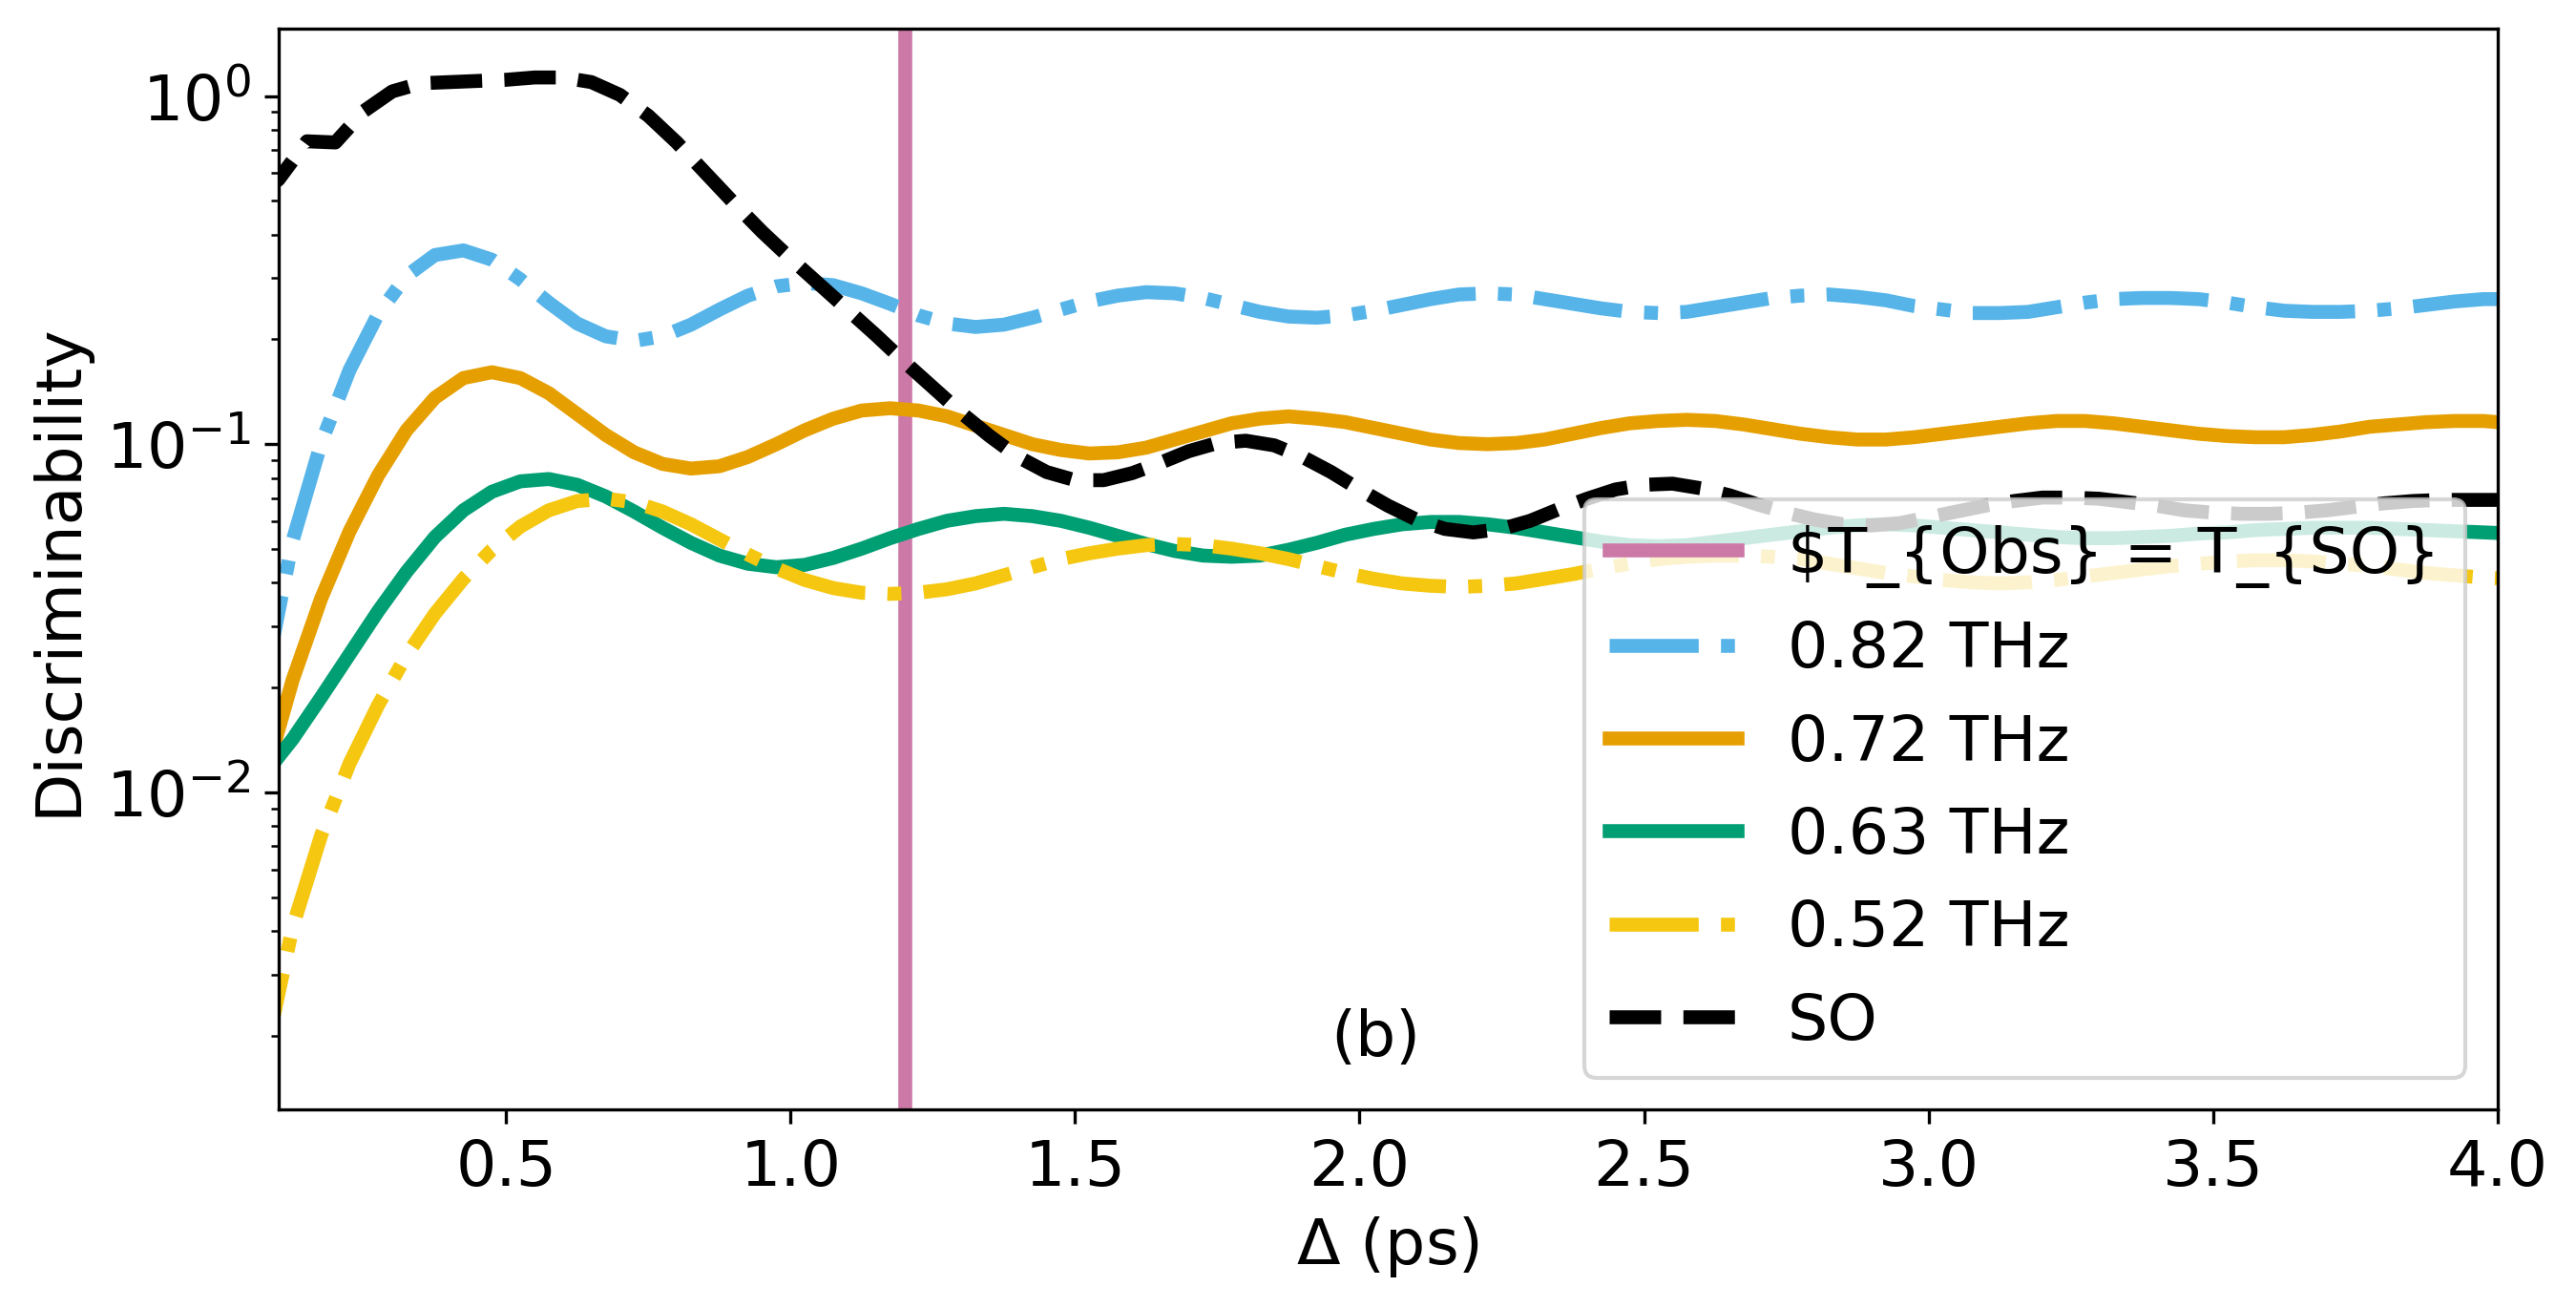

In [44]:
plt.figure(figsize=(10,5))

plt.plot(f5a[h5a[0]].T[0], f5a[h5a[0]].T[1], color=ok['red'], label="LGA")
plt.plot(f5a[h5a[1]].T[0], f5a[h5a[1]].T[1], color=ok['navy'], linestyle='-.', label="Glucose")
plt.xlim([f5a[h5a[0]].T[0][0],f5a[h5a[0]].T[0][-1]])
plt.xlabel("Time (ps)")
plt.ylabel("$E(t)$ (a.u.)")
plt.subplot().add_patch(
    patches.Rectangle((20-0.6, -.8e-4), 1.2, 1.6e-4, linestyle='--', linewidth=2.75, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3)) #, label='Superoscillating region'))
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0.00052, 0.00052))
plt.legend()
#plt.subplot().text(f5a[h5a[0]].T[0][0]+0.1, 5.2e-4, '(a)', fontsize=16)
plt.subplot().text(19.8, -4.7e-4, '(a)', fontsize=16)
#plt.tight_layout()
plt.savefig('./Plots/Paper/MeasuredWaves.pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(1.2, color=ok['purple'], label='$T_{Obs} = T_{SO}$')
plt.semilogy(f5b[h5b[1]].T[0] * 0.5, (10 ** f5b[h5b[1]]).T[1], label=h5b[1], linestyle='-.')
plt.semilogy(f5b[h5b[2]].T[0] * 0.5, (10 ** f5b[h5b[2]]).T[1], label=h5b[2])
plt.semilogy(f5b[h5b[3]].T[0] * 0.5, (10 ** f5b[h5b[3]]).T[1], label=h5b[3])
plt.semilogy(f5b[h5b[4]].T[0] * 0.5, (10 ** f5b[h5b[4]]).T[1], label=h5b[4], linestyle='-.')
plt.semilogy(f5b[h5b[0]].T[0] * 0.5, (10 ** f5b[h5b[0]]).T[1], label=h5b[0], linestyle='--', color=ok['black'])

plt.subplot().text(1.95, 1.75e-3, '(b)', fontsize=16)

plt.xlim([0.1, 4])
#plt.ylim([-2.62, 0.3])
plt.xlabel("$\Delta$ (ps)")
plt.ylabel("Discriminability")
plt.legend(loc='lower right')
#plt.tight_layout()
plt.savefig('./Plots/Paper/MeasuredJ.pdf')
plt.show()

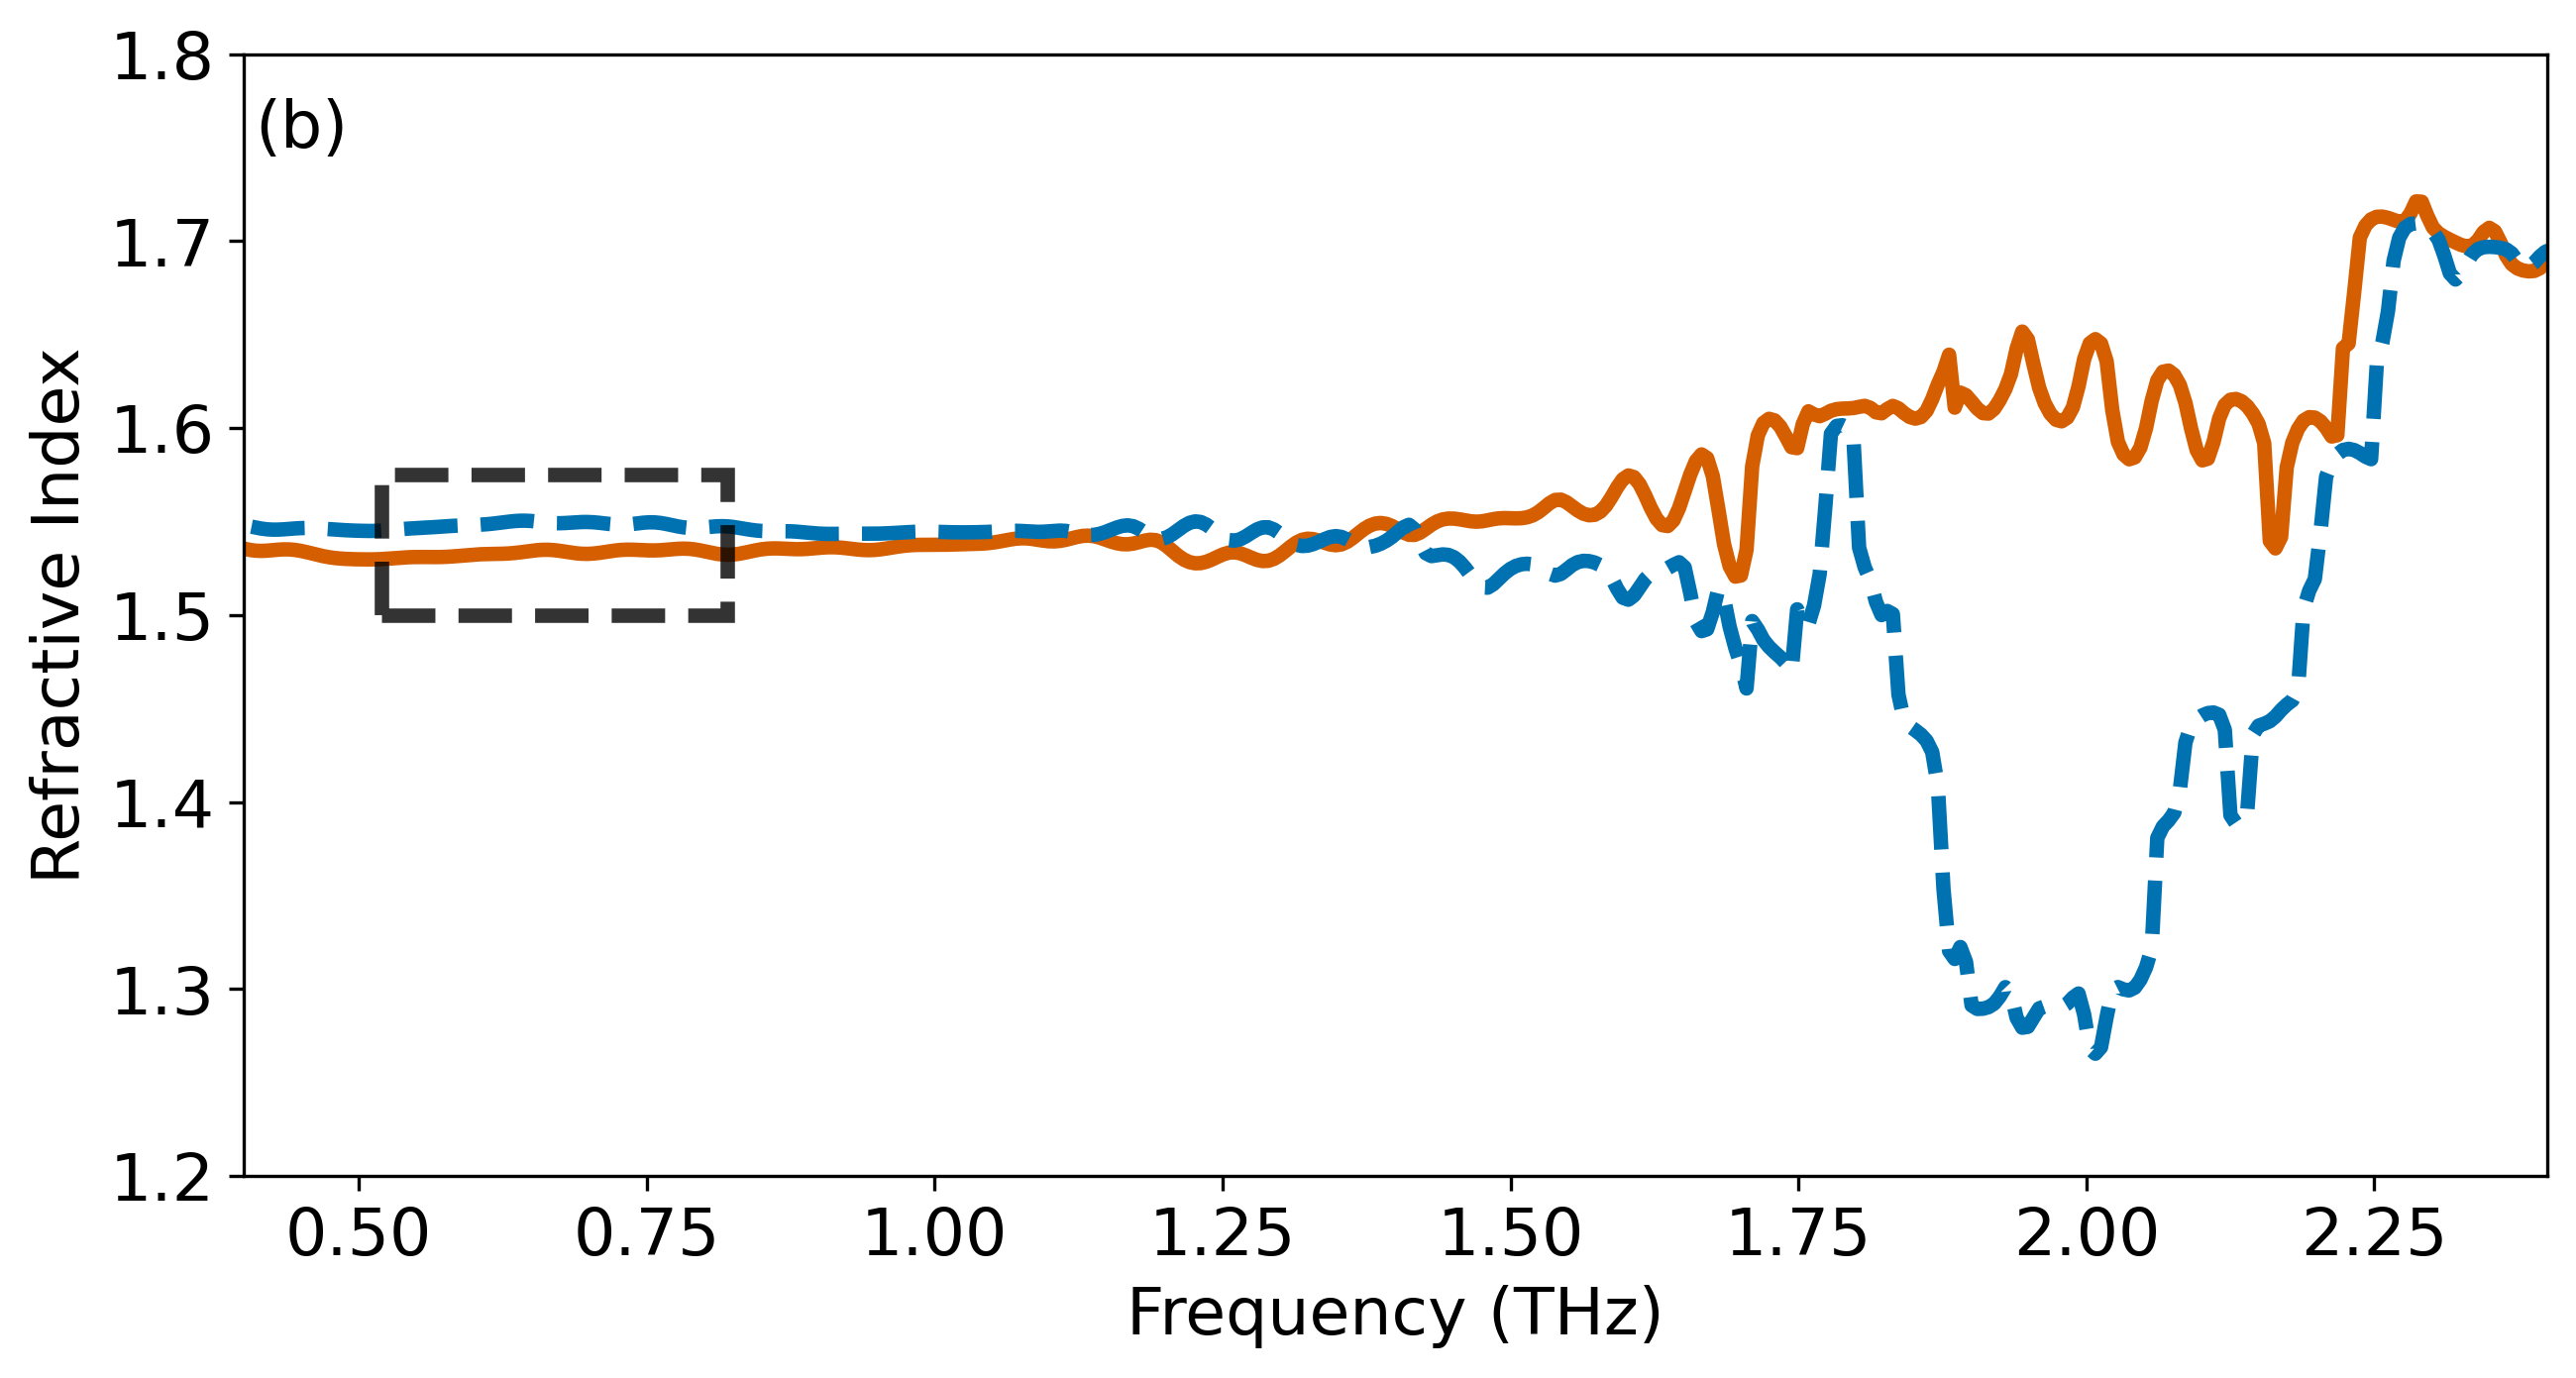

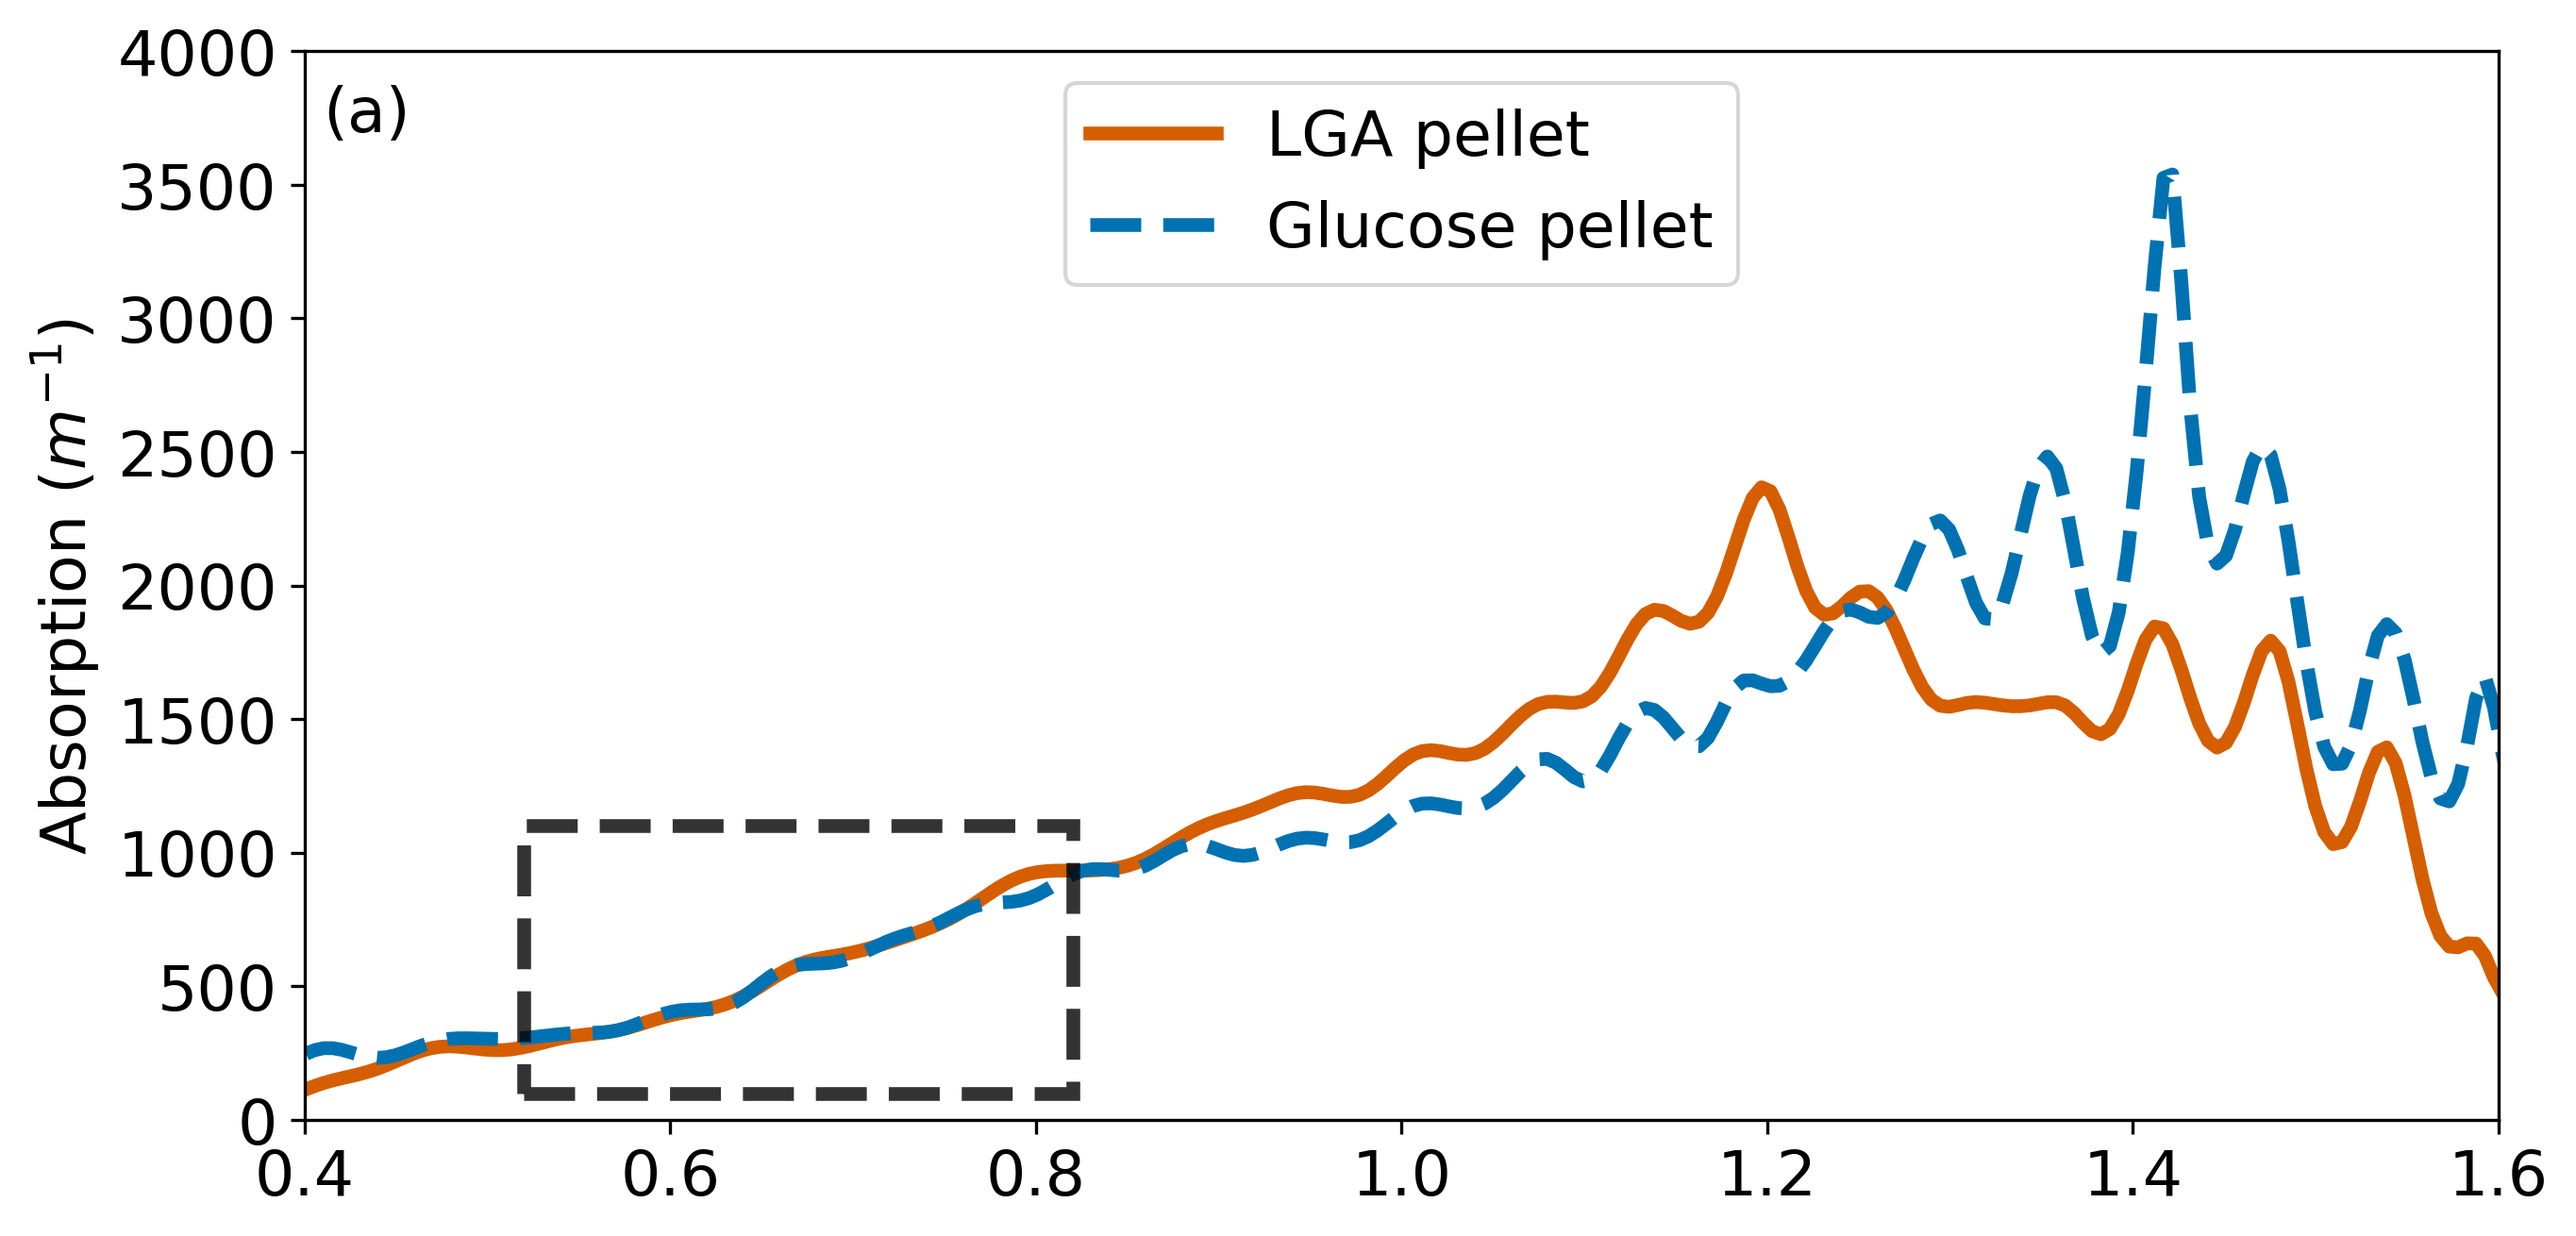

In [13]:
plt.figure(figsize=(10,5))
plt.plot(f4a[h4a[0]].T[0], f4a[h4a[0]].T[1], color=ok['red'], label=h4a[0])
plt.plot(f4a[h4a[1]].T[0], f4a[h4a[1]].T[1], color=ok['navy'], linestyle='--', label=h4a[1])
"""plt.axvline(0.52, color=ok['blue'], alpha=0.9, label='Fundamental Harmonics')
plt.axvline(0.63, color=ok['blue'], alpha=0.9)
plt.axvline(0.72, color=ok['blue'], alpha=0.9)
plt.axvline(0.82, color=ok['blue'], alpha=0.9)"""
plt.xlim([0.4, 2.4])
plt.ylim([1.2, 1.8])
plt.xlabel("Frequency (THz)")
plt.ylabel("Refractive Index")
#plt.legend(loc='upper center')

plt.subplot().add_patch(
    patches.Rectangle((0.52, 1.5), 0.3, 0.075, linestyle='--', linewidth=3.5, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3))
plt.subplot().text(0.41, 1.75, '(b)', fontsize=16)

#plt.tight_layout()
plt.savefig('./Plots/Paper/RefractiveIndex_Box_nolegend.pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(f4b[h4b[0]].T[0], np.abs(f4b[h4b[0]].T[1]), color=ok['red'], label=h4b[0])
plt.plot(f4b[h4b[1]].T[0], np.abs(f4b[h4b[1]].T[1]), color=ok['navy'], linestyle='--', label=h4b[1])
plt.subplot().add_patch(
    patches.Rectangle((0.52, 100), 0.3, 1000, linestyle='--', linewidth=3.5, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3))
"""plt.axvline(0.52, color=ok['blue'], alpha=0.9, label='Fundamental Harmonics')
plt.axvline(0.63, color=ok['blue'], alpha=0.9)
plt.axvline(0.72, color=ok['blue'], alpha=0.9)
plt.axvline(0.82, color=ok['blue'], alpha=0.9)"""
plt.subplot().text(0.41, 3700, '(a)', fontsize=16)
plt.xlim([0.4, 1.6])
plt.ylim([0, 4000])
#plt.xlabel("Frequency (THz)")
plt.ylabel("Absorption $(m^{-1})$")
plt.legend(loc='upper center')
#plt.gca().axes.xaxis.set_ticklabels([])
#plt.tight_layout()
plt.savefig('./Plots/Paper/Absorption_Box.pdf')
plt.show()

In [14]:
glucose = np.load('./ExpData/Glucose_SO.npz')
lga = np.load('./ExpData/LGA_SO.npz')
thz052_glu = np.load('./ExpData/Glucose_F05.npz')
thz063_glu = np.load('./ExpData/Glucose_F06.npz')
thz072_glu = np.load('./ExpData/Glucose_F07.npz')
thz082_glu = np.load('./ExpData/Glucose_F08.npz')
thz052_lga = np.load('./ExpData/LGA_F05.npz')
thz063_lga = np.load('./ExpData/LGA_F06.npz')
thz072_lga = np.load('./ExpData/LGA_F07.npz')
thz082_lga = np.load('./ExpData/LGA_F08.npz')

In [15]:
test = [_ for _ in  lga.keys()]
print(test)

['time', 'amplitude']


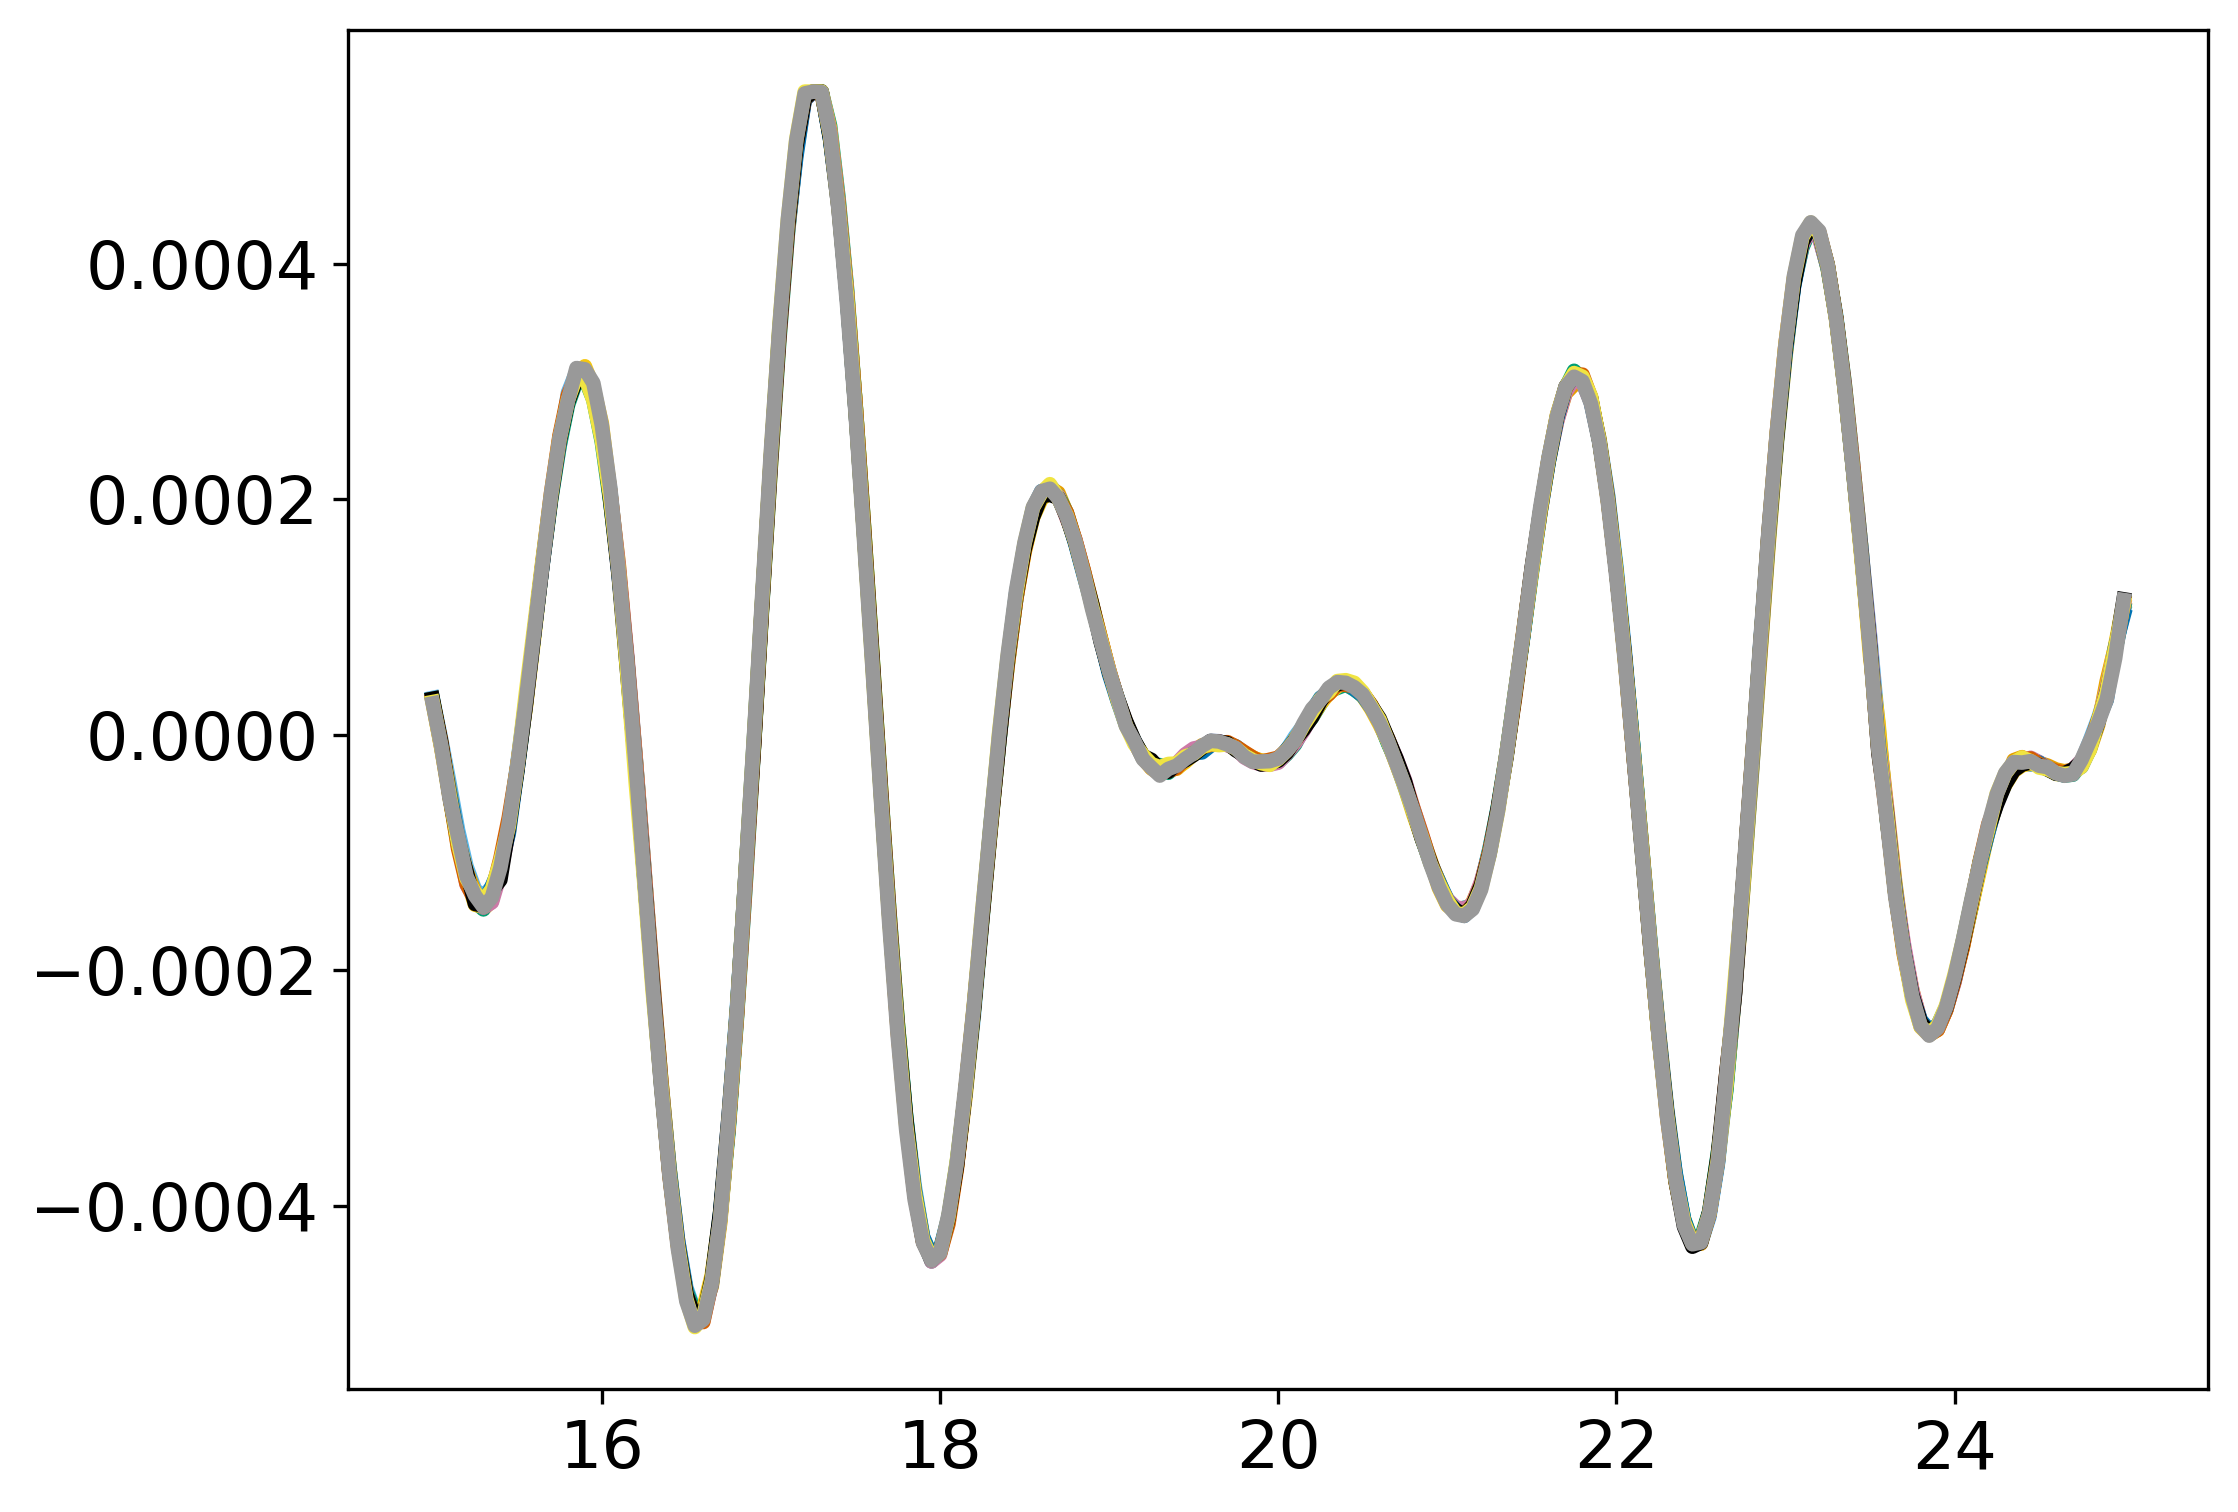

In [16]:
lga_amps = lga['amplitude'].T
lga_times = lga['time'].T
glu_amps = glucose['amplitude'].T
glu_times = glucose['time'].T
glu_thz05_amp = thz052_glu['amplitude'].T
glu_thz06_amp = thz063_glu['amplitude'].T
glu_thz07_amp = thz072_glu['amplitude'].T
glu_thz08_amp = thz082_glu['amplitude'].T
lga_thz05_amp = thz052_lga['amplitude'].T
lga_thz06_amp = thz063_lga['amplitude'].T
lga_thz07_amp = thz072_lga['amplitude'].T
lga_thz08_amp = thz082_lga['amplitude'].T
glu_thz05_t = thz052_glu['time'].T
glu_thz06_t = thz063_glu['time'].T
glu_thz07_t = thz072_glu['time'].T
glu_thz08_t = thz082_glu['time'].T
lga_thz05_t = thz052_lga['time'].T
lga_thz06_t = thz063_lga['time'].T
lga_thz07_t = thz072_lga['time'].T
lga_thz08_t = thz082_lga['time'].T
glu_source = [thz052_glu['amplitude'].T, 
              thz063_glu['amplitude'].T, 
              thz072_glu['amplitude'].T,
              thz082_glu['amplitude'].T]
lga_source = [thz052_lga['amplitude'].T, 
              thz063_lga['amplitude'].T, 
              thz072_lga['amplitude'].T,
              thz082_lga['amplitude'].T]
source_times = glu_times[0]- 20

for _ in range(0, len(lga_times)):
    plt.plot(lga_times[_], lga_amps[_])

In [17]:
print(source_times)
print(len(source_times))
print((source_times[-1] - source_times[0])/2)
print(np.sum(lga_thz05_t != lga_thz06_t))

[-5.   -4.95 -4.9  -4.85 -4.8  -4.75 -4.7  -4.65 -4.6  -4.55 -4.5  -4.45
 -4.4  -4.35 -4.3  -4.25 -4.2  -4.15 -4.1  -4.05 -4.   -3.95 -3.9  -3.85
 -3.8  -3.75 -3.7  -3.65 -3.6  -3.55 -3.5  -3.45 -3.4  -3.35 -3.3  -3.25
 -3.2  -3.15 -3.1  -3.05 -3.   -2.95 -2.9  -2.85 -2.8  -2.75 -2.7  -2.65
 -2.6  -2.55 -2.5  -2.45 -2.4  -2.35 -2.3  -2.25 -2.2  -2.15 -2.1  -2.05
 -2.   -1.95 -1.9  -1.85 -1.8  -1.75 -1.7  -1.65 -1.6  -1.55 -1.5  -1.45
 -1.4  -1.35 -1.3  -1.25 -1.2  -1.15 -1.1  -1.05 -1.   -0.95 -0.9  -0.85
 -0.8  -0.75 -0.7  -0.65 -0.6  -0.55 -0.5  -0.45 -0.4  -0.35 -0.3  -0.25
 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35
  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95
  1.    1.05  1.1   1.15  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55
  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15
  2.2   2.25  2.3   2.35  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75
  2.8   2.85  2.9   2.95  3.    3.05  3.1   3.15  3

In [18]:
average_lga = f5a[h5a[0]].T[1]
average_glu = f5a[h5a[1]].T[1]
err_lga_arr = []
err_glu_arr = []

def get_std_err(ampl_array, avg):
    error_array = np.zeros(len(avg))
    for _ in ampl_array:
        error_array += _ - avg
    return np.sqrt(error_array ** 2) / len(ampl_array
                                          )
std_err_lga = get_std_err(lga_amps, average_lga) #np.sqrt(np.sum(_ - average_lga for _ in lga_amps) ** 2) / len(lga_amps)
std_err_glu = get_std_err(glu_amps, average_glu) #np.sqrt(np.sum(_ - average_glu for _ in glu_amps) ** 2) / len(glu_amps)

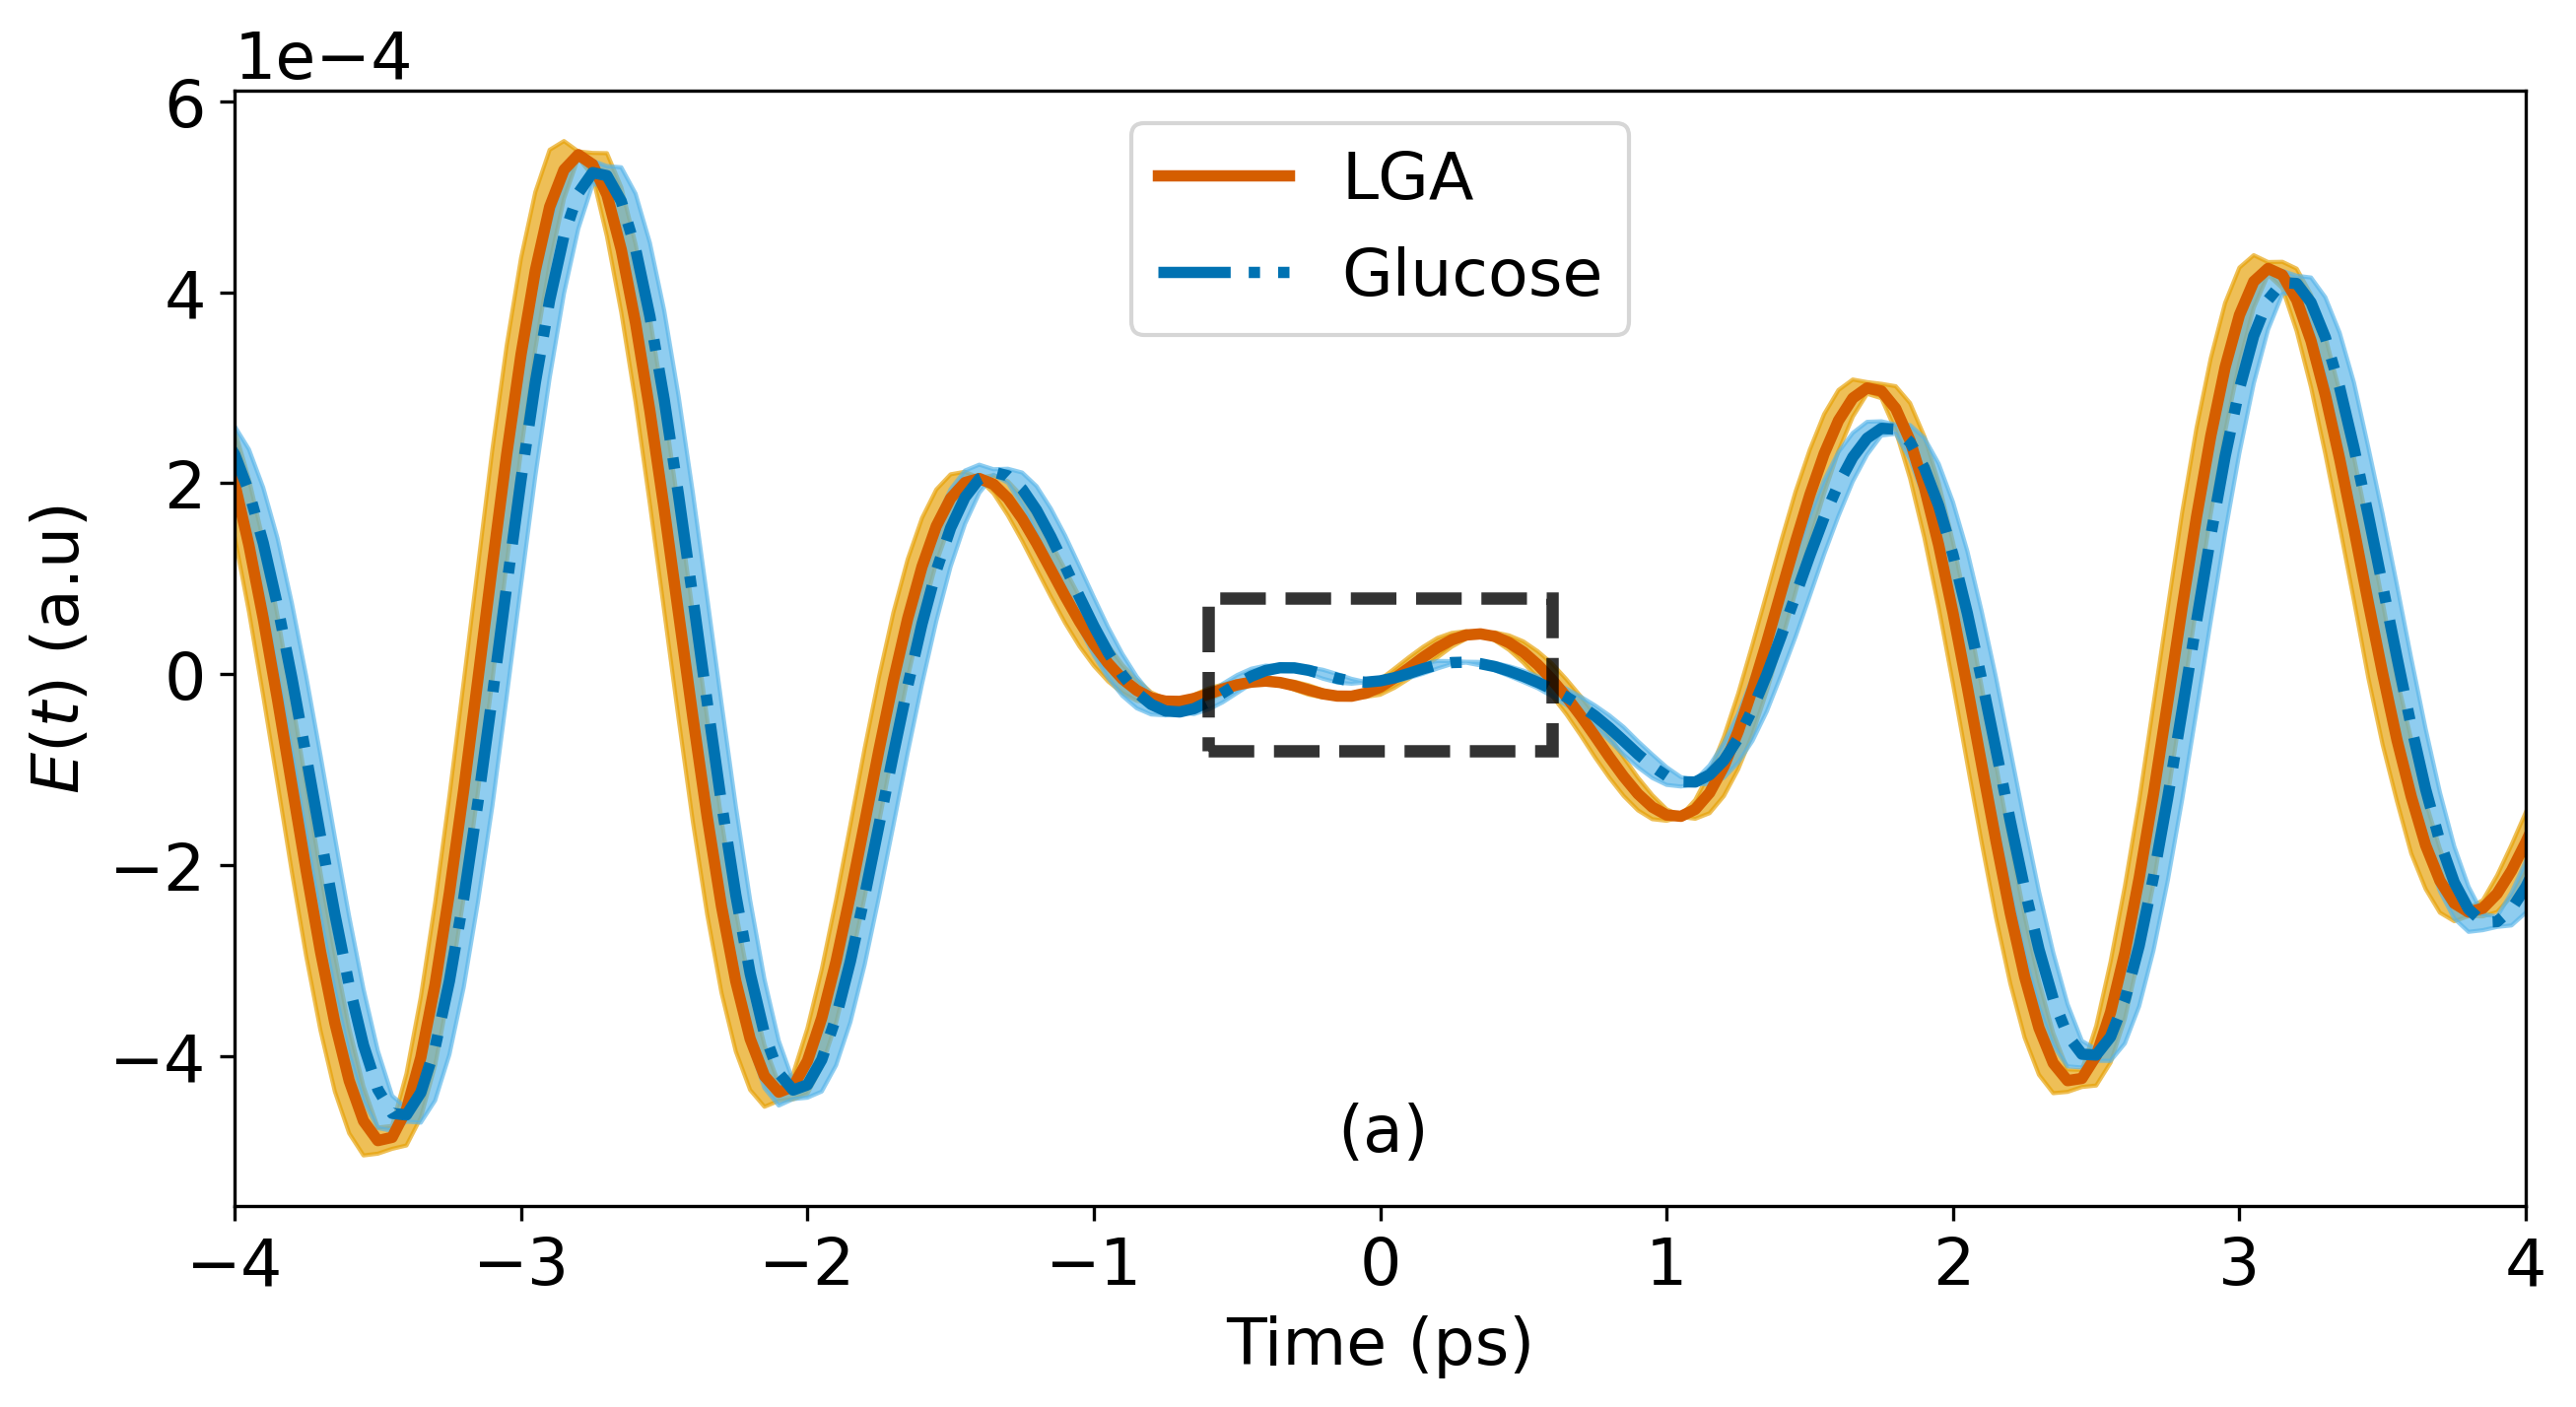

In [34]:
plt.figure(figsize=(10,5))
plt.plot(lga_times[0]-20, average_lga, color=ok['red'], linewidth=2.75, label='LGA')
plt.plot(glu_times[0]-20, average_glu, color=ok['navy'], linewidth=2.75, linestyle="-.", label='Glucose')
plt.subplot().add_patch(
    patches.Rectangle((-0.6, -.8e-4), 1.2, 1.6e-4, linestyle='--', linewidth=3, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3)) #, label='Superoscillating region'))
plt.fill_between(lga_times[0]-20, average_lga-std_err_lga, average_lga+std_err_lga, color=ok['orange'], alpha=0.66)
plt.fill_between(glu_times[0]-20, average_glu-std_err_glu, average_glu+std_err_glu, color=ok['blue'], alpha=0.66)
plt.subplot().text(-0.15, -5e-4, '(a)', fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0.00052, 0.00052))
plt.xlim(-4, 4)
plt.xlabel('Time (ps)')
plt.ylabel('$E(t)$ (a.u)')
plt.legend(loc='upper center')
plt.savefig('./Plots/Paper/StandardErrorForFields.pdf')



In [96]:
def get_J(e1, e2, times, delta, err=0.001):
    int_times = times[np.logical_and(times>=-delta-err, times<=delta+err)]
    int_region = slice(int(len(e1)/2 - 0.5 * len(int_times)), int(len(e1)/2 + 0.5 * len(int_times)))
    # print(int_times)
    # print('length of the transmitted field: {}'.format(len(e1)))
    # print('length of time array: {}'.format(len(int_times)))
    # print('Lower Slice point: '.format(int(len(e1)/2 - 0.5 * len(int_times))))
    # print('length of sliced array: {}'.format(len(e1[int_region])))
    num = simps(np.abs(e1[int_region] - e2[int_region]) **2, int_times)
    den = 0.5 * simps(np.abs(e1[int_region]) ** 2 + np.abs(e2[int_region]) ** 2, int_times)
    #print(min([num, den]))
    return num/den

def get_J_alternate(e1, e2, times, delta, err=0.001):
    e1-= np.average(e1)
    e2-= np.average(e2)
    num = simps(np.abs(e1 - e2) **2, times)
    den = 0.5 * simps(np.abs(e1) ** 2 + np.abs(e2) ** 2, times)
    return num/den

def get_avg(arrays):
    return np.sum(arrays, axis=0)/len(arrays)

In [92]:
J_err_res = np.empty(shape=(4, 10)+(0,)).tolist()
J_method2 = [[], [], [], [], [], [], [], [], [], []]
test2 = [[], [], [], [], [], [], [], [], [], []]
window = np.linspace(0.05, 4, 80)
tObs = []
#test = get_J(glu_source[0][0], lga_source[0][0], source_times, 0.05)
for _ in window:  
        for i in range(len(glu_amps)):
            test2[i].append(get_J(glu_amps[i], lga_amps[i], source_times, _))
            J_err_res[0][i].append(get_J(glu_source[0][i], lga_source[0][i], source_times, _))
            J_err_res[1][i].append(get_J(glu_source[1][i], lga_source[1][i], source_times, _))
            J_err_res[2][i].append(get_J(glu_source[2][i], lga_source[2][i], source_times, _))
            J_err_res[3][i].append(get_J(glu_source[3][i], lga_source[3][i], source_times, _))
            
ub = int(len(source_times)/2)+1           
for _ in range(ub):
        wedge = slice(_, len(source_times) - _)
        tObs.append(source_times[wedge][-1])
        for i in range(len(glu_amps)):
            J_method2[i].append(get_J_alternate(glu_amps[i][wedge], lga_amps[i][wedge], source_times[wedge], 
                                             [source_times[_], source_times[-(_+1)]]))

slice(0, 201, None)
slice(1, 200, None)
slice(2, 199, None)
slice(3, 198, None)
slice(4, 197, None)
slice(5, 196, None)
slice(6, 195, None)
slice(7, 194, None)
slice(8, 193, None)
slice(9, 192, None)
slice(10, 191, None)
slice(11, 190, None)
slice(12, 189, None)
slice(13, 188, None)
slice(14, 187, None)
slice(15, 186, None)
slice(16, 185, None)
slice(17, 184, None)
slice(18, 183, None)
slice(19, 182, None)
slice(20, 181, None)
slice(21, 180, None)
slice(22, 179, None)
slice(23, 178, None)
slice(24, 177, None)
slice(25, 176, None)
slice(26, 175, None)
slice(27, 174, None)
slice(28, 173, None)
slice(29, 172, None)
slice(30, 171, None)
slice(31, 170, None)
slice(32, 169, None)
slice(33, 168, None)
slice(34, 167, None)
slice(35, 166, None)
slice(36, 165, None)
slice(37, 164, None)
slice(38, 163, None)
slice(39, 162, None)
slice(40, 161, None)
slice(41, 160, None)
slice(42, 159, None)
slice(43, 158, None)
slice(44, 157, None)
slice(45, 156, None)
slice(46, 155, None)
slice(47, 154, None)
sl

/tmp/ipykernel_48453/3267453097.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return num/den


In [82]:
print(int(len(source_times)/2))

100


(0.15, 4.0)

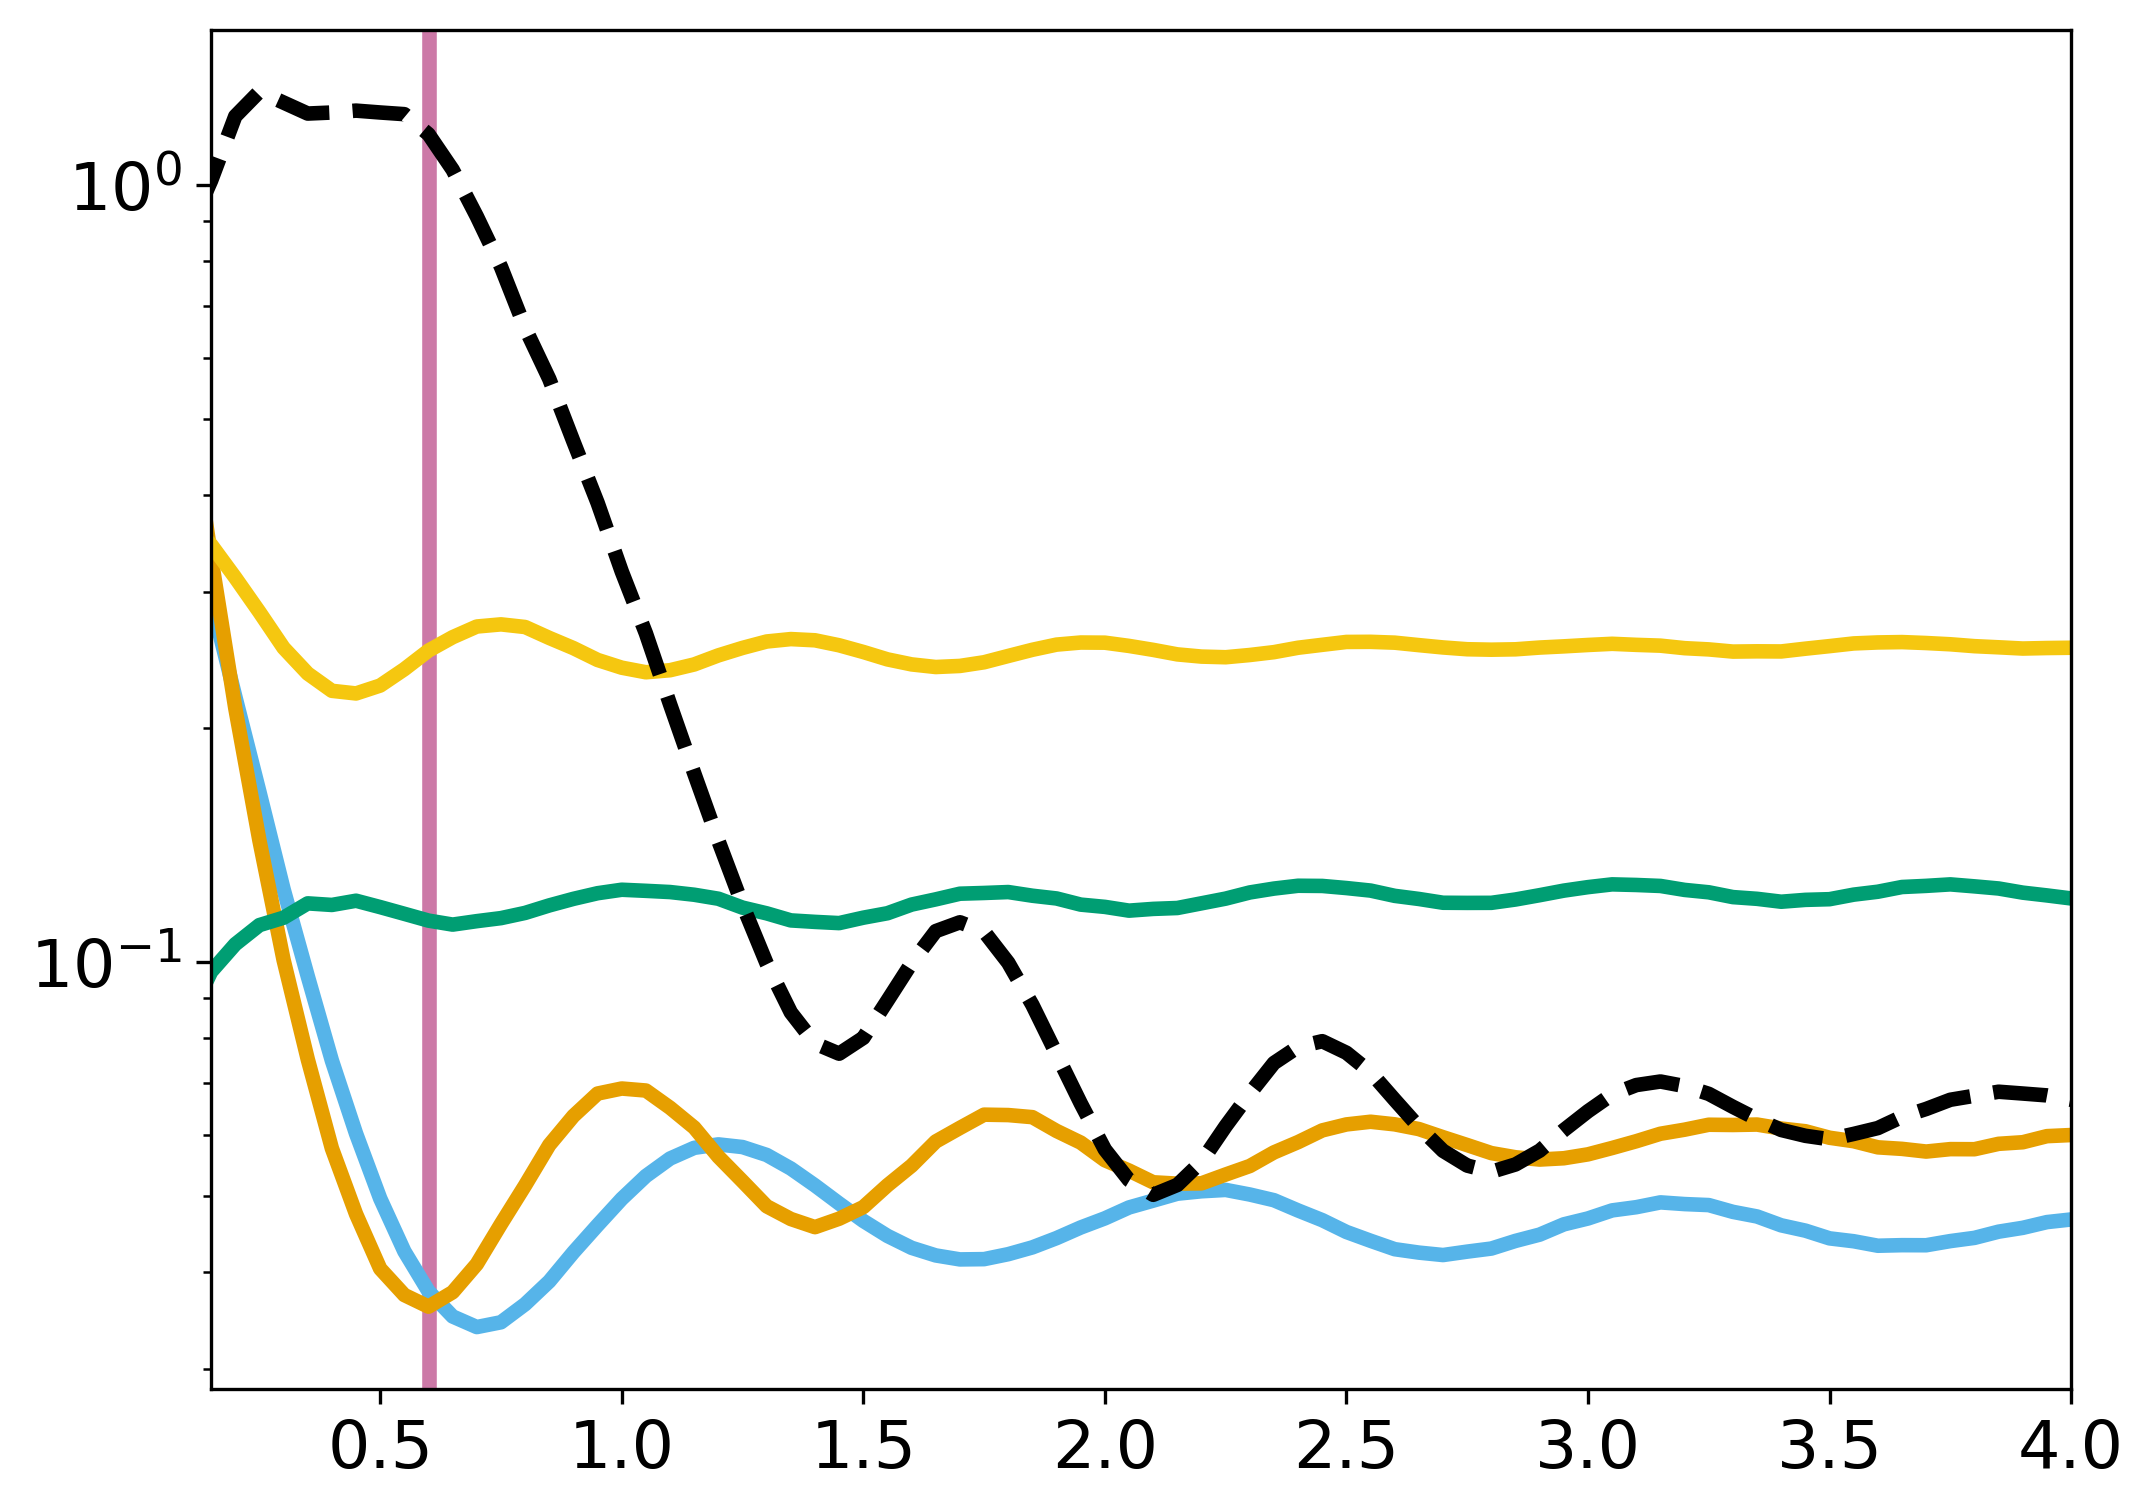

In [50]:
plt.figure()
plt.axvline(0.6, color=ok['purple'], label='$\Delta = T_{SO}$')

plt.semilogy(window, J_err_res[0][0], label='Calculation 0.52', color=ok['blue'])
plt.semilogy(window, J_err_res[1][0], label='Calculation 0.63', color=ok['orange'])
plt.semilogy(window, J_err_res[2][0], label='Calculation 0.72', color=ok['green'])
plt.semilogy(window, J_err_res[3][0], label='Calculation 0.82', color=ok['amber'])
plt.semilogy(window, test2[0], label='Calculated SO', color=ok['black'], linestyle='--')

"""plt.semilogy(f5b[h5b[1]].T[0] * 0.5, (10 ** f5b[h5b[1]]).T[1], label=h5b[1], linestyle='-.', color=ok['amber'])
plt.semilogy(f5b[h5b[2]].T[0] * 0.5, (10 ** f5b[h5b[2]]).T[1], label=h5b[2], color=ok['green'])
plt.semilogy(f5b[h5b[3]].T[0] * 0.5, (10 ** f5b[h5b[3]]).T[1], label=h5b[3], color=ok['orange'])
plt.semilogy(f5b[h5b[4]].T[0] * 0.5, (10 ** f5b[h5b[4]]).T[1], label=h5b[4], linestyle='-.', color=ok['blue'])
plt.semilogy(f5b[h5b[0]].T[0] * 0.5, (10 ** f5b[h5b[0]]).T[1], label=h5b[0], linestyle='--', color=ok['black'])"""

#plt.legend()
plt.xlim(0.15, 4)

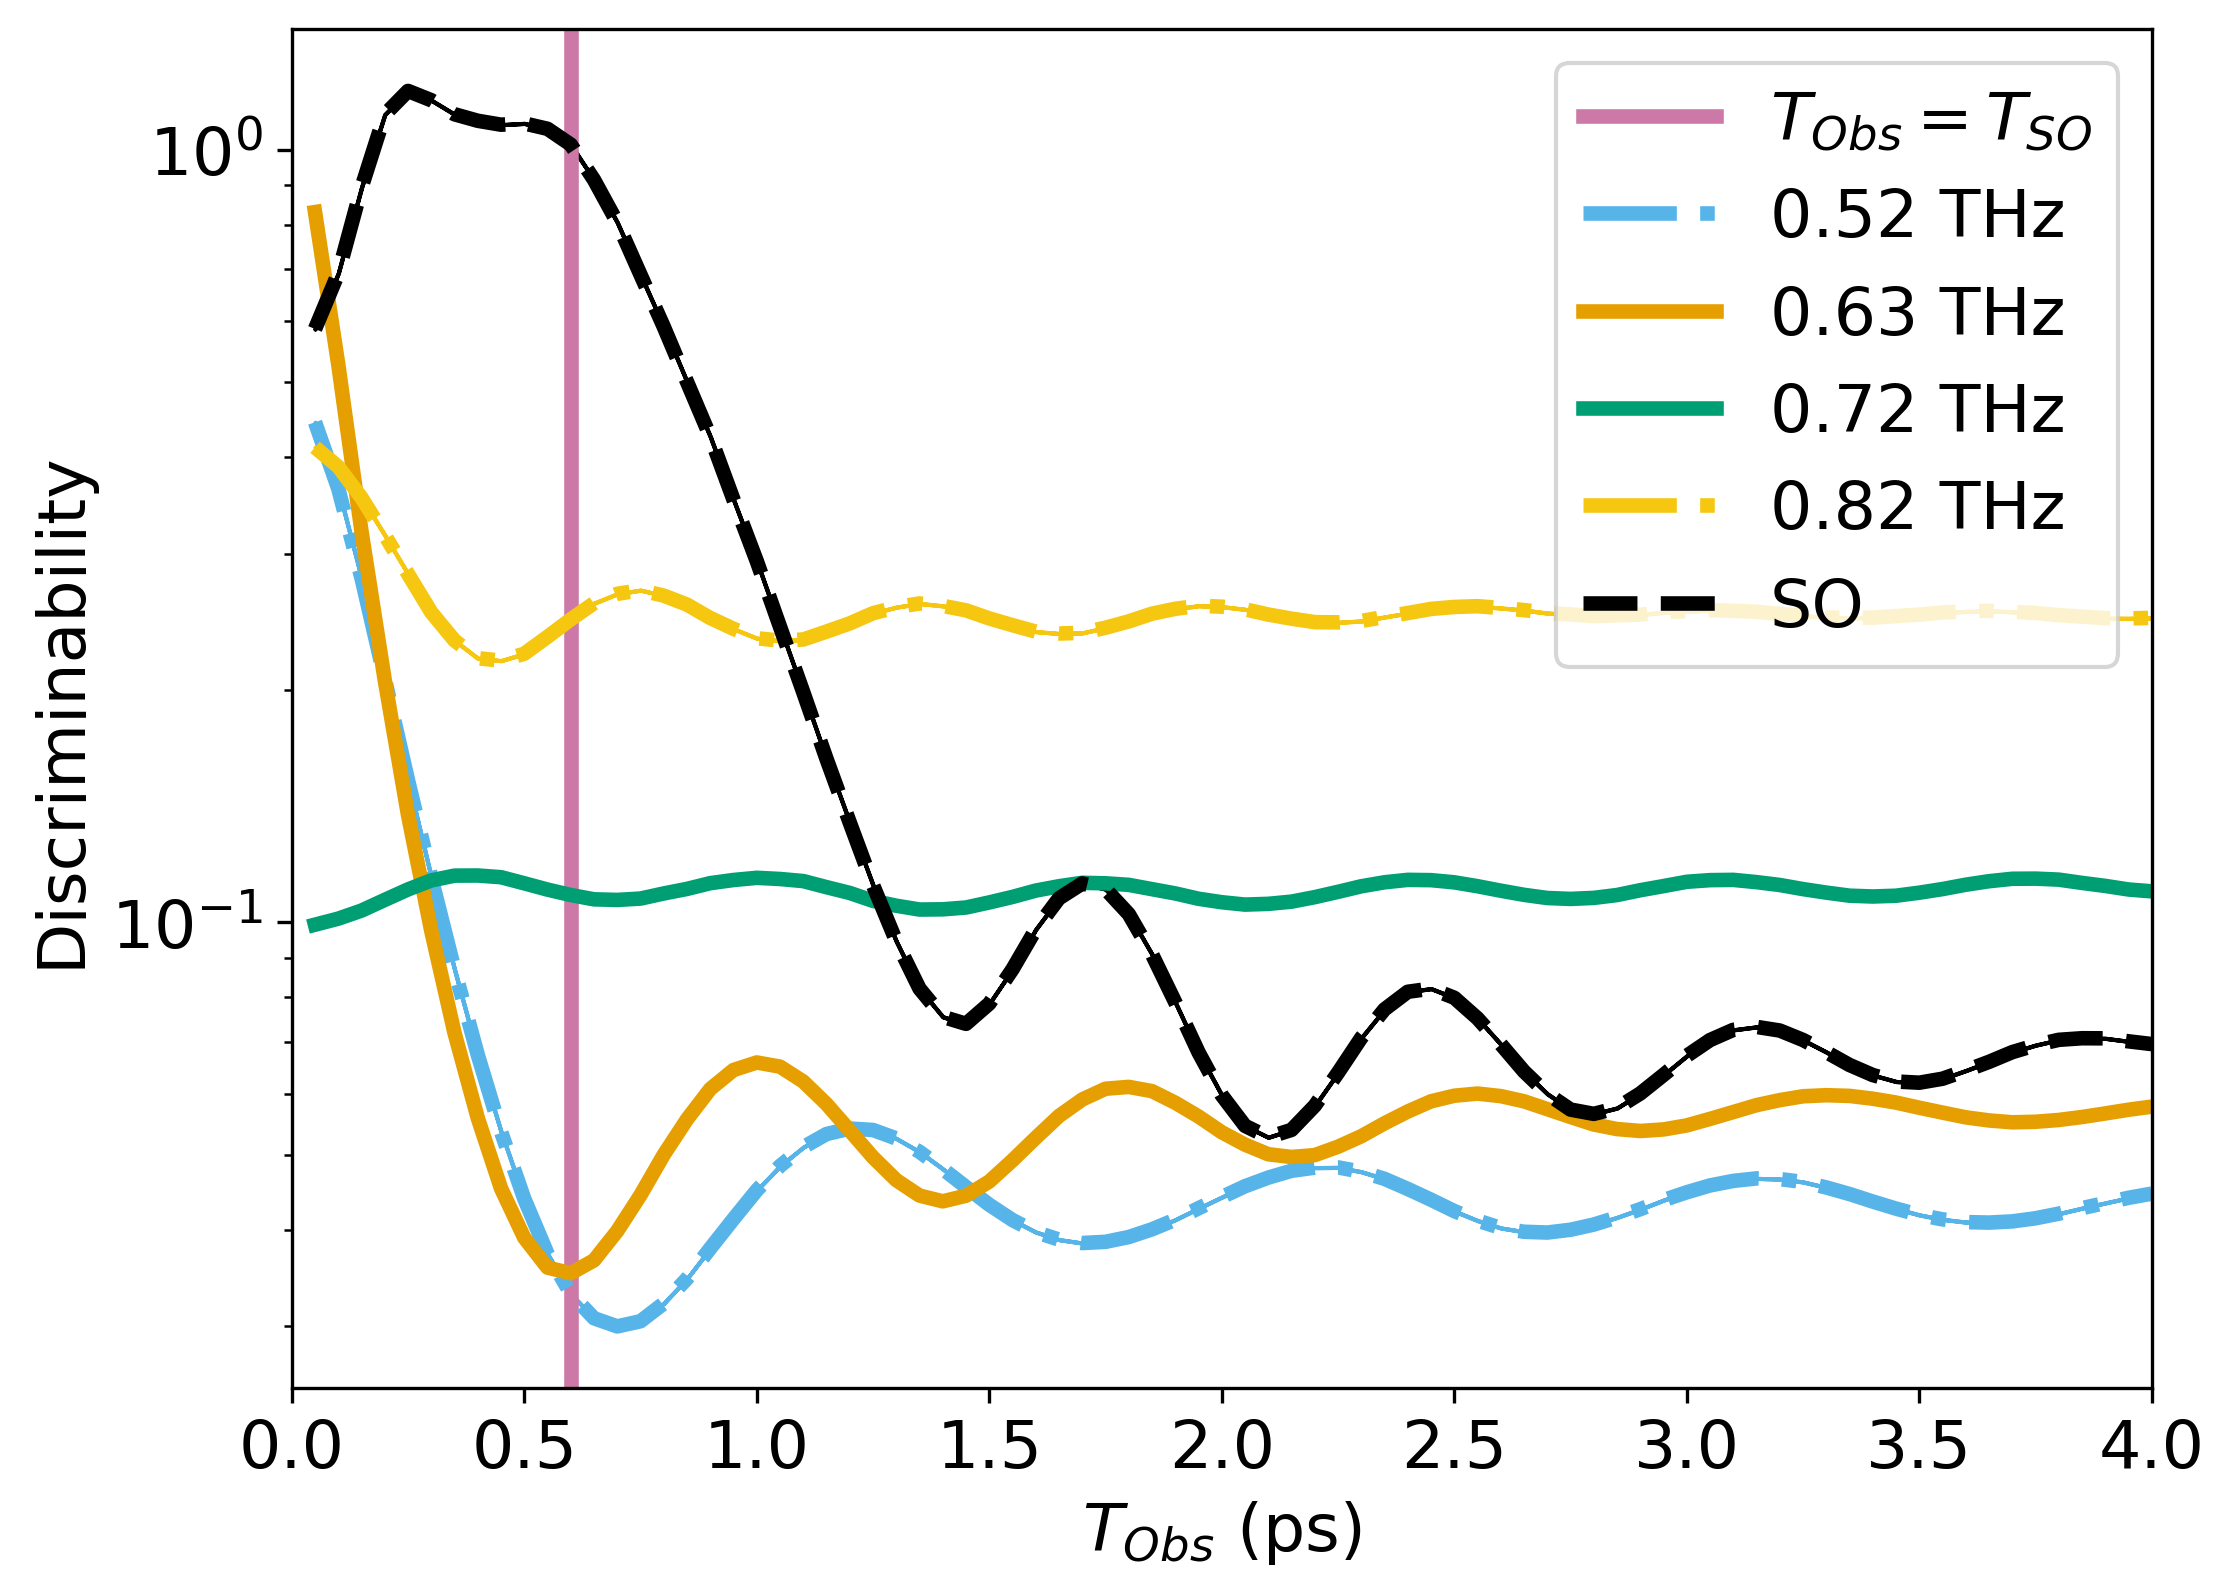

In [90]:
plt.figure()
plt.axvline(0.6, color=ok['purple'], label='$T_{Obs} = T_{SO}$')

avg05 = get_avg(J_err_res[0])
err05 = get_std_err(J_err_res[0], avg05)
plt.fill_between(window, avg05-err05, avg05+err05, color=ok['blue'])#, label='0.52 THz Error')
avg06 = get_avg(J_err_res[1])
err06 = get_std_err(J_err_res[1],avg06)
plt.fill_between(window, avg06-err06, avg06+err06, color=ok['orange'])#,label='0.63 THz Error')
avg07 = get_avg(J_err_res[2])
err07 = get_std_err(J_err_res[2], avg07)
plt.fill_between(window, avg07-err07, avg07+err07, color=ok['green'])#, label='0.72 THz Error')
avg08 = get_avg(J_err_res[3])
err08 = get_std_err(J_err_res[3], avg08)
plt.fill_between(window, avg08-err08, avg08+err08, color=ok['amber'])#, label='0.82 THz Error')

avgSO = get_avg(test2)
errSO = get_std_err(test2, avgSO)
plt.fill_between(window, avgSO-errSO, avgSO+errSO, color=ok['black'])#, label='SO Error')

plt.semilogy(window, get_avg(J_err_res[0]), label='0.52 THz', color=ok['blue'], linestyle='-.')
plt.semilogy(window, get_avg(J_err_res[1]), label='0.63 THz', color=ok['orange'])
plt.semilogy(window, get_avg(J_err_res[2]), label='0.72 THz', color=ok['green'])
plt.semilogy(window, get_avg(J_err_res[3]), label='0.82 THz', color=ok['amber'], linestyle='-.')

plt.semilogy(window, avgSO, label='SO', color=ok['black'], linestyle='--')
plt.xlim(0, 4)
plt.xlabel('$T_{Obs}$ (ps)')
plt.ylabel('Discriminability')
plt.legend()
plt.savefig('./Plots/Paper/DiscriminabilityAverages.pdf')
plt.show()

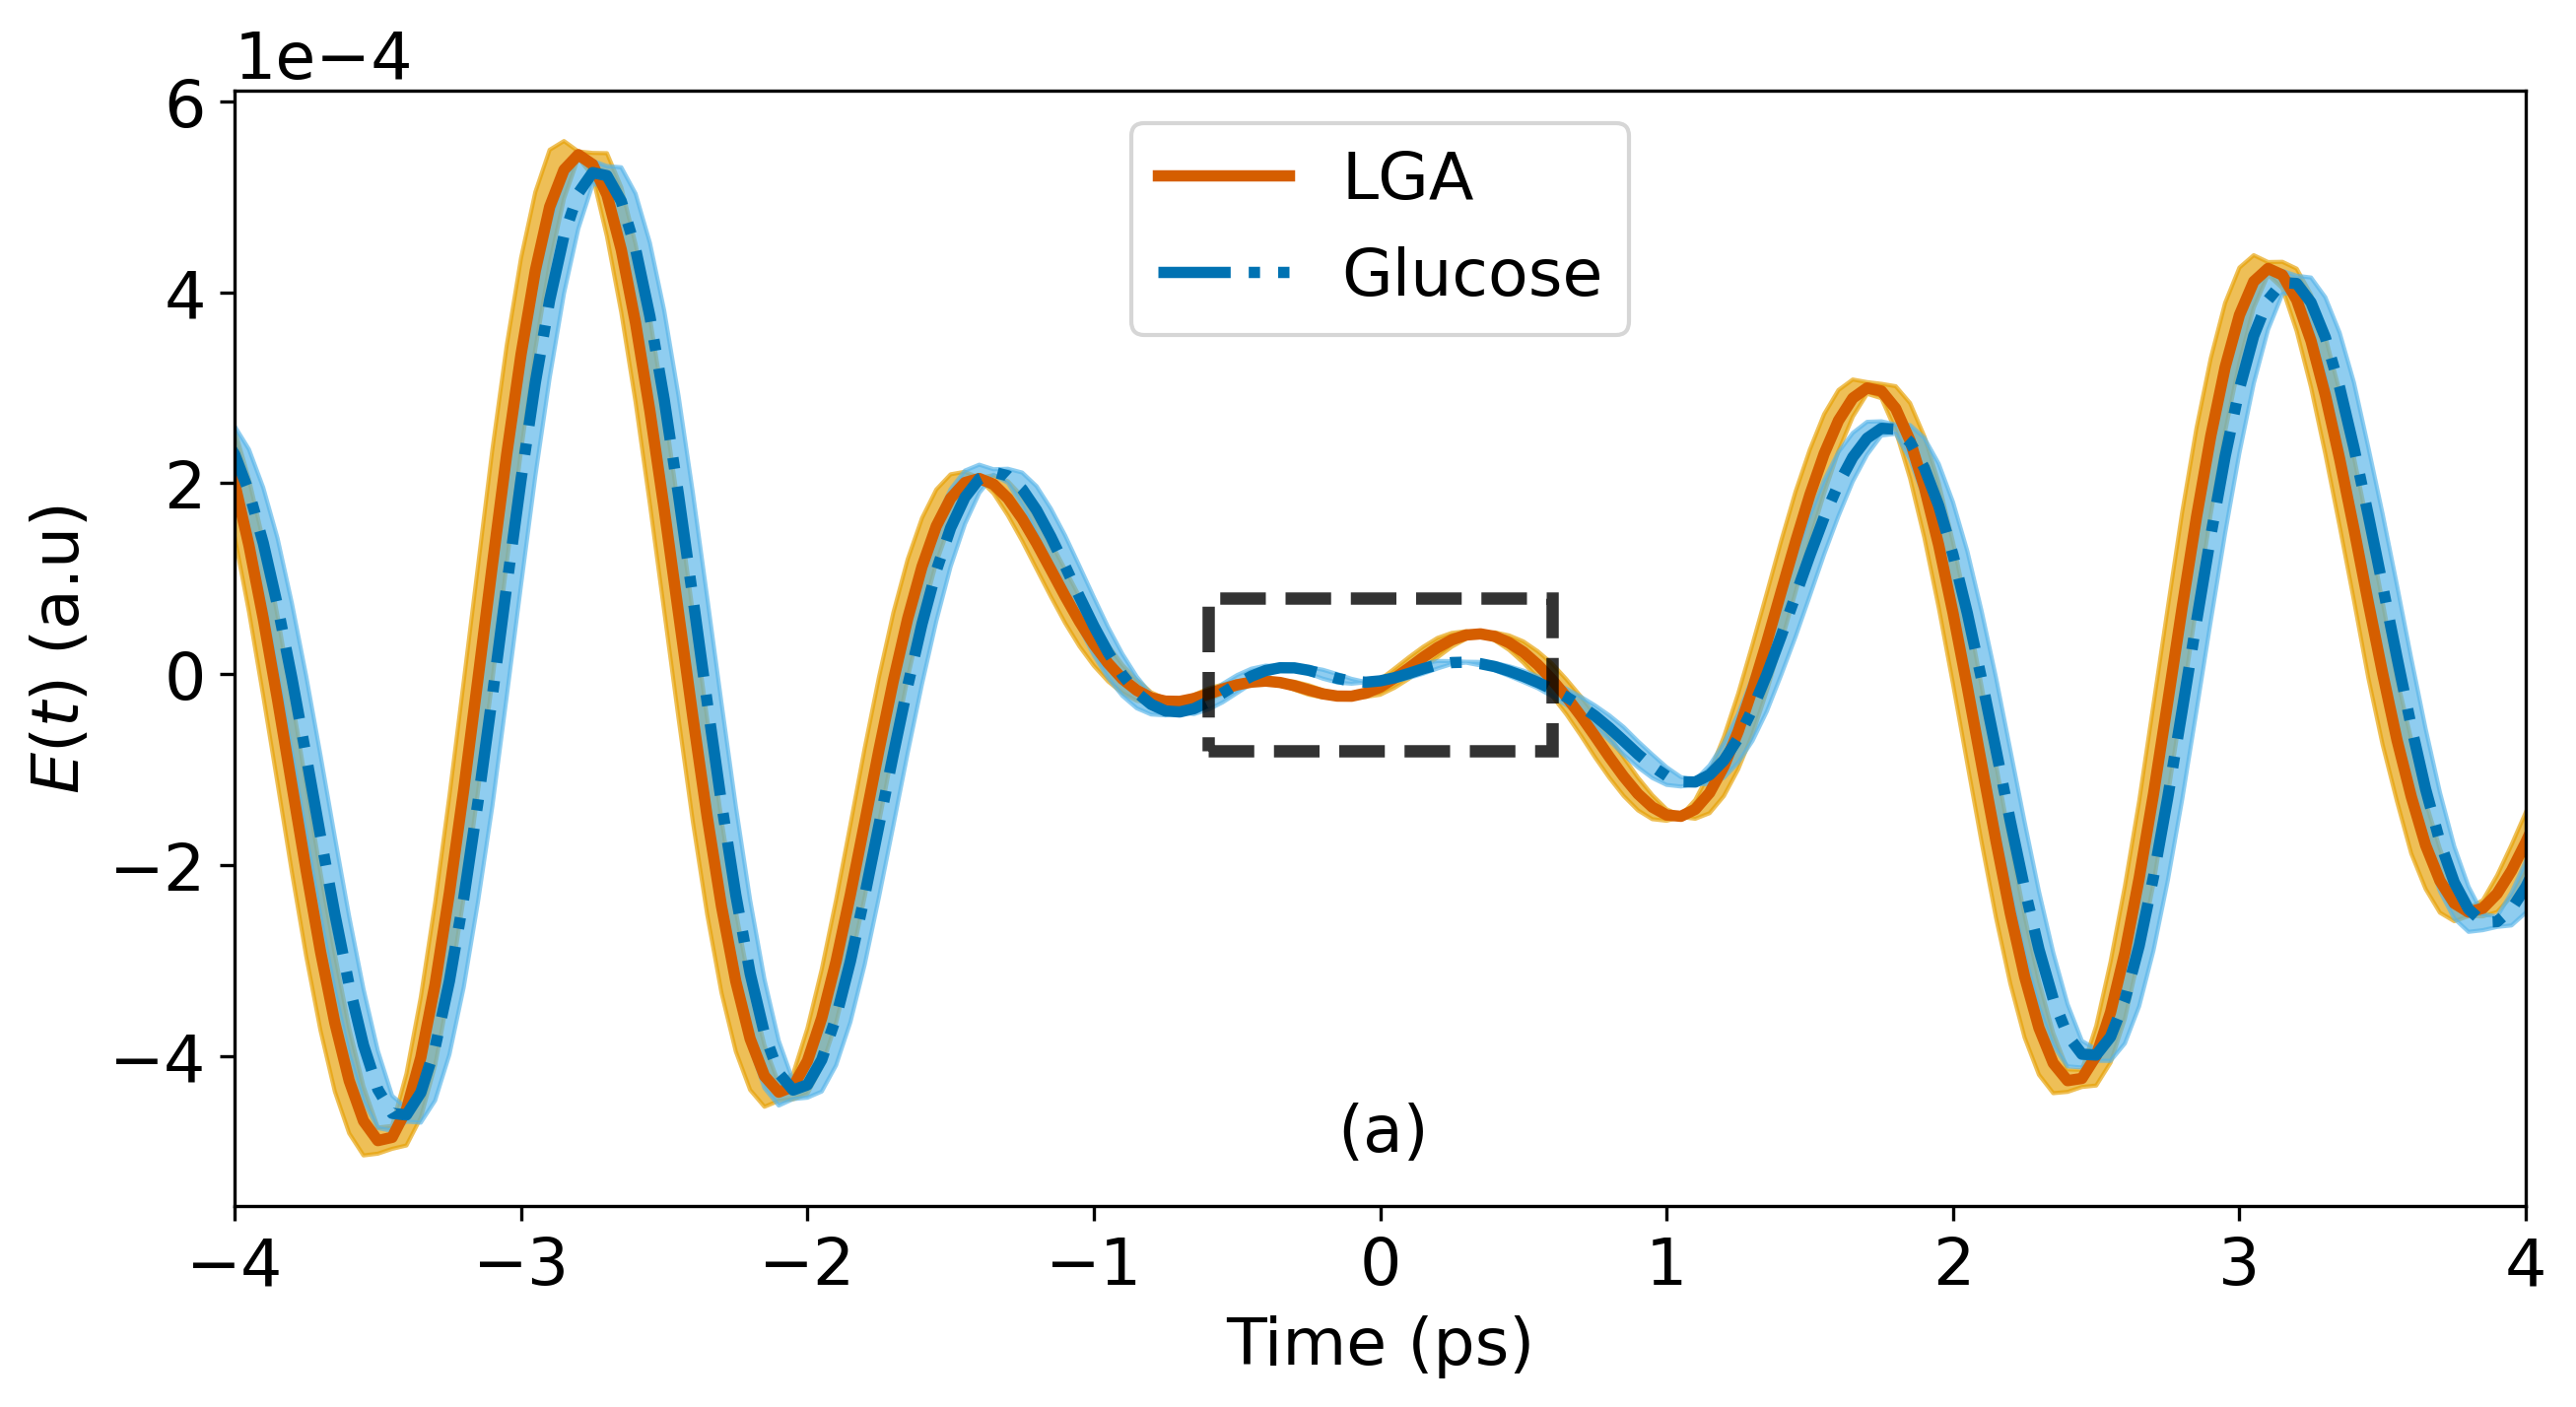

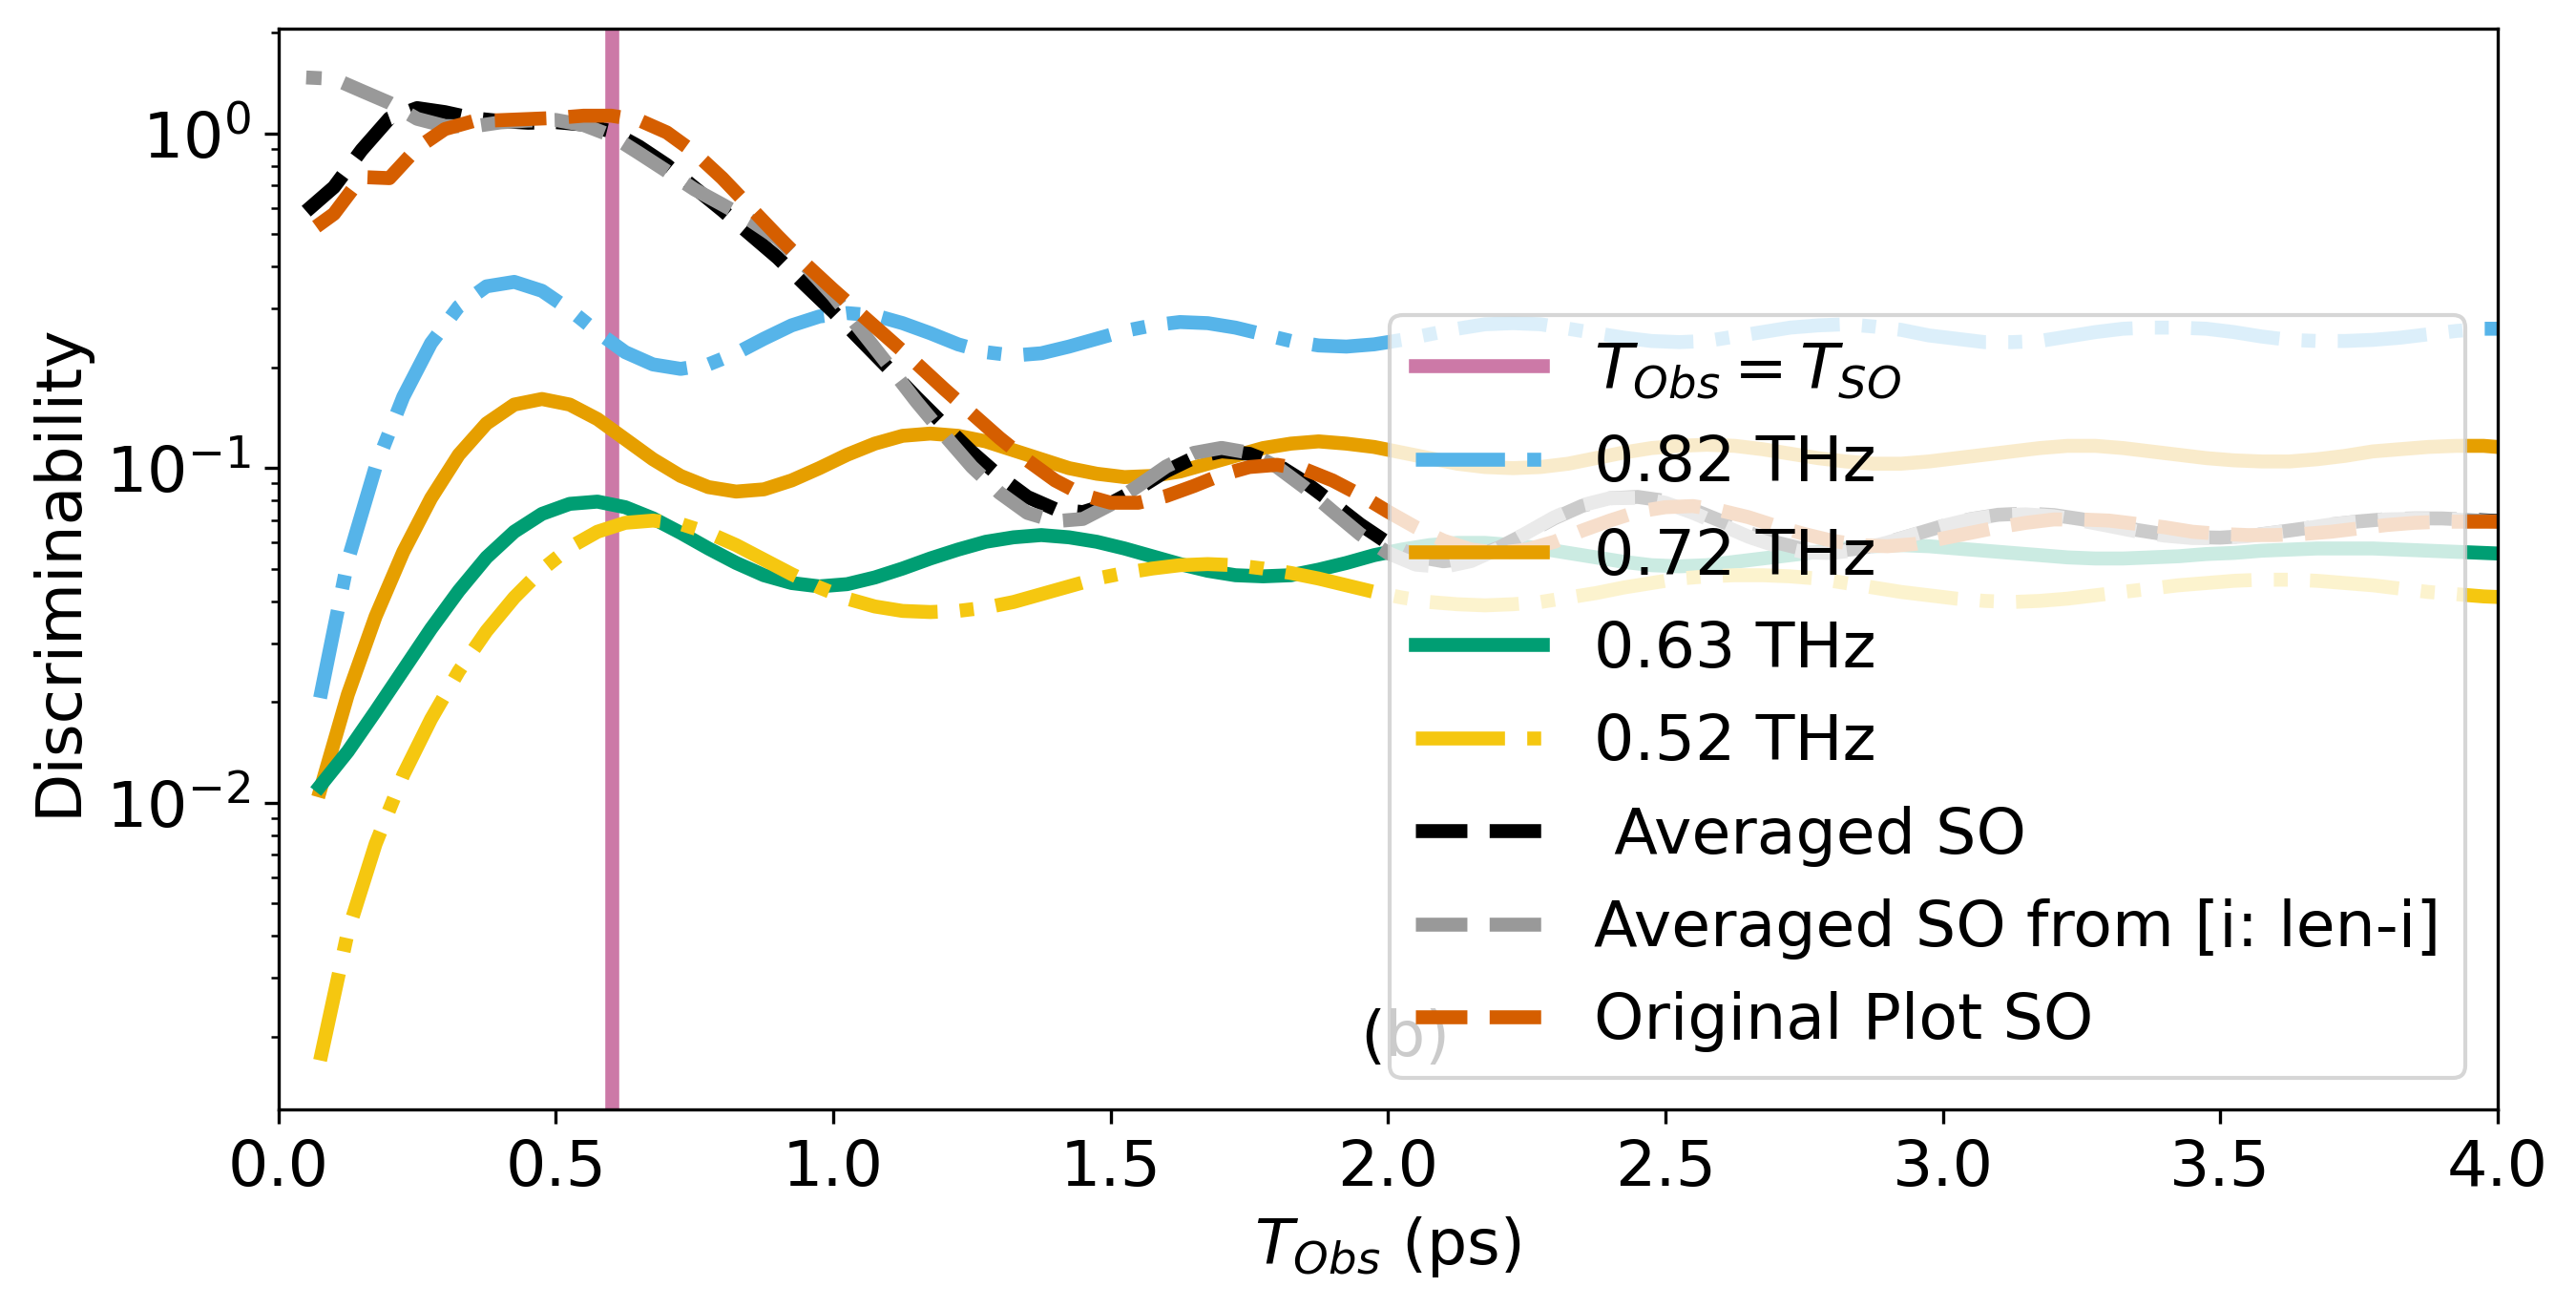

In [97]:
plt.figure(figsize=(10,5))
plt.plot(lga_times[0]-20, average_lga, color=ok['red'], linewidth=2.75, label='LGA')
plt.plot(glu_times[0]-20, average_glu, color=ok['navy'], linewidth=2.75, linestyle="-.", label='Glucose')
plt.subplot().add_patch(
    patches.Rectangle((-0.6, -.8e-4), 1.2, 1.6e-4, linestyle='--', linewidth=3, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3)) #, label='Superoscillating region'))
plt.fill_between(lga_times[0]-20, average_lga-std_err_lga, average_lga+std_err_lga, color=ok['orange'], alpha=0.66)
plt.fill_between(glu_times[0]-20, average_glu-std_err_glu, average_glu+std_err_glu, color=ok['blue'], alpha=0.66)
plt.subplot().text(-0.15, -5e-4, '(a)', fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0.00052, 0.00052))
plt.xlim(-4, 4)
plt.xlabel('Time (ps)')
plt.ylabel('$E(t)$ (a.u)')
plt.legend(loc='upper center')
plt.savefig('./Plots/Paper/MeasuredWavesError.pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(0.6, color=ok['purple'], label='$T_{Obs} = T_{SO}$')
plt.semilogy(f5b[h5b[1]].T[0] * 0.5, (10 ** f5b[h5b[1]]).T[1], label=h5b[1], linestyle='-.')
plt.semilogy(f5b[h5b[2]].T[0] * 0.5, (10 ** f5b[h5b[2]]).T[1], label=h5b[2])
plt.semilogy(f5b[h5b[3]].T[0] * 0.5, (10 ** f5b[h5b[3]]).T[1], label=h5b[3])
plt.semilogy(f5b[h5b[4]].T[0] * 0.5, (10 ** f5b[h5b[4]]).T[1], label=h5b[4], linestyle='-.')

plt.semilogy(window, avgSO, label=' Averaged SO', color=ok['black'], linestyle='--')
plt.semilogy(tObs, get_avg(J_method2), label = 'Averaged SO from [i: len-i]', linestyle='--', color=ok['grey'])
plt.semilogy(f5b[h5b[0]].T[0] * 0.5, (10 ** f5b[h5b[0]]).T[1], label="Original Plot SO", linestyle='--', color=ok['red'])

plt.subplot().text(1.95, 1.75e-3, '(b)', fontsize=16)

plt.xlim([0, 4])
#plt.ylim([-2.62, 0.3])
plt.xlabel("$T_{Obs}$ (ps)")
plt.ylabel("Discriminability")
plt.legend(loc='lower right')
#plt.tight_layout()
plt.savefig('./Plots/Paper/MeasuredJShiftedTestingWithCorrection.pdf')
plt.show()

In [24]:
def get_error(avg_field, individual_fields):
    confidence_level=0.95
    # Substract the mean from experimental fields to compensate for parasitic offset
    avg_field -= avg_field.mean()
    err_lower_bound, err_upper_bound = stats.t.interval(
            confidence_level, 
            individual_fields.shape[0], 
            avg_field, 
            stats.sem(individual_fields)
    )
    return [err_lower_bound, err_upper_bound]

def get_err_combined_field(time_delays, time_window):
    return np.sqrt(sum(
        (_.err_upper_bound(time_window - delay) - _.err_lower_bound(time_window - delay) )** 2 
            for delay, _ in zip(time_delays, pulses.values())
    ))

/home/dustin/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/dustin/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


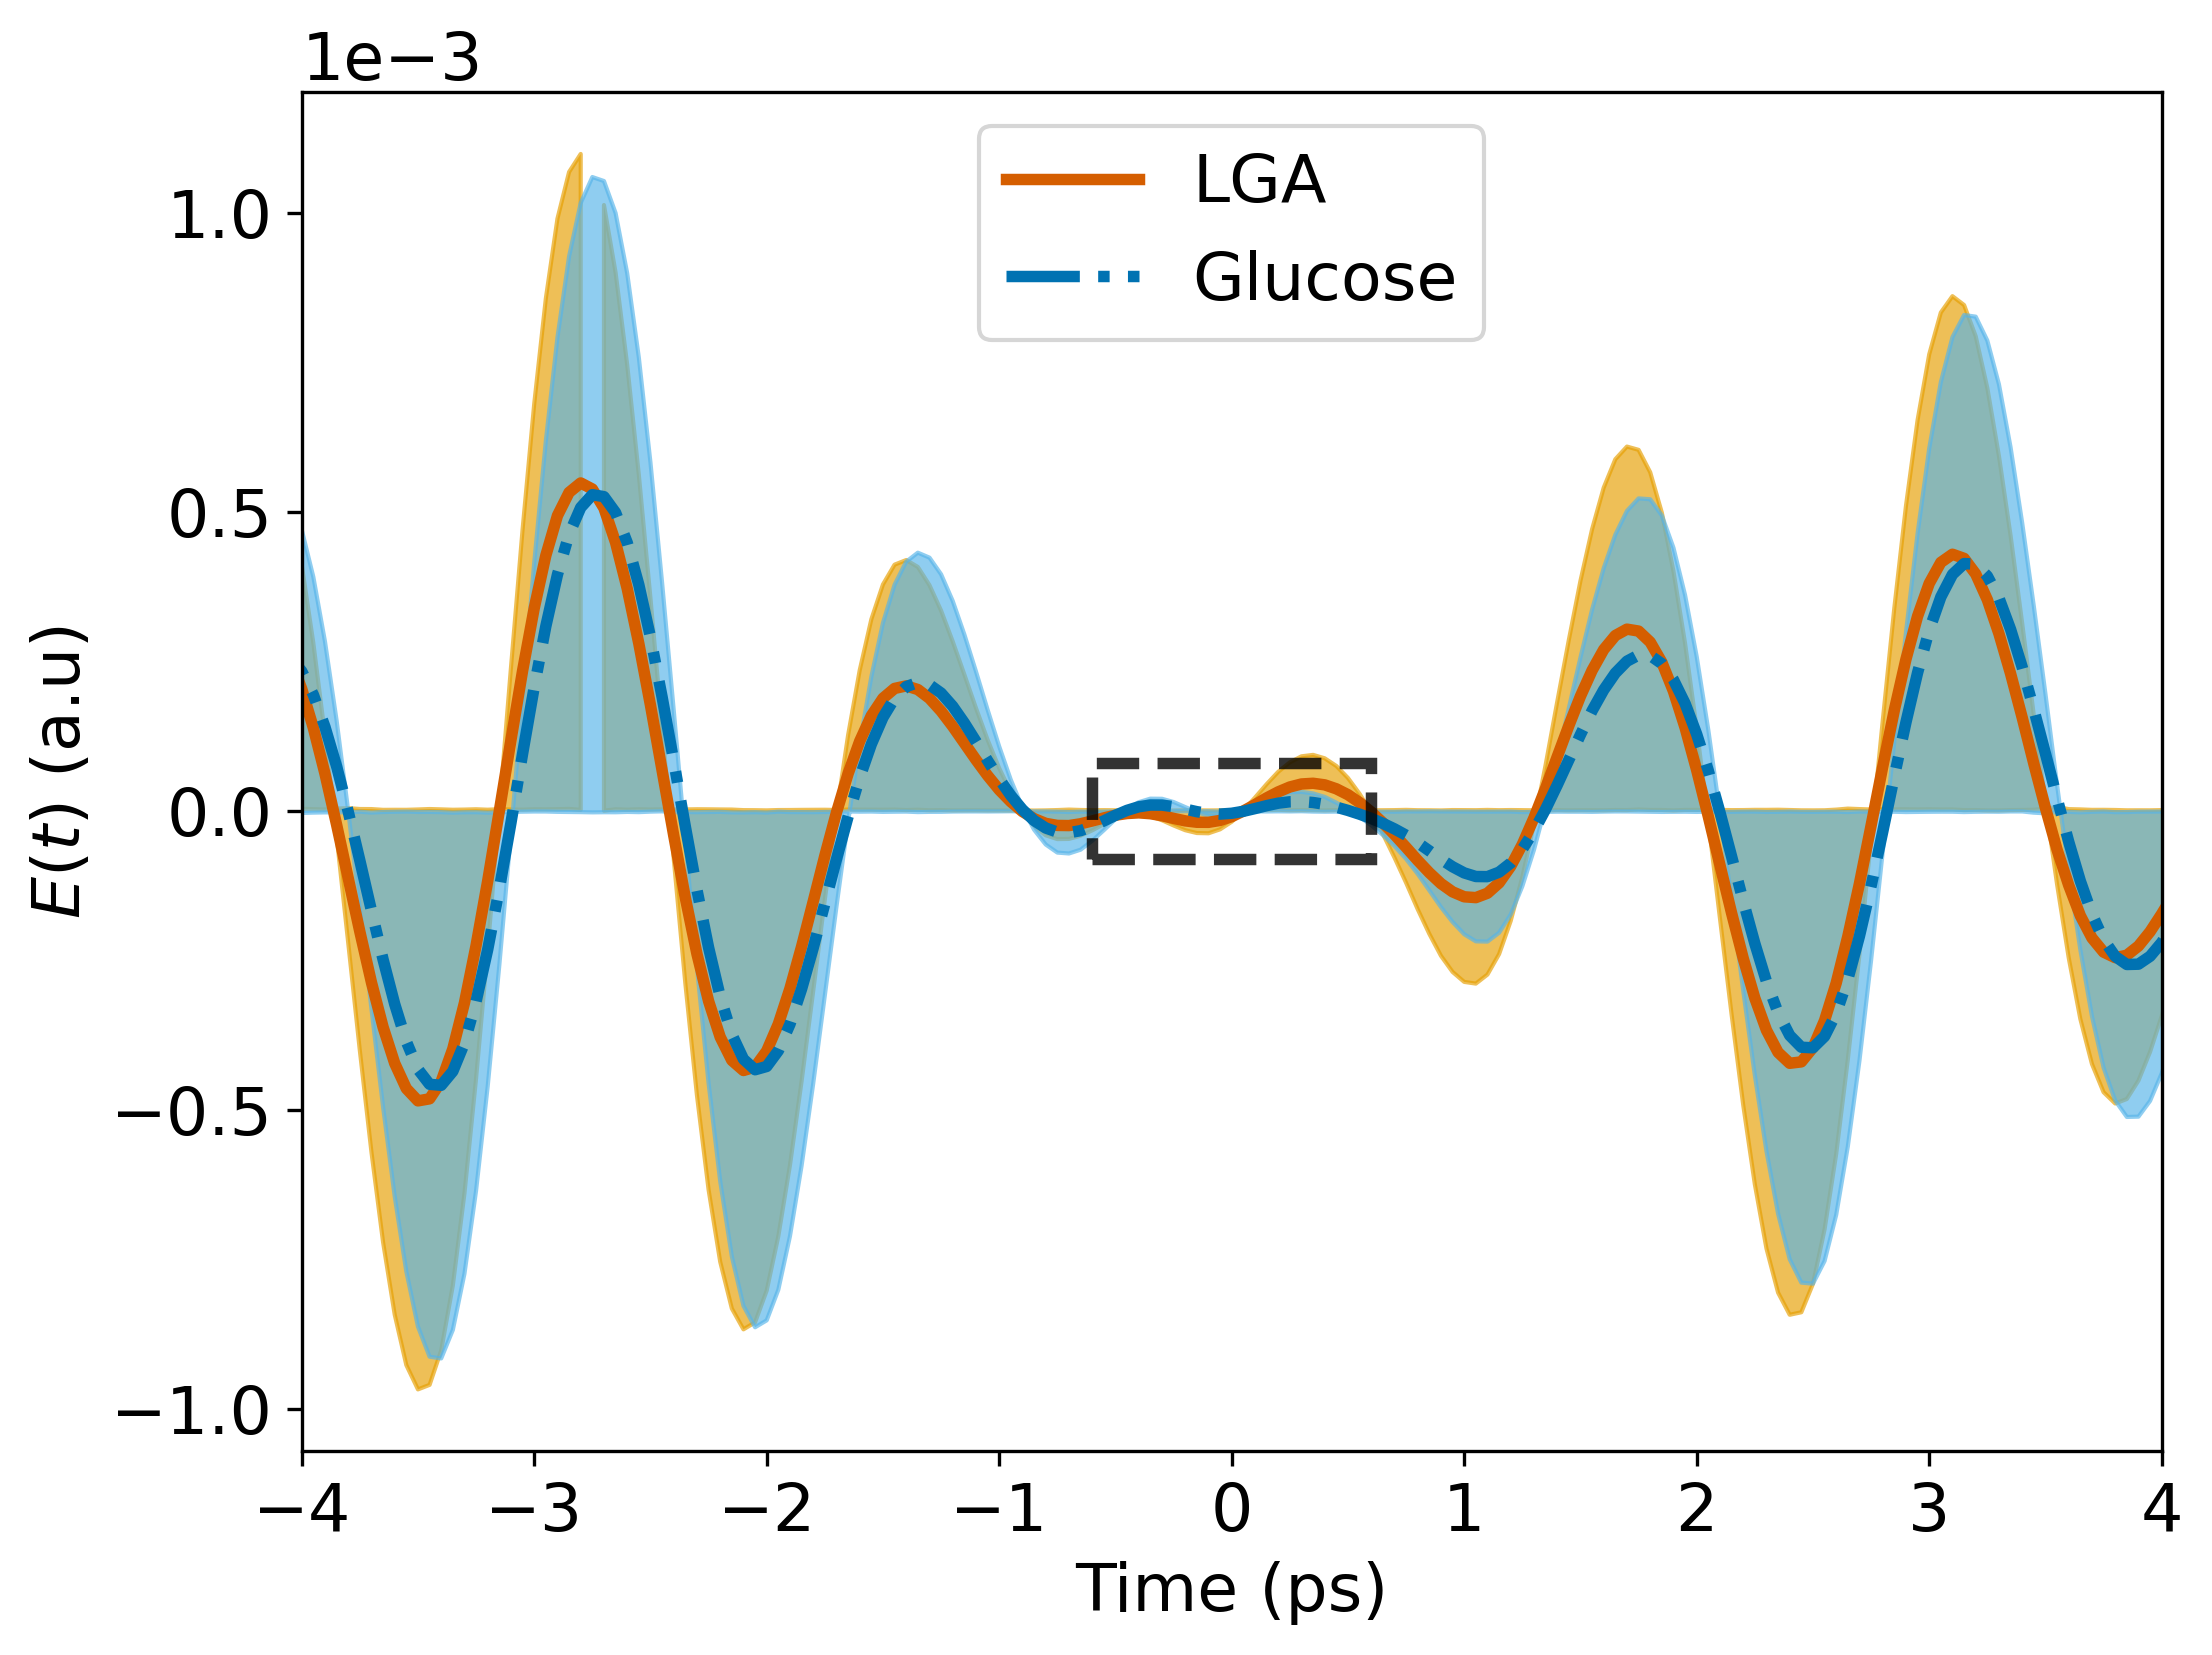

In [126]:
plt.figure()
plt.plot(lga_times[0]-20, average_lga, color=ok['red'], linewidth=2.75, label='LGA')
plt.plot(glu_times[0]-20, average_glu, color=ok['navy'], linewidth=2.75, linestyle="-.", label='Glucose')
plt.subplot().add_patch(
    patches.Rectangle((-0.6, -.8e-4), 1.2, 1.6e-4, linestyle='--', linewidth=2.75, edgecolor=ok['black'], 
                      facecolor='none', alpha=0.8, zorder=3)) #, label='Superoscillating region'))
plt.fill_between(lga_times[0]-20, 
                 average_lga-get_error(average_lga, lga_amps)[0],
                 average_lga+get_error(average_lga, lga_amps)[1], 
                 color=ok['orange'], alpha=0.66)
plt.fill_between(glu_times[0]-20, 
                 average_glu-get_error(average_glu, glu_amps)[1], 
                 average_glu+get_error(average_glu, glu_amps)[1], 
                 color=ok['blue'], alpha=0.66)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-0.00052, 0.00052))
plt.xlim(-4, 4)
plt.xlabel('Time (ps)')
plt.ylabel('$E(t)$ (a.u)')
plt.legend(loc='upper center')
plt.savefig('./Plots/Paper/DenysErrorForFields.pdf')

In [60]:
def load_experimental_so(file_template):
    
    # load file names matching the pattern
    filenames = sorted(glob.glob(folder_data + file_template))
    
    if len(filenames) == 0:
        # Nothing to load
        return
    
    all_data = [np.loadtxt(_).T[:-1] for _ in filenames]
    
    times, _individual_fields = zip(*all_data)
    
    _individual_fields = np.array(_individual_fields)
    
    time = times[0]
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"

    #  Checking whether the time axis coincide
    assert all(np.allclose(time, _) for _ in times), \
        "This workbook cannot be used since the time data is not syncronized"
    
    field = np.mean(_individual_fields, axis=0)
    
    # Substract the mean from experimental fields to compensate for parasitic offset
    field -= field.mean()
    
    # calculate the confidence interval
    err_lower_bound, err_upper_bound = stats.t.interval(
        confidence_level, 
        _individual_fields.shape[0], 
        field, 
        stats.sem(_individual_fields, axis=0)
    )
    
    # Saving the data 
    return Pulse(
        time = time, 
        field = field / max_ampl,
        _individual_fields = _individual_fields,
        err_lower_bound = err_lower_bound / max_ampl,
        err_upper_bound = err_upper_bound / max_ampl,
    )

error = get_err_combined_field(time_delays, time_window)
        axs[n, 1].fill_between(
            time_window, 
            field - error, 
            field + error,
            alpha=0.6,
            label="theory"
        )
        
    
        axs[n, 1].errorbar(
            short.time, 
            short.field, 
            yerr=short.err_upper_bound - short.err_lower_bound,
            marker='.',
            label="experiment",
            color='tab:orange'
        )